# *Objetivo*


* _*Explorar la informacion proporcionada por **Yahoo** sobre el [valor de las acciones](https://es.finance.yahoo.com/quote/AAPL/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAAXiE2N81FQUuVbSNDP2y4RlQqKjnYbSJTu_fFiIO2eE8D7GqKetWe04OCwxq2GjuhlM7Z-yrPayfSZI7GAQ2USVd40pAuhBE9-w1QnFEr3k1AhfUFy1kr16kqDCfMR1FPKjJXx6Z5VJZVLX81c7P4OrITFD-9k0yxCoXKWodj5z) de la empresa **Apple**.*_




## Analizis Exploratorio


* _*Entender los componentes estacionales de la serie, su tendencia y estacionalidad.*_


* _*Estudiar resampleos y autocorrelaciones.*_


* _*Estudiar Valores Atipicos, Faltantes, Minimos y Maximos. Limpiar los datos en la mejor forma para poder predecir con exito la variable objetivo `Close`.*_


## Machine Learning


* _*Crear un (o varios) modelo que pueda predecir con exactitud el precio `closing` de accion la **AAPL** en [NASDAQ](https://es.wikipedia.org/wiki/Nasdaq_Composite) index para el ultimo trimestre del año 2019.*_


* _*Una vez alcanzado el maximo indice de exactitud con la prediccion establecida, podemos desacargar los datos NASDAQ sobre dicha accion del año **2020**. Luego pedir al modelo que realice un **forecast** y  contrastar los resultados con los datos reales evaluando asi que tan certera es la prediccion del modelo para el año 2020.*_

# *Librerias*

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import missingno as msno
import datetime as dt
import matplotlib.gridspec as gs
import statsmodels.tsa as tsa
import statsmodels.api as sm



from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.stattools import adfuller, kpss
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics




import warnings, itertools
warnings.filterwarnings("ignore")

sns.set(style='darkgrid')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Importing plotly failed. Interactive plots will not work.


# *Cargando Datos*

In [2]:
df = web.DataReader('AAPL', data_source = 'yahoo', start ='2012-01-01' , end = '2019-12-27')

* _*Estamos trabajando con 8 años de informacion (inicios 2012 - fines 2019)*_

# *E.D.A*

In [3]:
df

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2012-01-03  14.732143  14.607143  14.621429  14.686786  302220800.0  12.650659
2012-01-04  14.810000  14.617143  14.642857  14.765714  260022000.0  12.718646
2012-01-05  14.948214  14.738214  14.819643  14.929643  271269600.0  12.859850
2012-01-06  15.098214  14.972143  14.991786  15.085714  318292800.0  12.994284
2012-01-09  15.276786  15.048214  15.196429  15.061786  394024400.0  12.973674
...               ...        ...        ...        ...          ...        ...
2019-12-20  70.662498  69.639999  70.557503  69.860001  275978000.0  69.158508
2019-12-23  71.062500  70.092499  70.132500  71.000000   98572000.0  70.287064
2019-12-24  71.222504  70.730003  71.172501  71.067497   48478800.0  70.353882
2019-12-26  72.495003  71.175003  71.205002  72.477501   93121200.0  71.749733
2019-12-27  73.492500  72.029999  72.779999  72.449997  146266000.0  71.722488

[2010 rows x 6 columns]

## Informacion sobre las variables

_*El Dataframe se compone de 6 variables + indice. Estas variables son :*_


* `High` =  Indica el valor mas alto alcanzado por la accion en X dia.


* `Low` = Indica el valor mas bajo alcanzado por la accion en X dia.


* `Open` = Indica el valor en el cual la accion "abrio su comercializacion" en X dia.


* `Close` = Indica el valor en el cual se cerro el valor de la accion en X dia.


* `Volume` = Indica la cantidad de acciones que se comercializaron(movieron) en X dia.


* `Adj Close`= Indica, de una manera mas compleja, el valor relativo en el cual podria cerrar dicha accion en X dia. Toma la variable `Close` como punto de partida y tiene en cuenta factores como *dividendos*, ° *division de acciones*, etc.



° *Division de acciones* :  Es cuando una empresa permite a sus accionistas adquirir mas acciones a menor precio por accion para que la accion sea mas barata en la divisa liquidada (dolares en este caso). Se aplica esta *estrategia* generalmente cuando se desea incoporar a la *plaza* de clientes al "inversor promedio" cuyo capital, *ergo acciones posibles a comprar*, es acotado. De esta forma se le permite adquirir **mas** acciones de las que originalmente podria haber adquirido.


### *Graficando las variables*

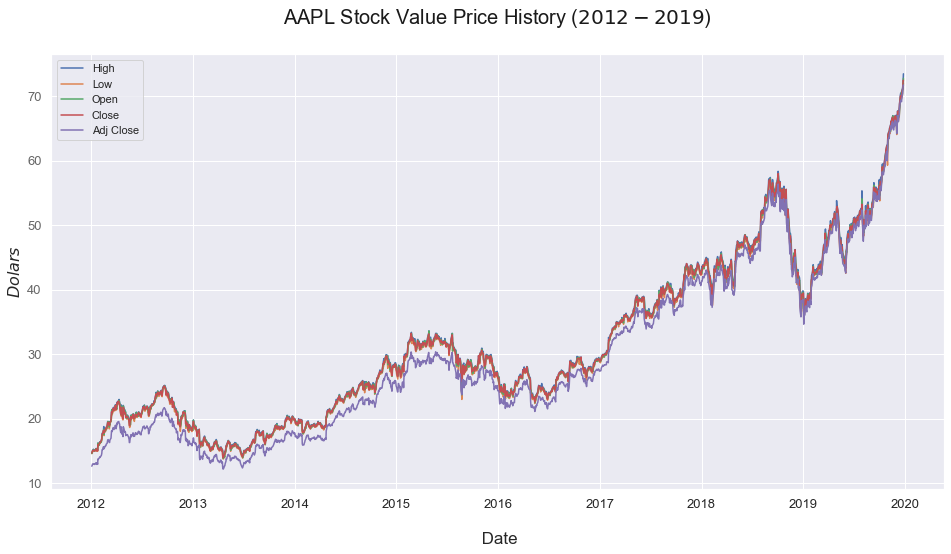

In [4]:
plt.figure(figsize=(16,8))

for col in df.drop(columns="Volume").columns :
    
    plt.plot(df.index, df[col], label = col)
    plt.title("AAPL Stock Value Price History ($2012-2019$) \n", fontsize= 20, color= "k")
    plt.xlabel("\n Date", fontsize= 17)
    plt.ylabel("$Dolars$", fontsize =16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize = 13, alpha=.7)
    plt.legend()

plt.show()

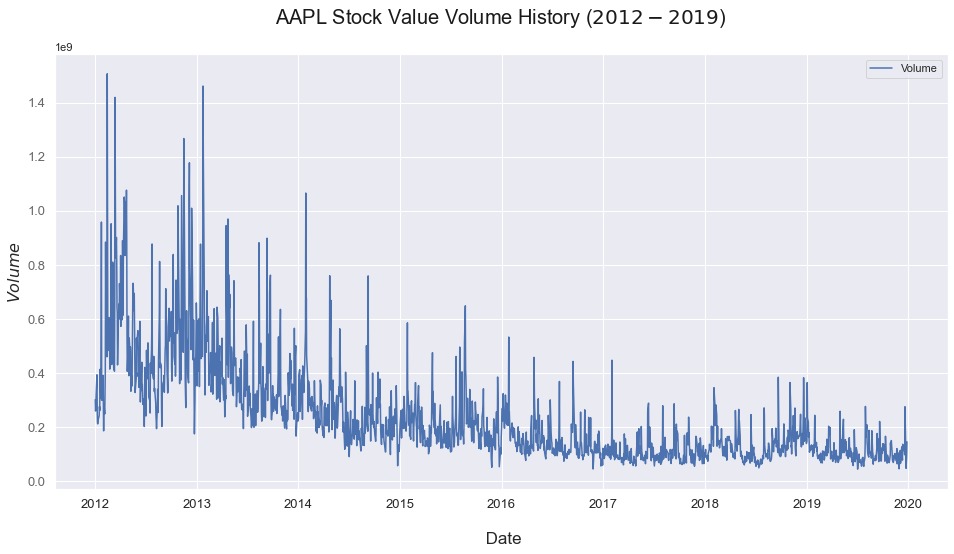

In [5]:
plt.figure(figsize=(16,8))

plt.plot(df.index, df["Volume"], label = "Volume")
plt.title("AAPL Stock Value Volume History ($2012-2019$) \n", fontsize= 20, color= "k")
plt.xlabel("\n Date", fontsize= 17)
plt.ylabel("$Volume$", fontsize =16)
plt.xticks(fontsize=13)
plt.yticks(fontsize = 13, alpha=.7)
plt.legend()

plt.show()

* _*Opte por graficar las variables por separado dado que, al graficarlas todas juntas se plasma en el plot nada mas que `Volume` y las otras 5 variables quedan aplastas en el grafico como una linea recta. Esto es de esperarse dado que `Volume` maneja datos en unidades de millones mientras que las demas se manejan en decenas.*_


**Observaciones:**


* _*Se puede ver, claramente como al pasar los años la cantidad de acciones de **AAPL** que estaban circulando en el mercado disminuyo drasticamente, uno podria decir. Aqui un [debate](https://www.quora.com/Why-is-Apples-stock-trading-volume-dropping) en **Quora** expone algunas ideas de porque este fenomeno se presento.*_

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2010 entries, 2012-01-03 to 2019-12-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2010 non-null   float64
 1   Low        2010 non-null   float64
 2   Open       2010 non-null   float64
 3   Close      2010 non-null   float64
 4   Volume     2010 non-null   float64
 5   Adj Close  2010 non-null   float64
dtypes: float64(6)
memory usage: 109.9 KB


* _*Se observa que ninguna de las variables posee valores faltantes.*_

## Re-ordenando columnas

In [7]:
new_list= ["Volume", "Open", "Low", "High", "Adj Close", "Close"]

df = df.reindex(columns= new_list)

df

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
...                 ...        ...        ...        ...        ...        ...
2019-12-20  275978000.0  70.557503  69.639999  70.662498  69.158508  69.860001
2019-12-23   98572000.0  70.132500  70.092499  71.062500  70.287064  71.000000
2019-12-24   48478800.0  71.172501  70.730003  71.222504  70.353882  71.067497
2019-12-26   93121200.0  71.205002  71.175003  72.495003  71.749733  72.477501
2019-12-27  146266000.0  72.779999  72.029999  73.492500  71.722488  72.449997

[2010 rows x 6 columns]

## Observando valores y correlaciones

In [8]:
df.describe()

Volume         Open          Low         High    Adj Close        Close
count  2.010000e+03  2010.000000  2010.000000  2010.000000  2010.000000  2010.000000
mean   2.380334e+08    31.656624    31.375209    31.936393    29.759350    31.664814
std    1.873892e+08    12.591382    12.502671    12.701485    13.036518    12.614285
min    4.544800e+07    13.856071    13.753571    14.271429    12.191197    13.947500
25%    1.103367e+08    21.459642    21.261697    21.677232    18.700668    21.543124
50%    1.738772e+08    28.256250    27.958751    28.546250    26.217624    28.256250
75%    2.988440e+08    41.242500    40.839999    41.835624    39.859359    41.291251
max    1.506120e+09    72.779999    72.029999    73.492500    71.749733    72.477501

* _*El promedio se mantiene **fijo** tanto en `High`como `Low`. El **valor promedio** de la accion a lo largo de los 7 años observables es de 31-32 dolares.*_

In [9]:
df.corr()

Volume      Open       Low      High  Adj Close     Close
Volume     1.000000 -0.558635 -0.564094 -0.555588  -0.567045 -0.560359
Open      -0.558635  1.000000  0.999717  0.999781   0.998889  0.999493
Low       -0.564094  0.999717  1.000000  0.999656   0.999176  0.999769
High      -0.555588  0.999781  0.999656  1.000000   0.999167  0.999747
Adj Close -0.567045  0.998889  0.999176  0.999167   1.000000  0.999399
Close     -0.560359  0.999493  0.999769  0.999747   0.999399  1.000000

In [10]:
def heatmap(df):
    plt.figure(figsize=(16, 8))

    corr = df.corr()

    sns.heatmap(data=corr, cbar=True, square=True, annot=True,

                fmt='.2f', annot_kws={'size': 13},

                xticklabels=corr.columns, yticklabels=corr.columns,

                cmap='RdBu', center=0)

    plt.title('Correlacion de las variables', pad=16, fontsize= 20, color= "g")
    plt.xticks(rotation=45, fontsize=13)
    plt.yticks(rotation=0, fontsize=13)
    plt.tight_layout()
    plt.show()

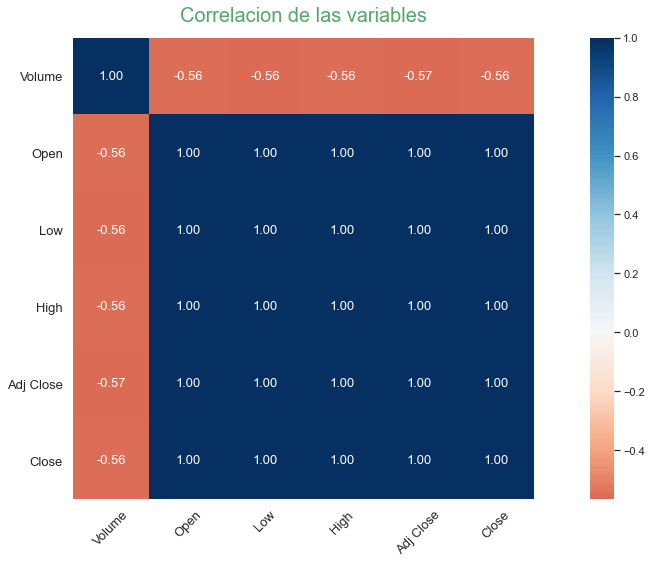

In [11]:
heatmap(df)

* _*Todas las variables aportan, casi en partes iguales, la misma cantidad de informacion a la hora de determinar el precio en el cual va a cerrar la accion(siendo `High`y `Low` las que mas aportan).*_


* _*Se podria considerar que la variable `Volume` no aporta tantos datos a la hora de predecir precio de cierre de la accion. Pero considerando que estamos trabajando con pocos datos(y columnas) voy a trabajar con todo el Dataframe.*_

## Graficando variable objetivo(*Close*)

* _*Al utilizar rolling window estamos tratando de estimar cual es el valor promedio de la variable objetivo en una escala de tiempo igual a la indicada en el parametro **window**.*_


* _*De esta manera podemos saber que el precio promedio de la accion en los 365 dias del año se establecio en un rango no mayor a los 40 dolares. Por otra parte, estimando el promedio de la variable objetivo tomando en cuenta los valores de los ultimos 7 dias observados, obtenemos que el precio promedio de la accion se aproxima mucho al real.*_

In [12]:
rolling_window = df["Close"].rolling(window =365, center = True).mean()
rolling_window1 = df["Close"].rolling(window =7, center = True).mean()

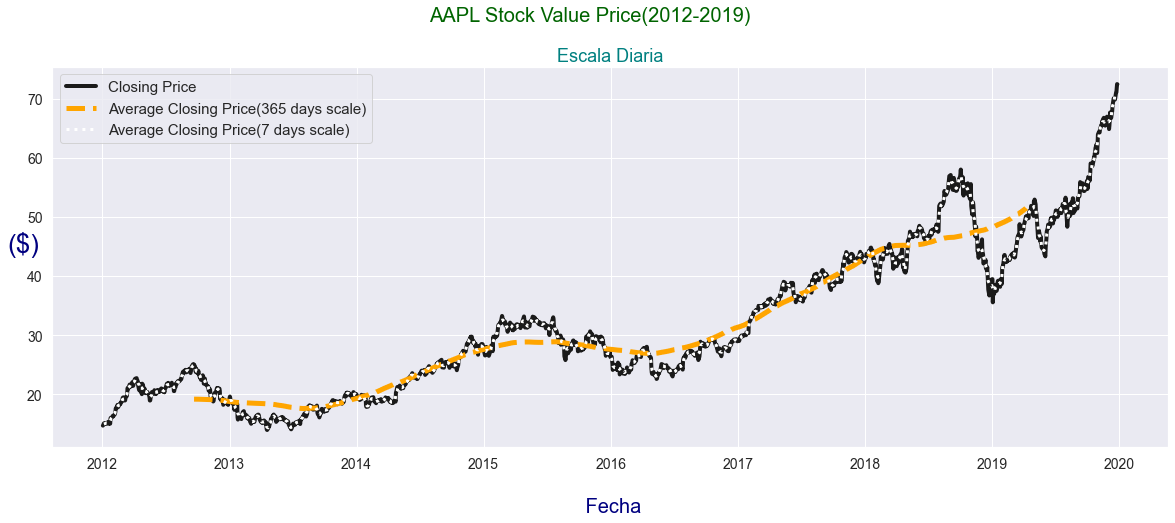

In [13]:
plt.figure(figsize=(20,7))

plt.plot(df.index, df["Close"], label ="Closing Price", color = "k", linewidth =4)
plt.plot(df.index, rolling_window, label ="Average Closing Price(365 days scale)", color="orange", linestyle = "dashed", linewidth = 5) 
plt.plot(df.index, rolling_window1, label ="Average Closing Price(7 days scale)", color="w", linewidth = 3, linestyle = "dotted" )
plt.title("Escala Diaria", fontsize = 18, color = "teal")
plt.suptitle("AAPL Stock Value Price(2012-2019) \n", fontsize= 20, color="darkgreen", y= 1)
plt.xlabel("\n Fecha", fontsize = 20, color = "navy")
plt.xticks(fontsize = 14)
plt.ylabel("($)", fontsize = 26, color = "navy", rotation = 0)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 15)
plt.show()

## **Observaciones a primera vista**

* _*La serie posee una tendencia ascendente muy marcada a lo largo de todo su observacion. Siendo esta considerablemente "estable" en un promedio de 20 a 40 dolares durante los primeros 5 años observados(hasta finales del año 2017) para luego dar saltos en su tendencia de varios dolares ya estableciendose por encima de los 50 dolares de forma permanente a partir del 2019.*_


* _*Si bien uno podria tratar de encontrar cierta estacionalidad en la serie, la misma carece de. Esta es una serie **ciclica** dado que sus patrones no estan repetidos en una secuencia **fija** o **semi-fija** en la escala del tiempo. Una serie con estacionalidad **marcada** presentaria cierta "**repeticion**" en sus valores cada cierto periodo de tiempo. Las series **ciclicas** no presentan esta particularidad sino, por el contrario, se presenta con "subidas y bajadas" completamente **aleatoreas**.*_


* _*Dado que estamos trabajando con un valor observado en el tiempo que se ve influenciado por las finanzas y negocios al mismo tiempo que por varios factores socio-economicos puedo definir a esta misma como una serie **ciclica**.*_



**Conclusiones:**

* _*La serie es apta para modelado. Si bien no posee valores estacionales marcados, es importante tener en cuenta que al estar hablando del valor de una accion a lo largo de los años observados la cual puede ser influeciada por diversos y muchos factores, la misma no **debe** de exhibir estacionalidad. Lo que si se puede observar es que: Dado por especulacion del mercado, factores socio-economicos, el "apoyo de la gente", todas sumadas o ninguna, se observa un claro patron llegado a los finales de año de cada año observado. Este patron es que sin importar el movimiento que haya tenido la accion a lo largo del año, tiende a tener un comportamiento alcista llegado el cierre del ciclo.*_


* _*Dado que estamos trabajando con los valores de X-accion (AAPL) que se encuentran registrados en el tiempo en formato diario no se procedera a estudiar los datos en distintas frecuencias dado que: El valor de una accion se mide **exactamente** con las columnas que posee este Dataframe. Es decir, necesitamos saber cual fue el valor de la accion al final del dia. Ergo, para este tipo de proyecto abarcado los datos registrados en frecuencia **diaria** son el mejor tipo de frecuencia.*_

## Valores Faltantes

In [14]:
df.index.to_series().diff().value_counts()

1 days    1570
3 days     366
4 days      49
2 days      23
5 days       1
Name: Date, dtype: int64

* _*Esta funcion devuelve la diferencia de dias entre registro y registro. Es decir:*_

   * Diferencia de **1 dia** en el registro hay **1570 instancias**.
   * Diferencia de **2 dias** en el registro hay **23 instancias**.
   * Diferencia de **3 dias** en el registro hay **366 instancias**.
   * Diferencia de **4 dias** en el registro hay **49 instancias**.
   * Diferencia de **5 dias** en el registro hay **1 instancia**.
   


_*Si sumamos todos estos valores deberia de dar **2010**.*_ 

In [15]:
1570+23+366+49+1

2009

° *En realidad deberia de dar 2920(365 dias al año x 8 años observados) asumiendo que La Bolsa de Valores trabaja todo el año (algo que sabemos que no es asi).*

° *Devuelve 1 instancia de menos dado que la funcion evalua la diferencia en el registro de las fechas tomando como punto de salida la fecha anterior. Dado que la primer fecha es la primera, no existe fecha anterior para evaluar alguna diferencia en el registro de las mismas*.

_*La **Bolsa de Valores** se encuentra abierta aproximadamente [252 dias](https://www.macroption.com/trading-days-per-year/) / [253 dias](https://www.google.com/search?q=how+many+days+a+year+does+de+stock+market+it%27s+opne&oq=how+many+days+a+year+does+de+stock+market+it%27s+opne&aqs=chrome..69i57.27461j0j1&sourceid=chrome&ie=UTF-8) al año. De echo:*_

   * Año 2012 : 250   (Cerrado 2 dias extra por el [Huracan Sandy](https://es.wikipedia.org/wiki/Hurac%C3%A1n_Sandy))
   * Año 2013 : 252
   * Año 2014 : 252
   * Año 2015 : 252
   * Año 2016 : 252
   * Año 2017 : 251
   * Año 2018 : 251
   * Año 2019 : 252
   
   
   
   * 8 Años observados = 2012 dias
   
_*Si se corrigen ciertos registros (como el que presenta una diferencia de 5 dias entre registro y registro) estoy seguro que 2012 seria el numero final de registros totales.*_

**Conclusion:**

* _*La serie no presenta valores faltantes. Todos los dias trabajados en los 8 años observados en La Bolsa de Valores se encuentran correctamente registrados en el Dataframe.*_

## Valores Atipicos

* _*A simple vista la serie no parece poseer valores atipicos. Para un estudio mas detallado graficare los años uno por uno esperando asi ver si es que hay algun patron atipico poder indentificarlo.*_

In [16]:
df1, df2 =  df.copy(), df.copy()

In [17]:
df1["Year"] = [d.year for d in df.index]

df1["Month"] = [d.strftime('%b') for d in df.index]

years = df1["Year"].unique()

In [18]:
df1

Volume       Open        Low       High  Adj Close      Close  Year Month
Date                                                                                      
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786  2012   Jan
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714  2012   Jan
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643  2012   Jan
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714  2012   Jan
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786  2012   Jan
...                 ...        ...        ...        ...        ...        ...   ...   ...
2019-12-20  275978000.0  70.557503  69.639999  70.662498  69.158508  69.860001  2019   Dec
2019-12-23   98572000.0  70.132500  70.092499  71.062500  70.287064  71.000000  2019   Dec
2019-12-24   48478800.0  71.172501  70.730003  71.222504  70.353882  71.067497  2019   Dec
2019-12-26   93121200.0  71.205002  71.175003  72.495003  71.749733  72.477501  2019   Dec
2019-12-27  146266000.0  72.779999  72.029999  73.492500  71.722488  72.449997  2019   Dec

[2010 rows x 8 columns]

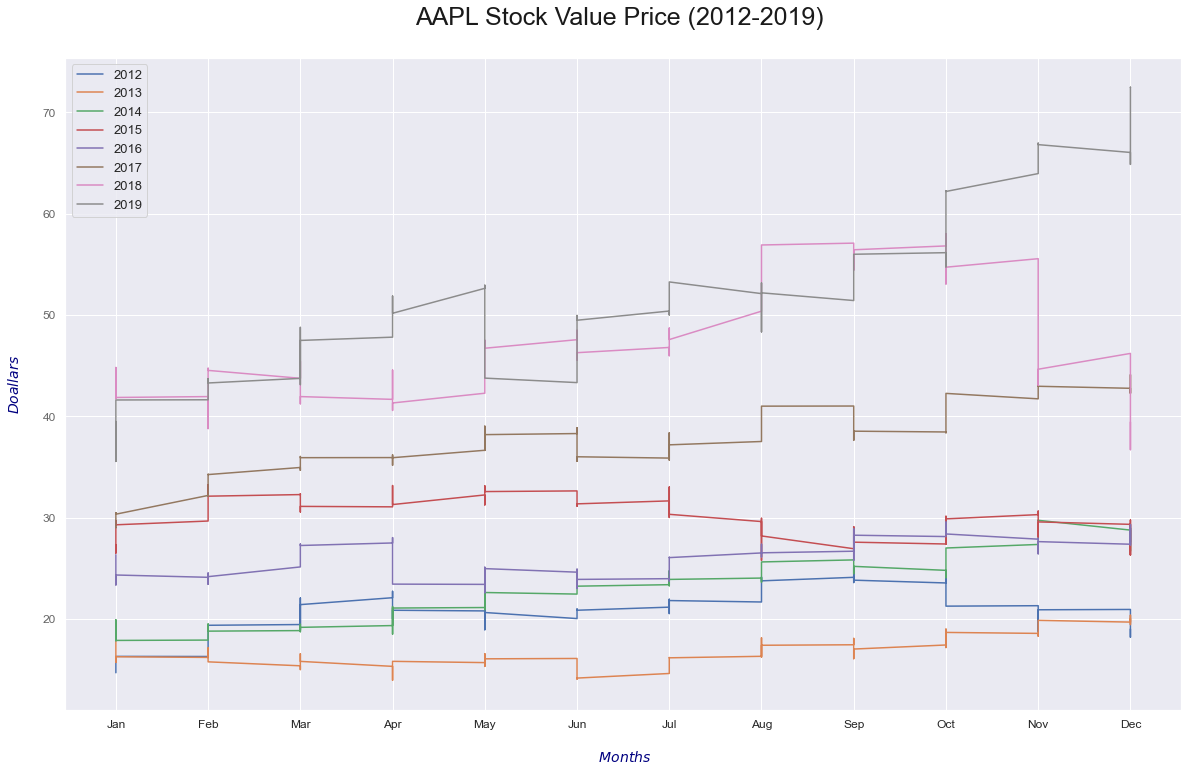

In [19]:
plt.figure(figsize=(20,12))

for i in years :
    
    plt.plot("Month", "Close", data = df1.loc[df1.Year == i], label= i)

    
plt.title("AAPL Stock Value Price (2012-2019) \n", fontsize = 25, color = "k")
plt.xlabel("\n $Months$", fontsize = 14, color="navy")
plt.xticks(fontsize = 12)
plt.ylabel("$Doallars$ \n", fontsize= 14, color="navy")
plt.yticks(fontsize=12, alpha=.7)
plt.legend(fontsize = 13)   
plt.show()

* _*En una observacion mas detallada por años, se observa que:*_

   * El año 2012 fue el año en el que el precio de la accion cerro en su valor mas bajo.
   * El año 2013 fue el peor año en el cual estuvo cotizando la accion 'AAPL'(Su precio no supero los 20 dolares).
   * Los años 2014, 2015 y 2017 representan (a simple vista) los años con mayor crecimiento en contraste con el año anterior.
   * El año 2016 no parece haber sido un buen año para la cotizacion de la accion.
   * Luego del año 2017 el precio de la accion se establace firmemente por encima de los 40 dolares aun que presentan fluctuaciones fuertes en su cotizacion.
   
   
   El valor de la accion siempre se ve muy sujeto al factor socio-economico "fin de año" en el cual se puede observar como el precio tiende a establecerse, *generalmente*, por del precio en su *corrida* anual a **excepcion** del año 2019 el cual claramente fue el mejor año en la corrida de la accion.

In [20]:
def iqr_calc(df,var):
    
    df_empty = pd.DataFrame()
    
    for col in var:
    
        
        q25 = int(np.nanquantile(df[col], 0.25))
        q75 = int(np.nanquantile(df[col], 0.75))
        iqr = q75 - q25
        minimo = abs(q25 - (iqr*1.5))
        maximo = abs(q75 + (iqr*1.5))

        df_iqr = pd.DataFrame({'Minimo':[minimo],
                                'Maximo':[maximo],
                                'IQR':[iqr],
                                'Q25':[q25],
                                'Q75':[q75]},
                                index=[col])
        
        df_empty = pd.concat([df_empty, df_iqr])
        
    return df_empty

In [21]:
def iqr_remove(df,var):
    
    Q1 = np.nanquantile(df[var], 0.25)
    Q3 = np.nanquantile(df[var], 0.75)
    IQR = Q3 - Q1
    q_min = Q1 - (IQR*1.5)
    q_max = Q3 + (IQR*1.5)
    
    return df[~((df[var] < q_min) | (df[var] > q_max))]

In [22]:
def tres_sigma_calc(df,var):
    
    df_empty = pd.DataFrame()
    
    for col in var:
    
        
        sigma_minimo= abs(int(df[col].mean() - (3 * df[col].std())))
        sigma_maximo= abs(int(df[col].mean() + (3 * df[col].std())))
        
        df_3_sigmas = pd.DataFrame({'Umbral Minimo':[sigma_minimo],
                                    'Umbral Maximo':[sigma_maximo]},
                                   index=[col])
        
        df_empty = pd.concat([df_empty, df_3_sigmas])
        
    return df_empty

In [23]:
def tres_sigma_remove(df,var):
    
    sigma_minimo= df[var].mean() - (3 * df[var].std())
    sigma_maximo= df[var].mean() + (3 * df[var].std())
    
    return df[~((df[var] < sigma_minimo) | (df[var] > sigma_maximo))]

In [24]:
var = [col for col in df.columns]
var

['Volume', 'Open', 'Low', 'High', 'Adj Close', 'Close']

In [25]:
iqr_calc(df,var)

Minimo       Maximo        IQR        Q25        Q75
Volume     172424250.0  581604950.0  188507300  110336700  298844000
Open               9.0         71.0         20         21         41
Low                7.5         68.5         19         21         40
High               9.0         71.0         20         21         41
Adj Close         13.5         70.5         21         18         39
Close              9.0         71.0         20         21         41

In [26]:
tres_sigma_calc(df,var)

Umbral Minimo  Umbral Maximo
Volume         324134335      800201112
Open                   6             69
Low                    6             68
High                   6             70
Adj Close              9             68
Close                  6             69

In [27]:
for var in df1.drop(columns= ["Year","Month"]):
    df1= iqr_remove(df1,var)

In [28]:
for var in df2 : 
    df2 = tres_sigma_remove(df2,var)

In [29]:
print("Dataframe Original: ", df.shape)
print("Dataframe curado de Valores Atipicos con IQR: ", df1.shape)
print("Dataframe curado de Valores Atipicos con 3-Sigma: ", df2.shape)

Dataframe Original:  (2010, 6)
Dataframe curado de Valores Atipicos con IQR:  (1881, 8)
Dataframe curado de Valores Atipicos con 3-Sigma:  (1958, 6)


**Conclusion**

* _*Dada la poca cantidad de informacion que poseemos, y teniendo en cuenta que se trata de datos registrados por NASDAQ se concluye que la serie de tiempo estudiada no presenta Valoes Atipicos **y** que aplicar limpieza a travez de IQR o 3-Sigmas no es ni viable ni necesario.*_

## Autocorrelaciones

* _*Graficando las autocorrelaciones de los 8 años observados.*_

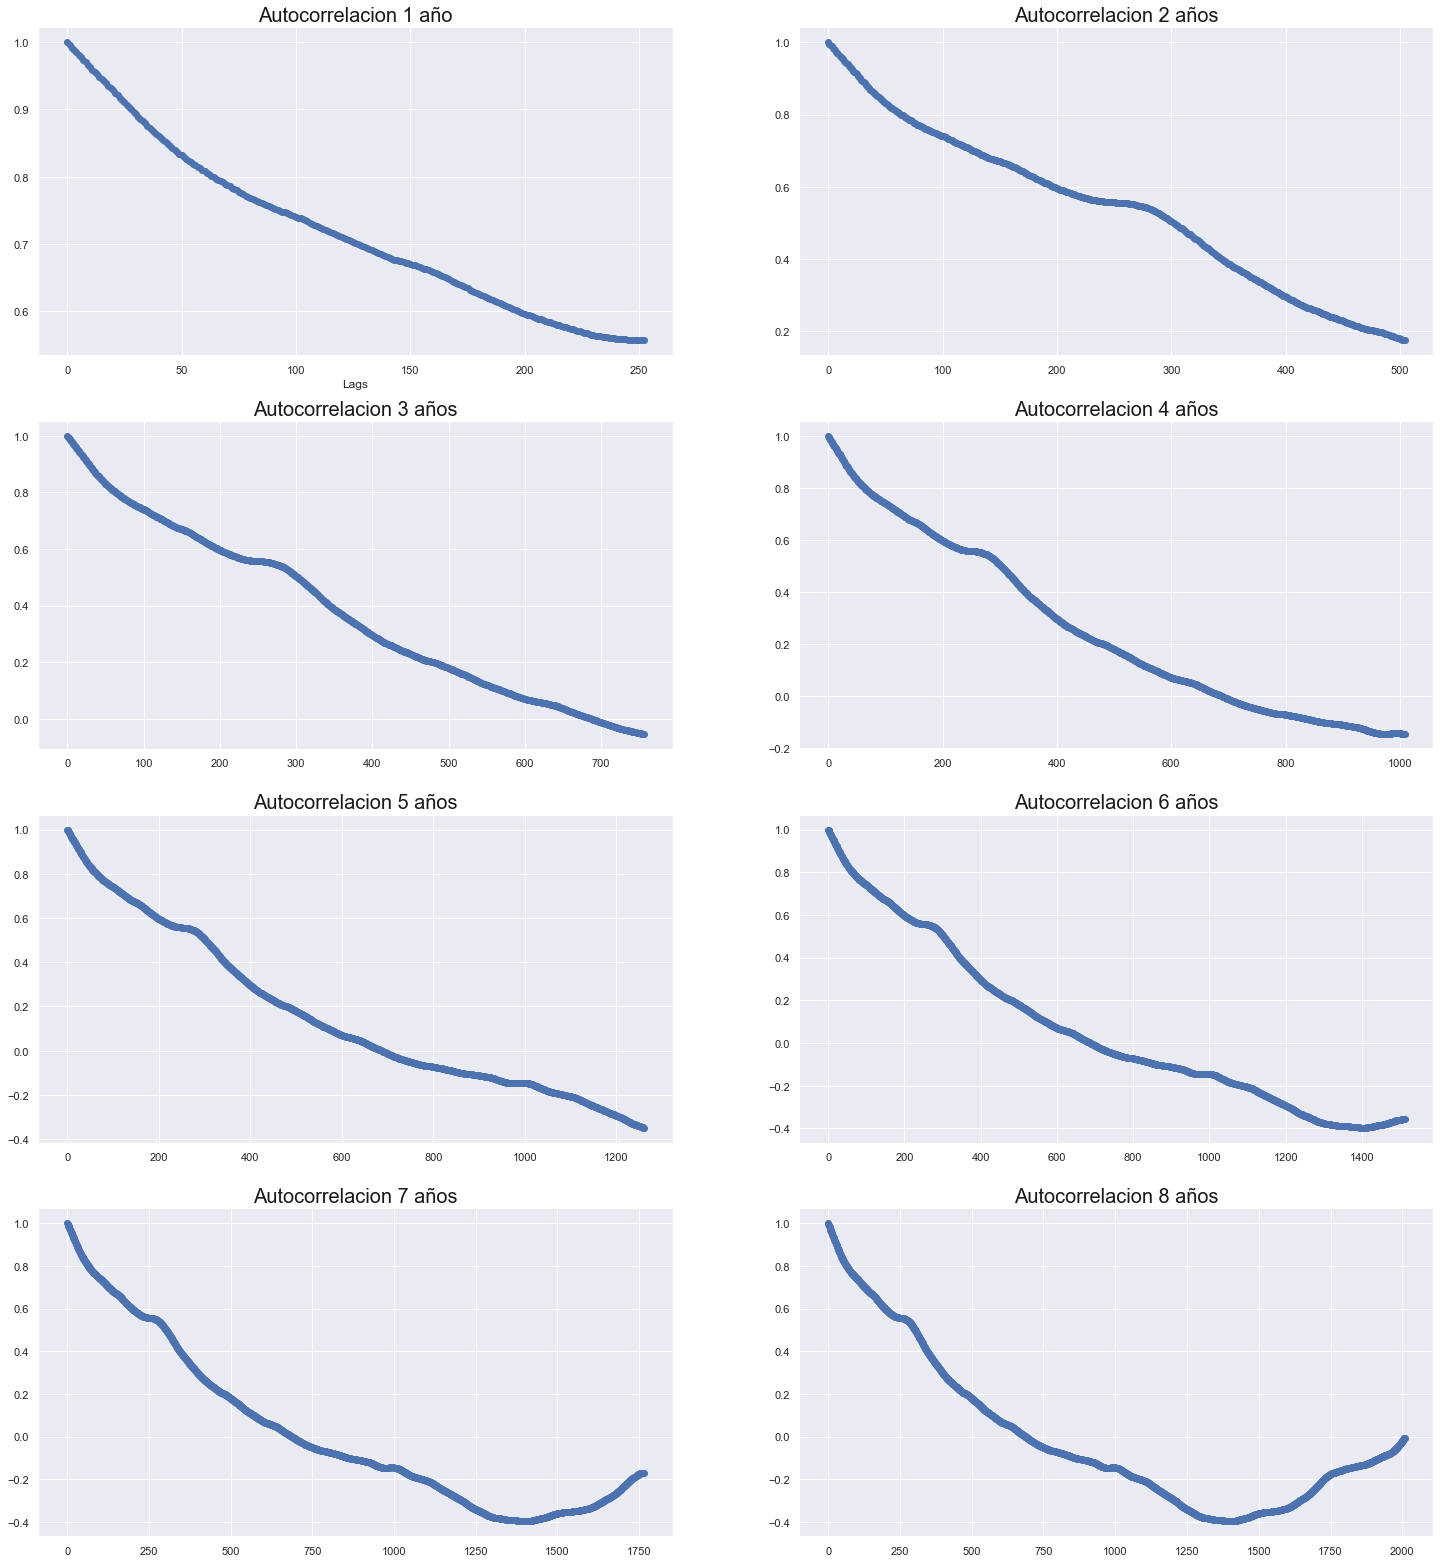

In [30]:
plt.figure(figsize= (25,35))

Gs= gs.GridSpec(5,2)

ax0 = plt.subplot(Gs[0])
nlags = 252
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel("Lags")
plt.title("Autocorrelacion 1 año", fontsize=20, color="k" )

ax1 = plt.subplot(Gs[1])
nlags = 252 * 2
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 2 años", fontsize=20, color="k" )

ax2 = plt.subplot(Gs[2])
nlags = 252 * 3
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 3 años", fontsize=20, color="k" )

ax3 = plt.subplot(Gs[3])
nlags = 252 * 4
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 4 años", fontsize=20, color="k" )

ax4 = plt.subplot(Gs[4])
nlags = 252 * 5
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 5 años", fontsize=20, color="k" )

ax5 = plt.subplot(Gs[5])
nlags = 252 * 6
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 6 años", fontsize=20, color="k" )

ax6 = plt.subplot(Gs[6])
nlags = 252 * 7
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 7 años", fontsize=20, color="k" )

ax7 = plt.subplot(Gs[7])
nlags = 251 * 8
autocorr= stattools.acf(df["Close"], nlags= nlags)
plt.scatter(np.arange(nlags+1), autocorr)
plt.title("Autocorrelacion 8 años", fontsize=20, color="k" )

plt.show()

### *Correlograma*

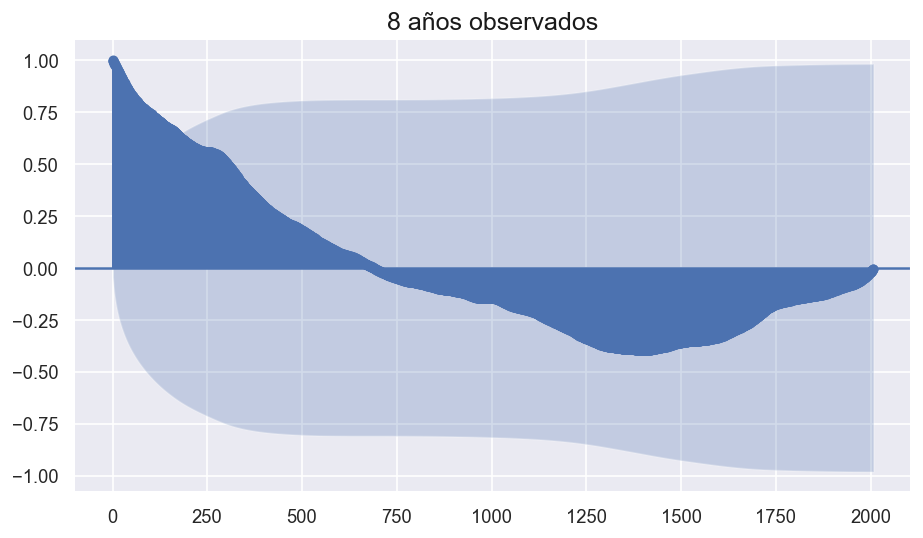

In [31]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

plot_acf(df["Close"], lags = np.arange(251*8))
plt.title("8 años observados", fontsize=15, color = "k")

plt.show()

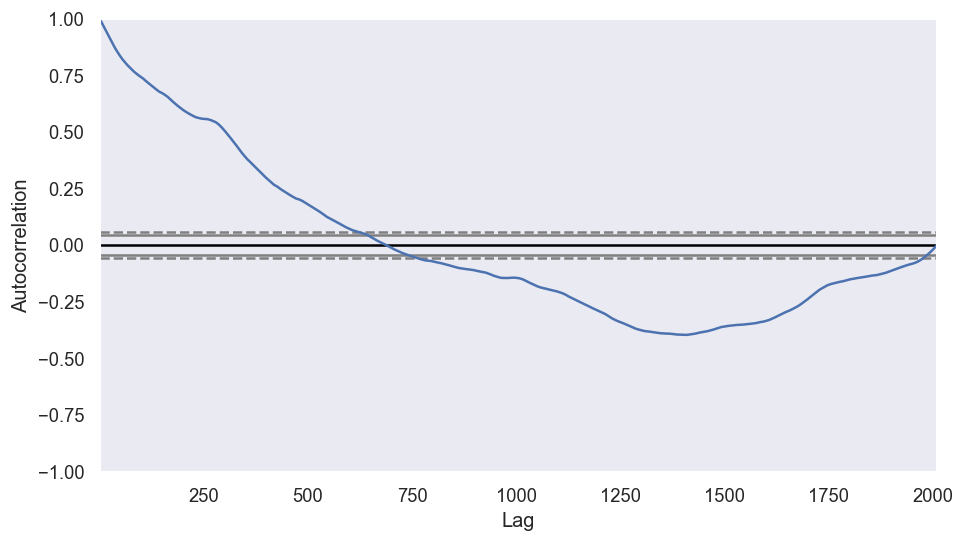

In [32]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.Close)

plt.show()

**Observaciones:**


* _*Se observa como la serie pierde mucha autocorrelacion con el pasar del tiempo, de echo la misma se vuelve negativa(es entendible dado que a partir del 3 año observado al 6 los valores de la accion fluctuan mucho) luego de ciertos años observados.*_


* _*Llegando a los ultimos años observados (2018 y 2019) se observa como la autocorrelacion de la serie empieza a cambiar su tendencia y toma un comportamiento mas positivo.*_


* _*El correlograma devuelve una estimacion parcial sobre los datos que mayor importancia poseen a la hora de predecir un evento. En el ultimo grafico podemos ver que son los primeros años observados los que mayor importancia poseen (dado que son los valores que uno quisiera predecir pero no sabe cual seria el resultado, **por fuera del sombreado azul**, los que mayor importancia agregan a la prediccion).*_

## Descomponiendo la serie

### Asignando frecuencia a la serie*

* _*Al querer descomponer la serie, si se le pasa el Dataframe **asi como esta** a la funcion seasonal_decompose esta devolveria un error dado que nuestros datos se encuentran en **freq = None** cuando observamos el formato de datos y como estan instanciados del indice.*_

In [33]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13', '2012-01-17',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27'], dtype='datetime64[ns]', name='Date', length=2010, freq=None)

* _*Para solucionar este problema, se utiliza la funcion **asfreq** que asigna la frecuencia deseada al indice.*_

In [34]:
df0 = df.asfreq("D")

In [35]:
df0.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27'], dtype='datetime64[ns]', name='Date', length=2916, freq='D')

* _*El problema con este tipo de enfoque es que, ahora nuestro Dataframe posee mas filas con valores faltantes (Nan). Esto se da al corregir la frecuencia. La misma funcion rellena los espacios vacios en las fechas y a los valores les asigna NaN.*_

In [36]:
df0.shape

(2916, 6)

In [37]:
df0.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-08          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

* _*Para corregir este error se utiliza la funciona **dropna** y removemos todas las entradas con valores Nan.*_

In [38]:
df0.isna().sum()

Volume       906
Open         906
Low          906
High         906
Adj Close    906
Close        906
dtype: int64

In [39]:
df0.dropna(inplace=True)

In [40]:
df0.isna().sum()

Volume       0
Open         0
Low          0
High         0
Adj Close    0
Close        0
dtype: int64

In [41]:
df0.shape

(2010, 6)

In [42]:
df0.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643
2012-01-13  226021600.0  14.989286  14.952143  15.016071  12.914607  14.993214
2012-01-17  242897200.0  15.150000  15.105714  15.213929  13.065036  15.167857

In [43]:
df0.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13', '2012-01-17',
               ...
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27'], dtype='datetime64[ns]', name='Date', length=2010, freq=None)

* _*El problema persiste dado que:*_
   
   * _*La funcion seasonal.seasonal_decompose no puede operar sin Freq, que es lo que pasa cuando quitamos los valores nulos. Pierde la relacion en la frecuncia.*_
   * _*La funcion seasonal.seasonal_decompose no toma valores nulos en su funcion, que es el primer problema que se presenta para solucionar el problema original.*_


* _*Para solucionar este problema, se asinga la frecuencia, se dejan los valores nulos, se estudia el mejor metodo de interpolacion y se interpolan los valores nulos.*_

In [44]:
df0.shape

(2010, 6)

In [45]:
df0 = df.asfreq("D")

In [46]:
df0.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27'], dtype='datetime64[ns]', name='Date', length=2916, freq='D')

In [47]:
df0.shape

(2916, 6)

### Interpolando valores atipicos

In [48]:
df1, df2, df3 = df0.copy(), df0.copy(), df0.copy()

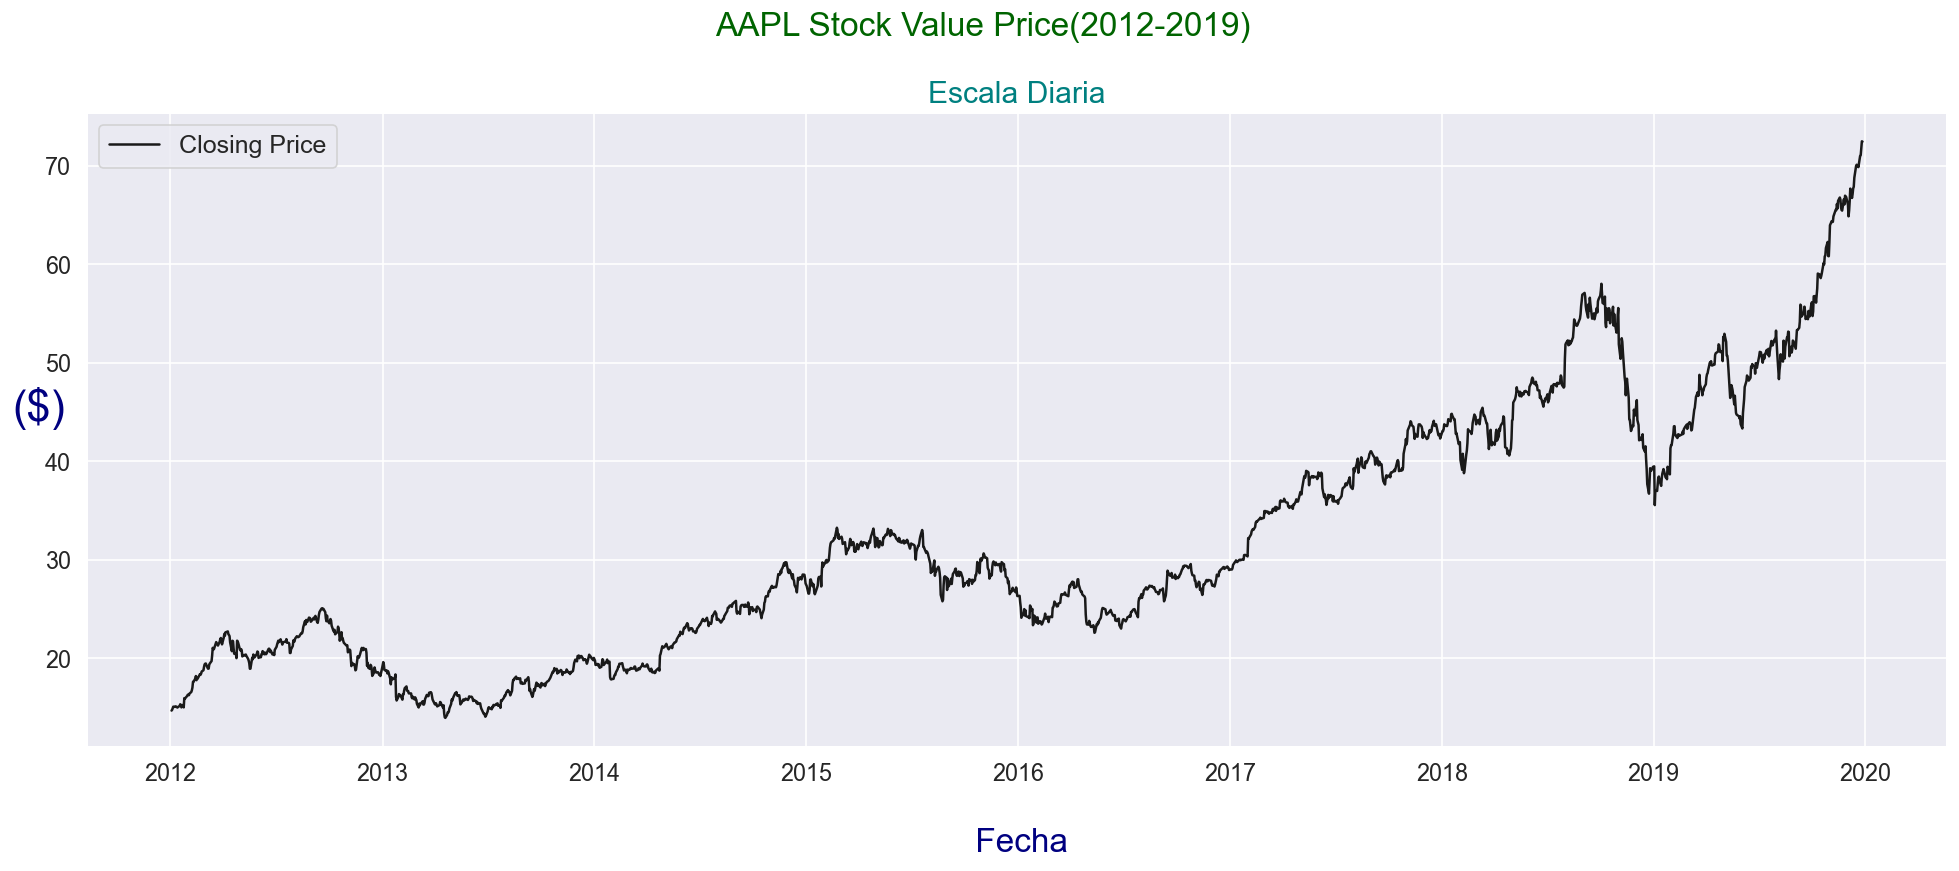

In [49]:
plt.figure(figsize=(20,7))

plt.plot(df.index, df["Close"], label ="Closing Price", color = "k")
plt.title("Escala Diaria", fontsize = 18, color = "teal")
plt.suptitle("AAPL Stock Value Price(2012-2019) \n", fontsize= 20, color="darkgreen", y= 1)
plt.xlabel("\n Fecha", fontsize = 20, color = "navy")
plt.xticks(fontsize = 14)
plt.ylabel("($)", fontsize = 26, color = "navy", rotation = 0)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 15)
plt.show()

In [50]:
df0.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-08          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

#### _*Metodo Linear(deafult)*_

In [51]:
print(df0.shape)

print(df0.isna().sum())

df0= df0.interpolate()

print(df0.isna().sum())

(2916, 6)
Volume       906
Open         906
Low          906
High         906
Adj Close    906
Close        906
dtype: int64
Volume       0
Open         0
Low          0
High         0
Adj Close    0
Close        0
dtype: int64


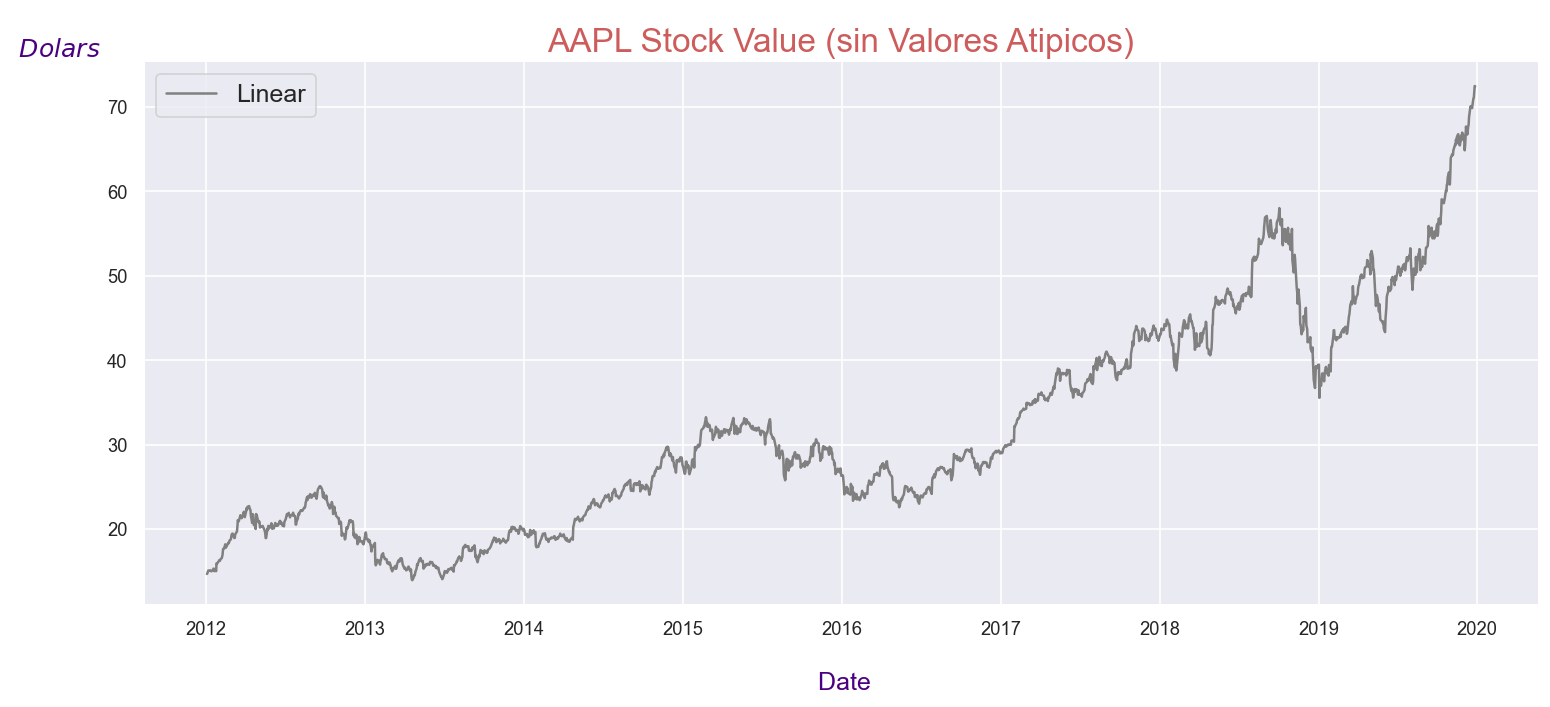

In [52]:
plt.figure(figsize = (15,6))

plt.plot(df0.index, df0.Close, label= "Linear", color= "grey")
plt.title("AAPL Stock Value (sin Valores Atipicos)", color= 'indianred', fontsize= 20)
plt.xlabel('\n Date', color= 'indigo', fontsize= 15)
plt.ylabel('\n $Dolars$', color= 'indigo', fontsize= 15, loc='top', rotation=0)
plt.legend(fontsize= 15)

plt.show()

In [53]:
df0.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                           
2012-01-03  3.022208e+08  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  2.600220e+08  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  2.712696e+08  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  3.182928e+08  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07  3.435367e+08  15.060000  14.997500  15.157738  12.987414  15.077738
2012-01-08  3.687805e+08  15.128215  15.022857  15.217262  12.980544  15.069762
2012-01-09  3.940244e+08  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  2.581964e+08  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  2.150848e+08  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  2.125872e+08  15.081429  14.955357  15.103571  12.963211  15.049643

* _*Como los Valores Atipicos en esta serie de tiempo se presentan en formato NaN despues de haber incluido **freq** en nuestra serie, en el grafico no se va a notar ninguna diferencia dado que plot no grafica valores nulos. De esta forma la unica forma de comparar cual fue el mejor metodo de interpolacion de los valores, asumo, seria observando la correlacion  de los Dataframes luego de ser interpolados y ver cual guarda mayor importancia con nuestra variable objetivo.*_

#### _Metodo *'Spline'*_

In [54]:
df1.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-08          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

In [55]:
print(df1.shape)

print(df1.isna().sum())

df1= df1.interpolate(method='spline', order=2)

print(df1.isna().sum())

(2916, 6)
Volume       906
Open         906
Low          906
High         906
Adj Close    906
Close        906
dtype: int64
Volume       0
Open         0
Low          0
High         0
Adj Close    0
Close        0
dtype: int64


In [56]:
df1.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                           
2012-01-03  3.022208e+08  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  2.600220e+08  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  2.712696e+08  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  3.182928e+08  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07  3.812399e+08  13.570850  13.524119  13.627869  11.723849  13.576070
2012-01-08  4.403031e+08  13.747033  13.696251  13.808445  11.875535  13.754118
2012-01-09  3.940244e+08  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  2.581964e+08  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  2.150848e+08  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  2.125872e+08  15.081429  14.955357  15.103571  12.963211  15.049643

#### _*Metodo 'Nearest'*_

In [57]:
df2.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-08          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

In [58]:
print(df2.shape)

print(df2.isna().sum())

df2= df2.interpolate(method='nearest', k=4)

print(df2.isna().sum())

(2916, 6)
Volume       906
Open         906
Low          906
High         906
Adj Close    906
Close        906
dtype: int64
Volume       0
Open         0
Low          0
High         0
Adj Close    0
Close        0
dtype: int64


In [59]:
df2.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-08  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

#### _*Metodo Time*_

In [60]:
df3.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                          
2012-01-03  302220800.0  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  260022000.0  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  271269600.0  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  318292800.0  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-08          NaN        NaN        NaN        NaN        NaN        NaN
2012-01-09  394024400.0  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  258196400.0  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  215084800.0  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  212587200.0  15.081429  14.955357  15.103571  12.963211  15.049643

In [61]:
print(df3.shape)

print(df3.isna().sum())

df3= df3.interpolate(method='time')

print(df3.isna().sum())

(2916, 6)
Volume       906
Open         906
Low          906
High         906
Adj Close    906
Close        906
dtype: int64
Volume       0
Open         0
Low          0
High         0
Adj Close    0
Close        0
dtype: int64


In [62]:
df3.head(10)

Volume       Open        Low       High  Adj Close      Close
Date                                                                           
2012-01-03  3.022208e+08  14.621429  14.607143  14.732143  12.650659  14.686786
2012-01-04  2.600220e+08  14.642857  14.617143  14.810000  12.718646  14.765714
2012-01-05  2.712696e+08  14.819643  14.738214  14.948214  12.859850  14.929643
2012-01-06  3.182928e+08  14.991786  14.972143  15.098214  12.994284  15.085714
2012-01-07  3.435367e+08  15.060000  14.997500  15.157738  12.987414  15.077738
2012-01-08  3.687805e+08  15.128215  15.022857  15.217262  12.980544  15.069762
2012-01-09  3.940244e+08  15.196429  15.048214  15.276786  12.973674  15.061786
2012-01-10  2.581964e+08  15.211071  15.053571  15.214286  13.020121  15.115714
2012-01-11  2.150848e+08  15.095714  14.975357  15.101786  12.998899  15.091071
2012-01-12  2.125872e+08  15.081429  14.955357  15.103571  12.963211  15.049643

#### _*Observando correlaciones*_

In [63]:
df0.corr()

Volume      Open       Low      High  Adj Close     Close
Volume     1.000000 -0.565860 -0.571194 -0.562905  -0.574342 -0.567433
Open      -0.565860  1.000000  0.999743  0.999809   0.998961  0.999566
Low       -0.571194  0.999743  1.000000  0.999678   0.999209  0.999803
High      -0.562905  0.999809  0.999678  1.000000   0.999191  0.999772
Adj Close -0.574342  0.998961  0.999209  0.999191   1.000000  0.999395
Close     -0.567433  0.999566  0.999803  0.999772   0.999395  1.000000

In [64]:
df1.corr()

Volume      Open       Low      High  Adj Close     Close
Volume     1.000000 -0.546594 -0.550982 -0.544043  -0.554560 -0.548030
Open      -0.546594  1.000000  0.999753  0.999791   0.998918  0.999605
Low       -0.550982  0.999753  1.000000  0.999643   0.999118  0.999766
High      -0.544043  0.999791  0.999643  1.000000   0.999104  0.999745
Adj Close -0.554560  0.998918  0.999118  0.999104   1.000000  0.999308
Close     -0.548030  0.999605  0.999766  0.999745   0.999308  1.000000

In [65]:
df2.corr()

Volume      Open       Low      High  Adj Close     Close
Volume     1.000000 -0.560215 -0.565773 -0.557190  -0.568711 -0.561896
Open      -0.560215  1.000000  0.999714  0.999780   0.998900  0.999497
Low       -0.565773  0.999714  1.000000  0.999653   0.999186  0.999776
High      -0.557190  0.999780  0.999653  1.000000   0.999168  0.999745
Adj Close -0.568711  0.998900  0.999186  0.999168   1.000000  0.999394
Close     -0.561896  0.999497  0.999776  0.999745   0.999394  1.000000

In [66]:
df3.corr()

Volume      Open       Low      High  Adj Close     Close
Volume     1.000000 -0.565860 -0.571194 -0.562905  -0.574342 -0.567433
Open      -0.565860  1.000000  0.999743  0.999809   0.998961  0.999566
Low       -0.571194  0.999743  1.000000  0.999678   0.999209  0.999803
High      -0.562905  0.999809  0.999678  1.000000   0.999191  0.999772
Adj Close -0.574342  0.998961  0.999209  0.999191   1.000000  0.999395
Close     -0.567433  0.999566  0.999803  0.999772   0.999395  1.000000

* _*A simple vista, o con una correlacion no se puede apreciar mucha diferencia en los valores que exhibe la primer correlacion del Dataframe en contraste con las correlaciones observadas de los Dataframes luego de interpolar sus valores atipicos.*_


* _*La diferencia se encuentra en que:*_

  * Metodo de interpolacion °*Linear* y °*Spiline* trabjan en distinta manera sobre los datos. Para asingar un valor a los valores nulos a interpolar utilizan ecuaciones mas complejas que otorgan mejores resultados.
  
  * Metodo de interpolacion *Nearest* y *Time* , parece ser, que simplemente toman como referencia el dia anterior y el dia siguiente a los valores nulos trabajados y repitan los valores de estos en ese mismo orden. 
  
  
**Conclusion:**


* _*Habiendo encontrado esta informacion/patrones de conducta, decido elegir el metodo **Linear(default)** como el mejor metodo para interpolar los valores nulos generados al asignarle una frecuencia a la serie de tiempo.*_

*Extra*

> °*Linear* : El metodo de interpolacion Linear es un poco mas simple en su ejecucion. Toma los ultimos 2 puntos conocidos entre NaN y NaN y estima el valor promedio que mejor se adapte a la situacion. Como el nombre lo indica, es una sustitucion "lineal" de los valores faltantes entre 2 puntos de informacion conocidos.


> °*Spiline*: El metodo de interpolacion Spiline utiliza polinomios de bajo grado para cada uno de los intervalos (valores faltantes) y elige la combinacion de polinomios que mejore se adapte a la serie.

#### _*Seasonal Decompose*_

In [67]:
decomp_diaria_add = tsa.seasonal.seasonal_decompose(df0.Close, model='additive',extrapolate_trend='freq')
decomp_diaria_mltp = tsa.seasonal.seasonal_decompose(df0.Close, model='multiplicative',extrapolate_trend='freq')

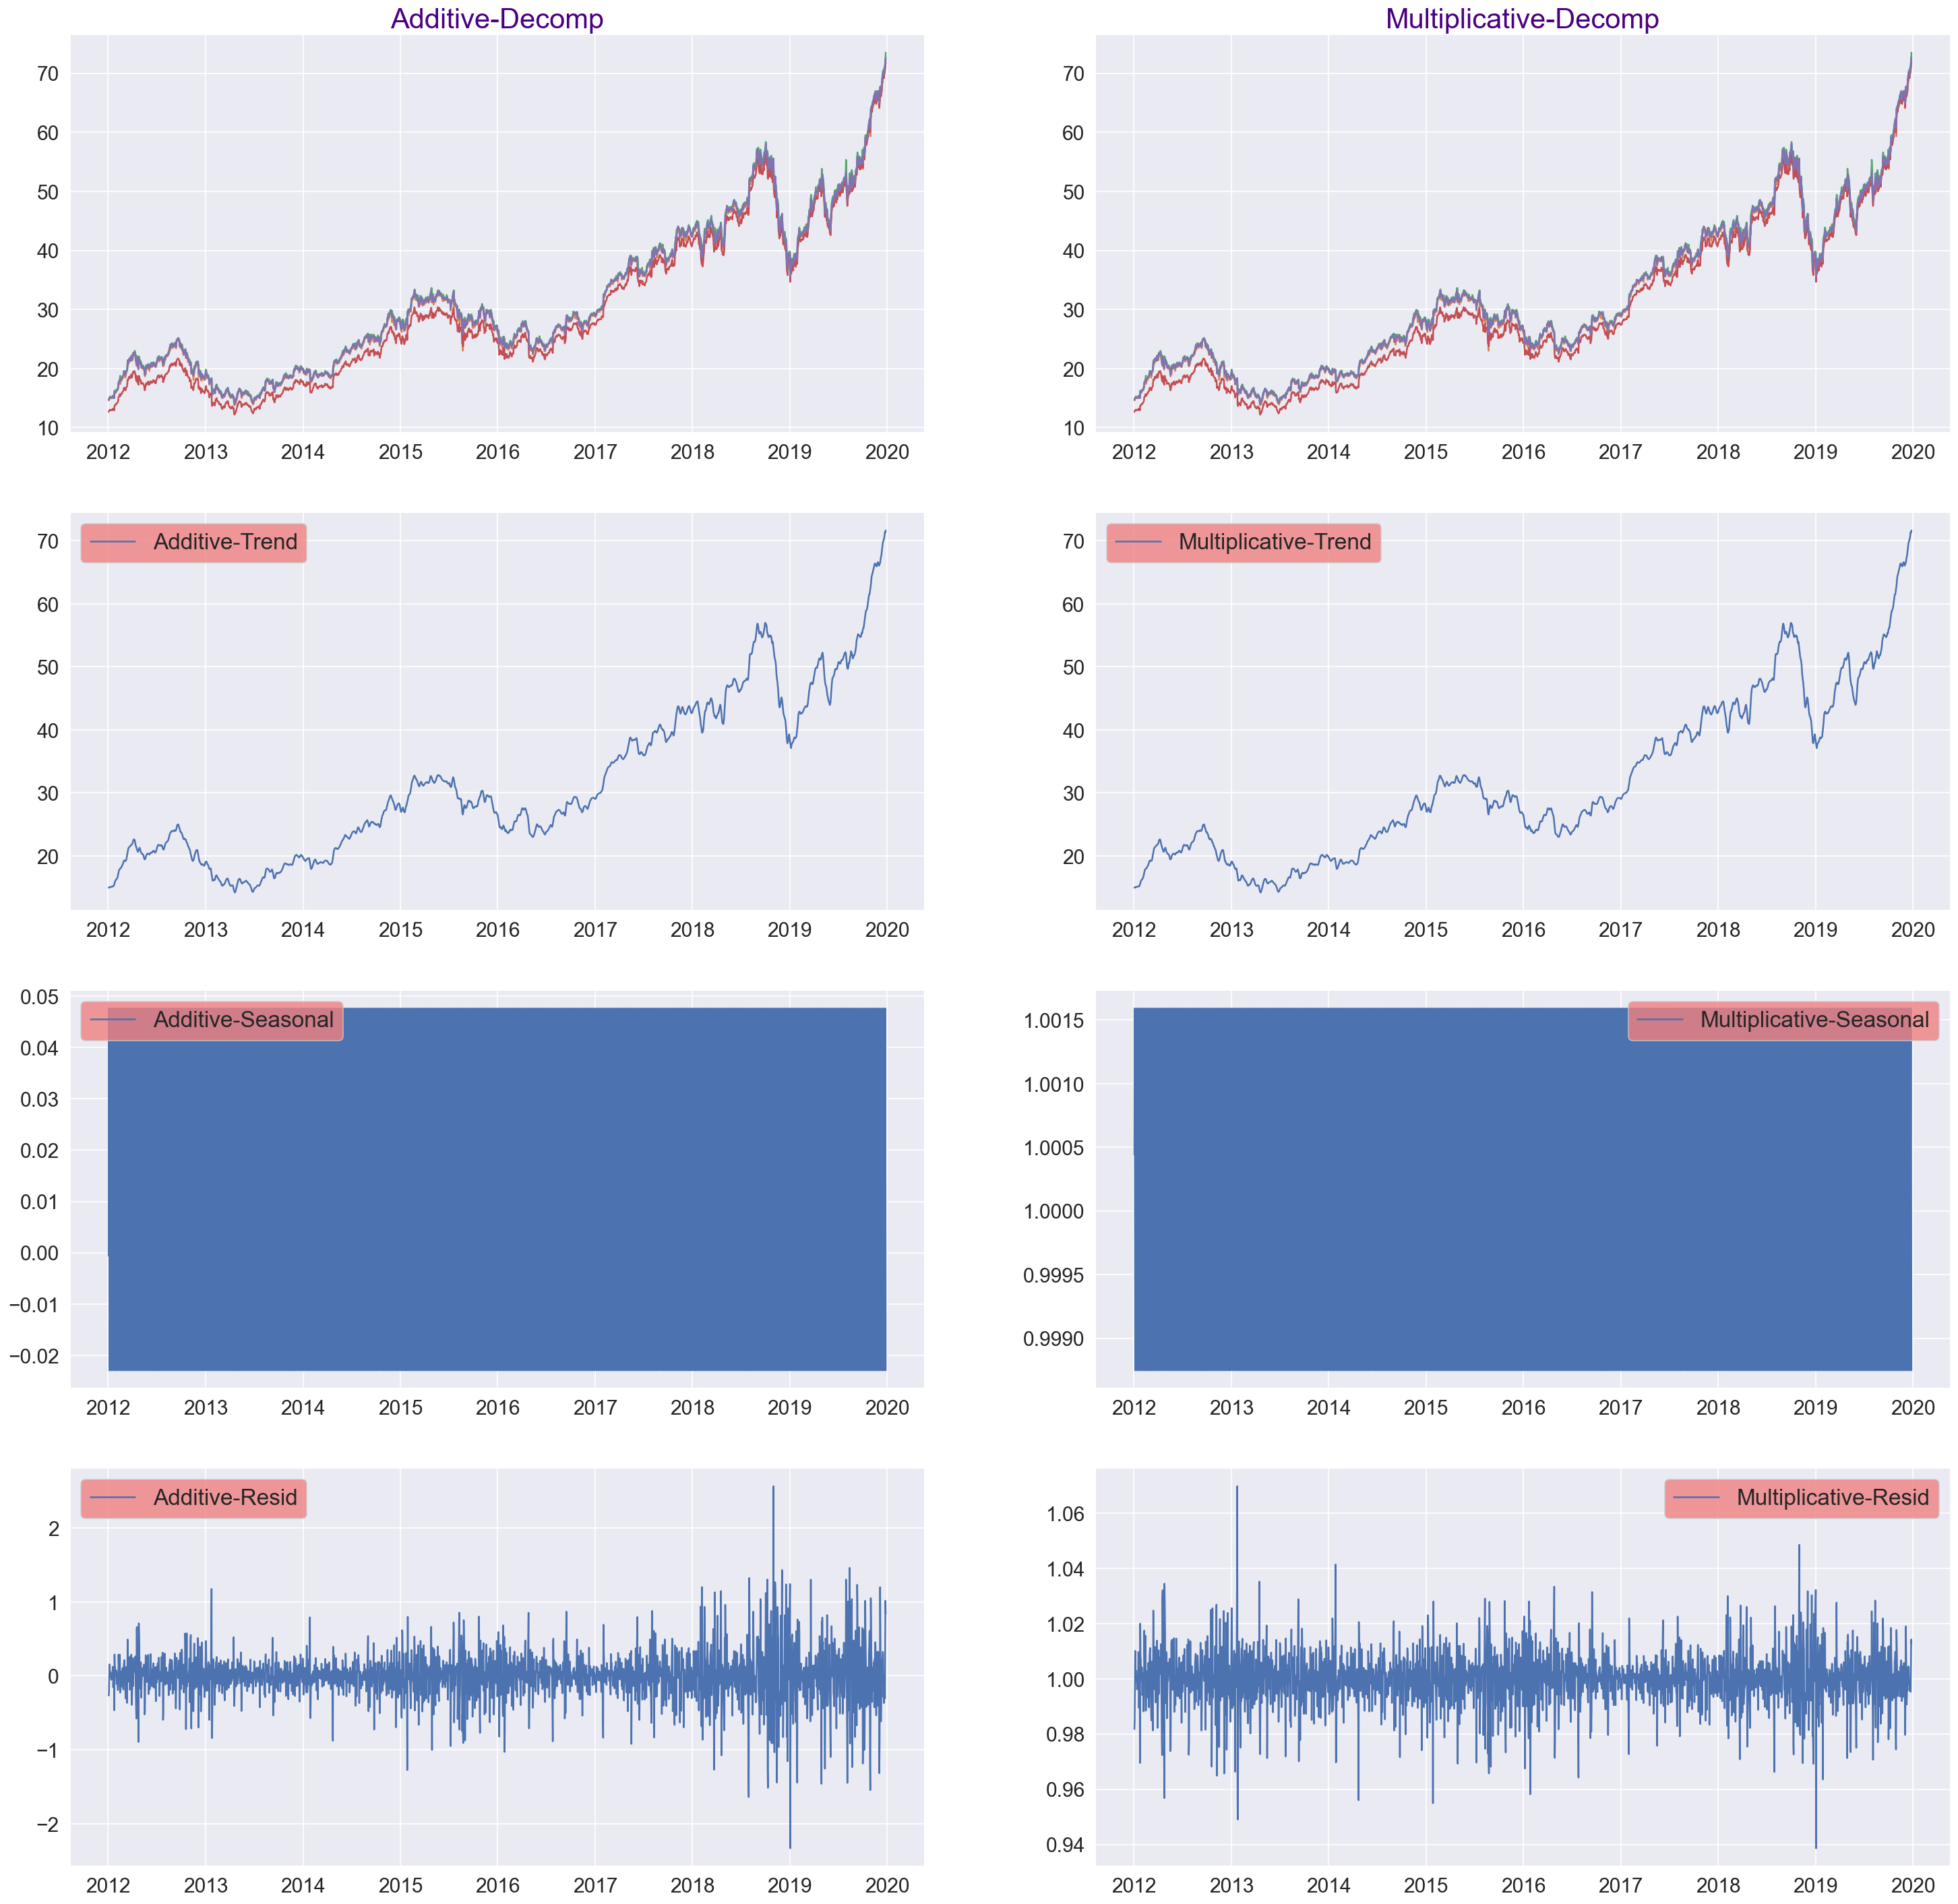

In [68]:
plt.figure(figsize=(30,30))

Gs= gs.GridSpec(4,2)

ax0=plt.subplot(Gs[0])
plt.plot(df0.drop(columns="Volume"))
plt.title("Additive-Decomp", fontsize=25, color= "indigo")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax1=plt.subplot(Gs[1])
plt.plot(df0.drop(columns="Volume"))
plt.title("Multiplicative-Decomp", fontsize=25, color= "indigo")
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax2= plt.subplot(Gs[2])
plt.plot(decomp_diaria_add.trend, label= "Additive-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax3= plt.subplot(Gs[3])
plt.plot(decomp_diaria_mltp.trend, label= "Multiplicative-Trend")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax4= plt.subplot(Gs[4])
plt.plot(decomp_diaria_add.seasonal, label= "Additive-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc=2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax5= plt.subplot(Gs[5])
plt.plot(decomp_diaria_mltp.seasonal, label= "Multiplicative-Seasonal")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 1)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)


ax6= plt.subplot(Gs[6])
plt.plot(decomp_diaria_add.resid, label= "Additive-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral', loc= 2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax7= plt.subplot(Gs[7])
plt.plot(decomp_diaria_mltp.resid, label= "Multiplicative-Resid")
plt.legend(fontsize=20, facecolor= 'lightcoral')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

plt.show()

**Observaciones:**


* _*Luego de descomponer la serie, tanto en forma aditiva como multiplicativa, lo devuelto por la funcion es practicamente los mismos resultados **pero** a la hora de observar los residuos de ambas descomposisiones se observa como al descomponer con aditivo observamos que los residuales todavia, aunque poco marcado, conservan cierto patron repetitivo mas que nada en los primeros años. Por el contrario, la descomposision multiplicativa nos muestra como los residuos resultantes poseen un comportamiento completamente aleatorio, que es lo que nos interesa. Para fines de analizar esta serie, se utilizara el modelo `multiplicativo`, el cual explica mejor el comportamiento de la serie.*_

#### _*Metodo elegido:*_ *Multiplicative*

In [69]:
serie_multiplicativa = pd.concat([decomp_diaria_mltp.seasonal, decomp_diaria_mltp.trend, decomp_diaria_mltp.resid, decomp_diaria_mltp.observed], axis=1)
serie_multiplicativa.columns = ['seas', 'trend', 'resid', 'actual_values']
serie_multiplicativa.head()

seas      trend     resid  actual_values
Date                                                    
2012-01-03  1.000443  14.953307  0.981742      14.686786
2012-01-04  1.001590  14.968136  0.984910      14.765714
2012-01-05  1.000299  14.982966  0.996143      14.929643
2012-01-06  0.998747  14.953877  1.010082      15.085714
2012-01-07  0.999193  15.015153  1.004979      15.077738

* _*Si los datos observados son correctos y la descomposision **multiplicativa** fue correcta, entonces el multiplo de `seas` * `trend` * `resid` = `actual_values`.*_

In [70]:
fecha_random = dt.datetime.strftime(pd.to_datetime(np.random.choice(serie_multiplicativa.index)),'%Y-%m-%d')

trend= round(float(serie_multiplicativa[serie_multiplicativa.index == fecha_random].trend.values))
seas= round(float(serie_multiplicativa[serie_multiplicativa.index == fecha_random].seas.values))
resid= round(float(serie_multiplicativa[serie_multiplicativa.index == fecha_random].resid.values))

actual_value= round(float(serie_multiplicativa[serie_multiplicativa.index == fecha_random].actual_values.values))

if round(trend * seas * resid) == actual_value :
    print("Descompocision correcta")
else:
    print("Descompocision incorrecta")

Descompocision incorrecta


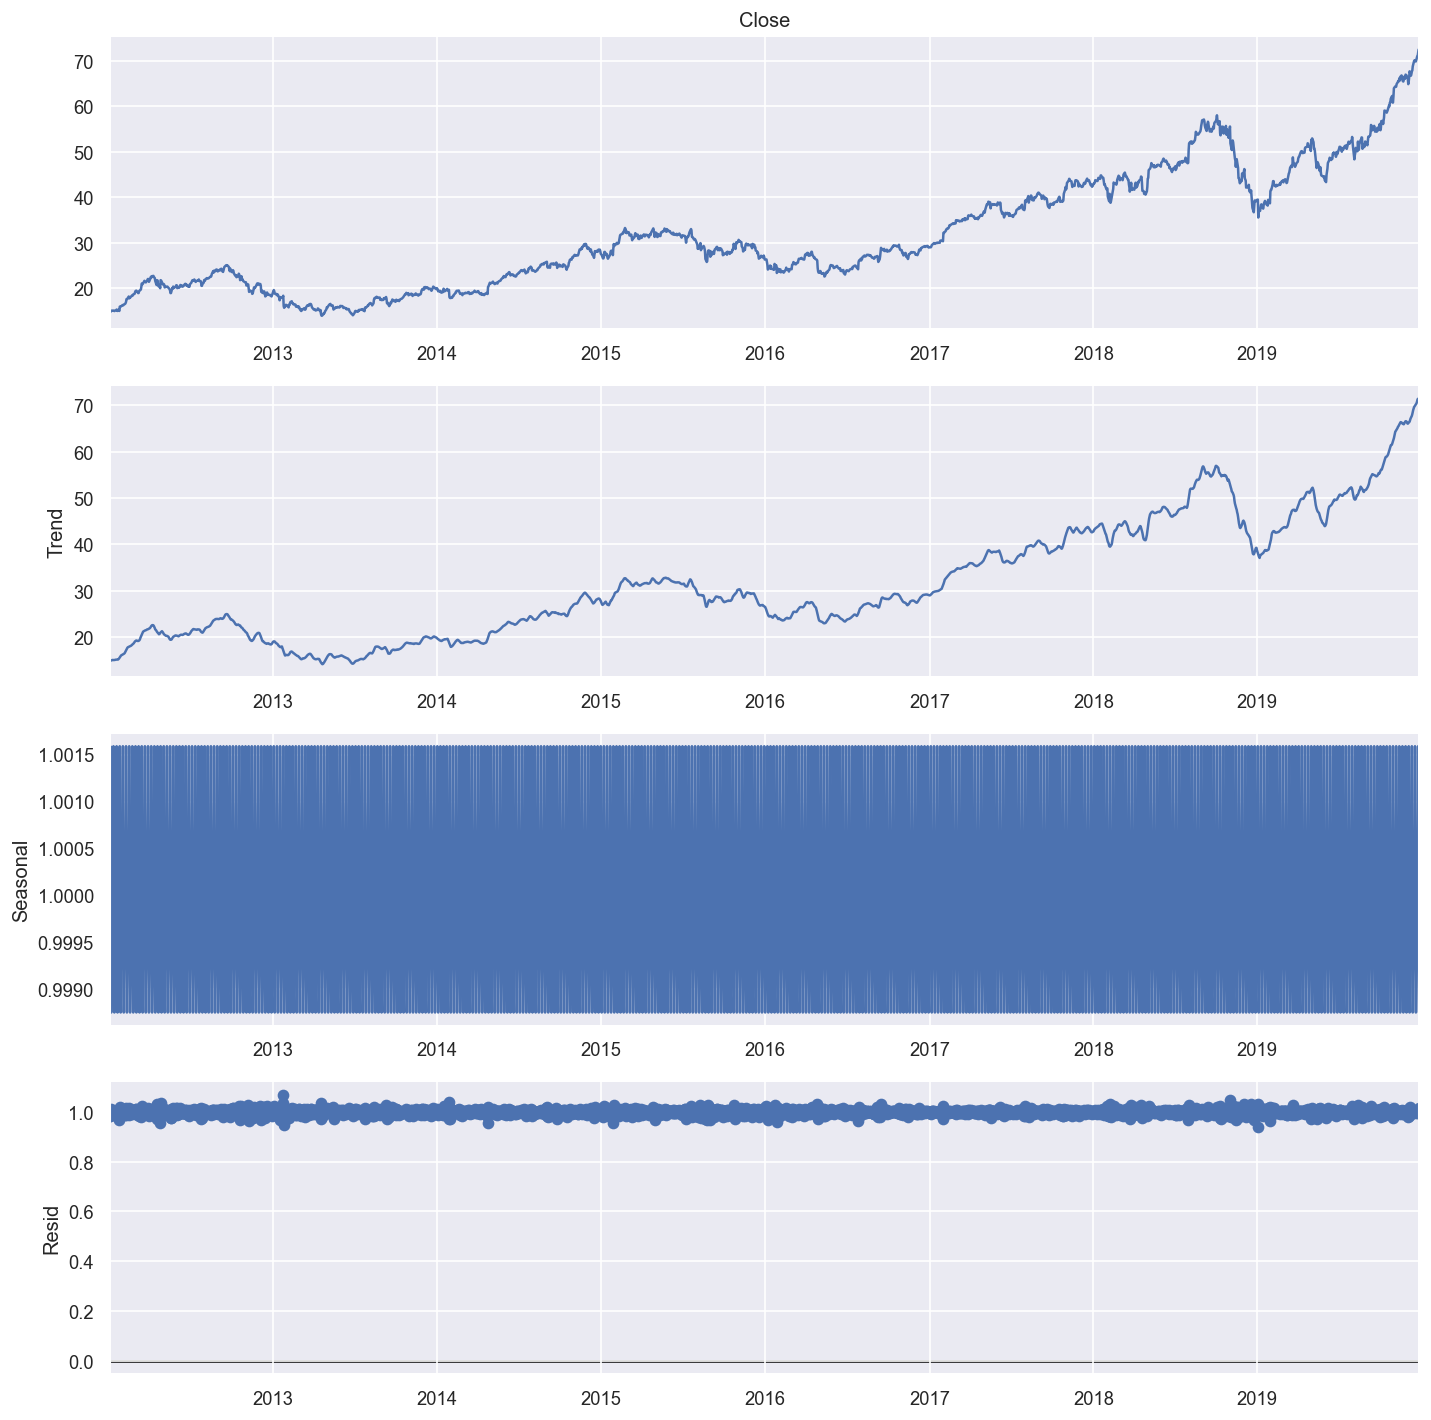

In [71]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df0.Close, model='multiplicative',extrapolate_trend='freq')

decomp_diaria.plot()
plt.show()

##### *Evaluando metodo 'Additive'*

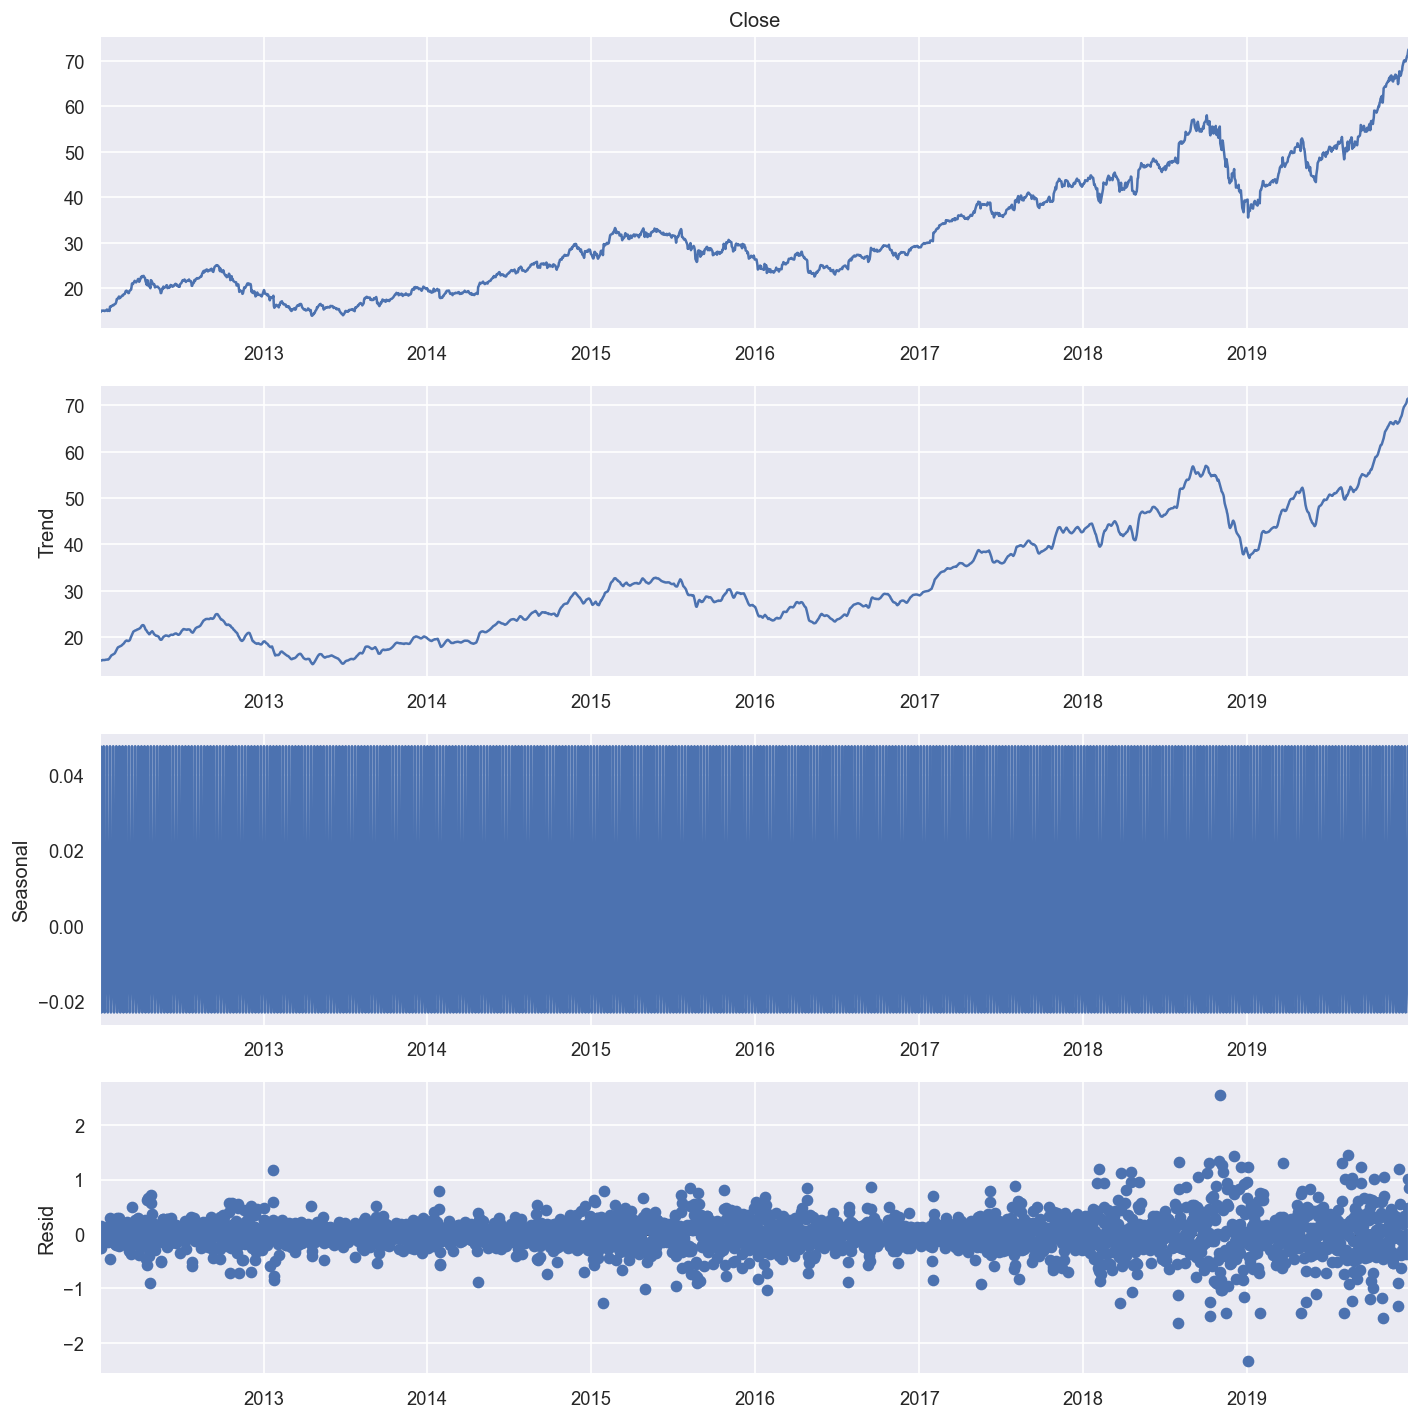

In [72]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df0.Close, model='additive',extrapolate_trend='freq')

decomp_diaria.plot()
plt.show()

#### _*Histograma residuales*_

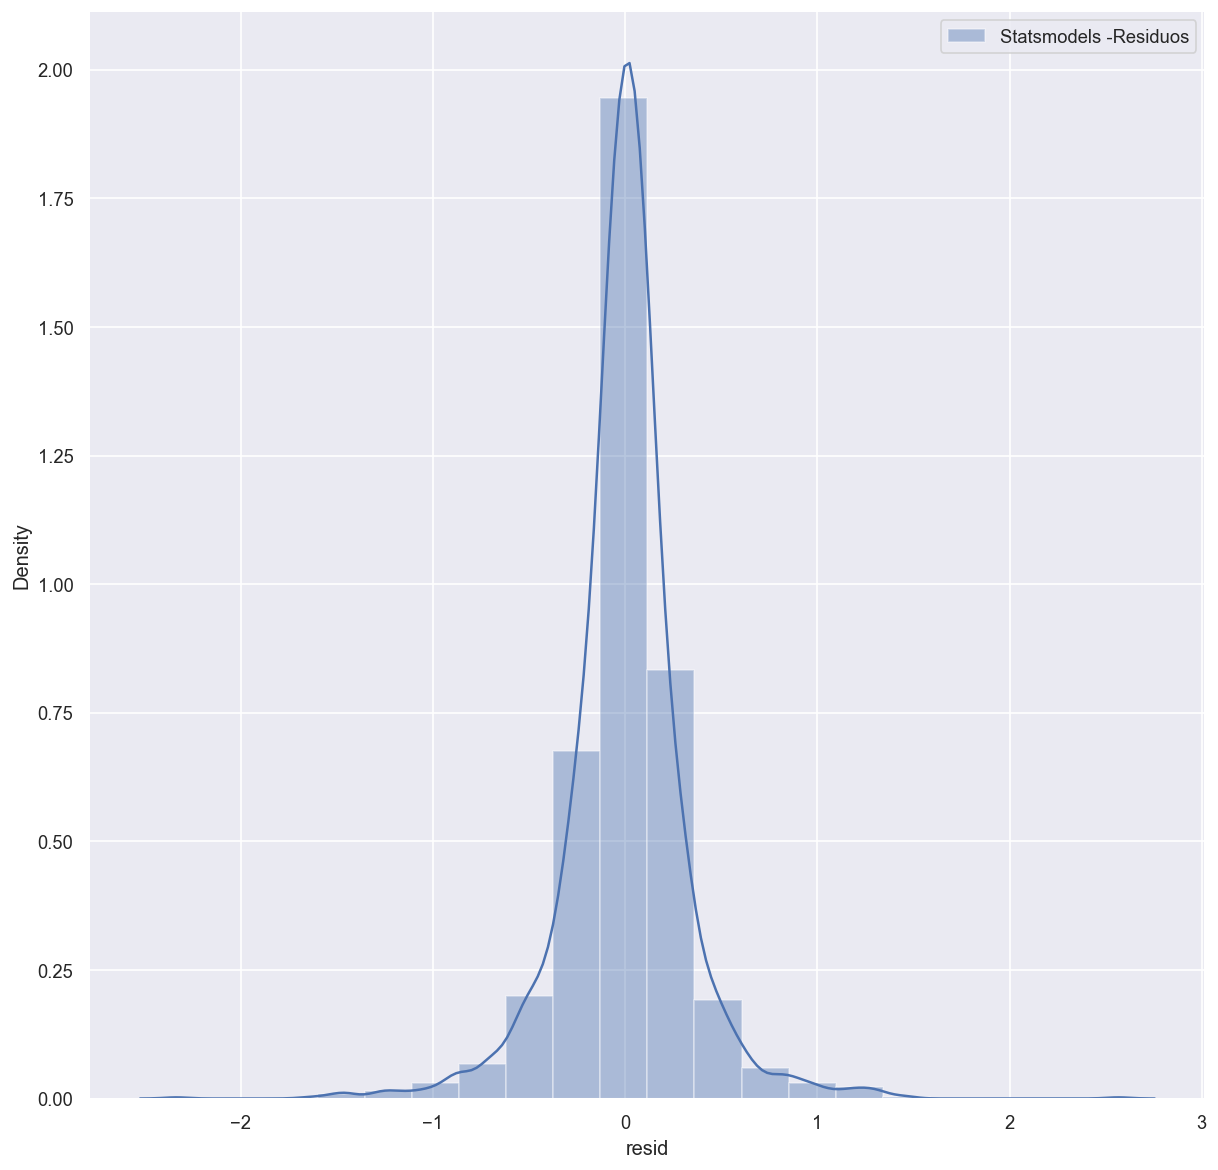

In [73]:
sns.distplot(decomp_diaria.resid, bins=20, label="Statsmodels -Residuos")

plt.legend()
plt.show()

**Observaciones:** 

* _*Los residuales se encuentra distribuidos en una distribucion del tipo Gaussiana, la normal esperada. Como estamos trabajando con una serie multiplicativa, podemos ver como el promedio se encuentra fijo en 1 y luego se aprecian las desviaciones estandar distribuidas normalmente.*_

### Conclusion Descomposion


* _*A grandes (y pequeños) rasgos, se estudio la serie y tanto el modelo aditivio como multiplicativo se pueden aplicar a la serie. El aditivo porque durante los primeros años observados la serie presenta una estacionalidad marcada, la cual indica una tendencia estacionaria. Luego, a medidida que pasa el tiempo la estacionalidad empieza a incrementar y su tendencia se vuelve no-estacionaria, empieza a tomar valores cada vez mas alejados del anterior y crece de manera mas exponencial.*_


* _*La serie en si, es apta para el modelado. Voy a realizar la [prueba Dicky fuller](https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller) (ADH test) para corroborar que la serie de tiempo sea estacionaria.*_

## Evaluando estacionaria/no-estacionaria

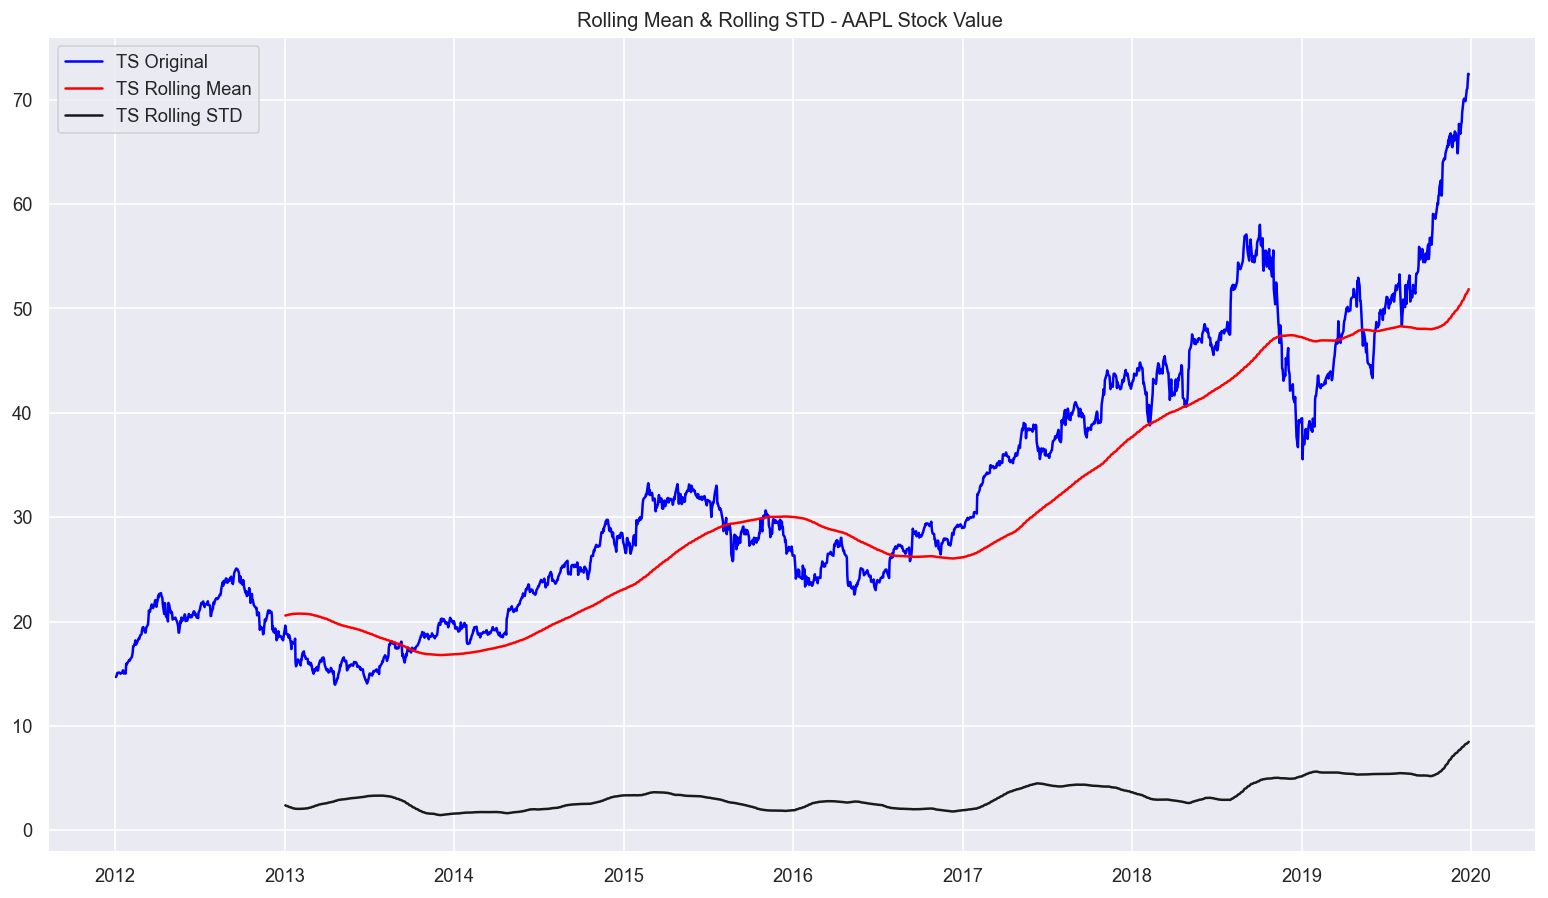

In [74]:
plt.figure(figsize=(16,9))

rol_mean = df["Close"].rolling(window = 251).mean()
rol_std = df["Close"].rolling(window = 251).std()

plt.plot(df.index, df["Close"], color ="blue", label ="TS Original")
plt.plot(df.index, rol_mean, color = "red", label ="TS Rolling Mean")
plt.plot(df.index, rol_std, color= "k", label = "TS Rolling STD")
plt.title("Rolling Mean & Rolling STD - AAPL Stock Value ")
plt.legend(loc="best")
plt.show()

### *Dicky Fuller Test*

* _*Basicamente lo que buscamos cuando trabajamos con series de tiempo, es que la serie en si sea estacionaria. Esto, claro esta, es la opcion optima dado que al tener componentes estacionarios como la tendencia o la estacionalidad los modelos pueden desempeñar en su maximo rendimiento al momento de realizar un forecast. El problema esta cuando la serie, no es estacionaria dado que a movimientos inesperados e aleatorios en la tendencia y/o estacionalidad el modelo no va a desempeñar de la mejor manera.*_


* _*A veces, a simple vista podemos darnos cuenta de que serie es o no estacionaria (como la que estamos trabajando). Pero, para siempre estar seguro es mejor utilizar metodos que cuantifican los valores a travez de ecuaciones establecidad (aka Agumented Dicky Fuller Test) para corroborar o no la existencia de [raices unitarias](https://es.wikipedia.org/wiki/Ra%C3%ADz_unitaria) en la serie de tiempo. Estas ultimas, basicamente lo que indican en su presencia es que los valores estan sujetos a una estructura-dependencia en el tiempo.*_


* _*La prueba **Dicky Fuller** en simples terminos establece la hipotesis nula de que existen raices unitarias y la serie de tiempo es no-estacionaria. Al aplicar la ecuacion agumentda (ADF) y observar los resultados podemos ver que:*_

  * _*Si **Test Statistic < Critical Value**  rechazamos la hipotesis nula y la serie de tiempo es estacionaria.*_
  * _*Si **Test Statistic > Critical Value** entonces no podemos rechazar la hipotesis nula y la serie de tiempo no es estacionaria(lo cual no lo hace apto para su modelado).*_

In [75]:
def adf_test(timeseries):
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [76]:
adf_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    1.170208
p-value                           0.995773
#Lags Used                        9.000000
Number of Observations Used    2000.000000
Critical Value (1%)              -3.433624
Critical Value (5%)              -2.862986
Critical Value (10%)             -2.567540
dtype: float64


* _*Al realizar la prueba Dicky Fuller podemos observar que el valor de **Test Statistic** es mayor al de **Critical Value** por lo cual no podemos rechazar la hipotesis nula a lo que la serie de tiempo es no-estacionaria y antes de modelar debe ser transformada a estacionaria.*_

### *KPSS Test*

* _*Otro metodo comunmente utilizado en series de tiempo a la hora de probar,o no, si una series es estacionaria es la prueba [KPSS]() (por Kwiatkowski-Phillips-Schmidt-Shin) la cual trabaja al contrario de como opera Dicky Fuller Test.*_


* _*La prueba **KPSS** establece la hipotesis nula que la serie de tiempo es estacionaria y no posee presencia de raices unitarias(valores dependientes del tiempo). Al aplicar la funcion KPSS y observar los resultados podemos ver que:*_
   * _*Si **Test Statistic > Critical Value** rechazamos la hipotesis nula y la serie de tiempo es **no-estacionaria** y posee raices unitarias.*_
   *  _*Si **Test Statistic < Critical Value** entonces no podemos rechazar la hipotesis nula y la serie de tiempo es **estacionaria** sin la presencia de raices unitarias*_ 

In [77]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags = 'auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [78]:
kpss_test(df["Close"])

Results of KPSS Test:
Test Statistic            5.980497
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


* _*Al realizar la prueba KPSS podemos observar que el valor de **Test Statistic** es mayor a **Critical Value** por lo que rechazamos la hipotesis nula y la serie de tiempo es **no-estacionaria** y posee raices unitarias.*_

### *Transformando serie a *estacionaria**

* _*Como se demostro arriba, y tambien observando la serie y sus valores, tendencia, comportamiento de la misma a travez del tiempo, con la prubea Dicky Fuller Agumentada la serie de tiempo es **no-estacionaria** lo cual vuelve a nuestra serie no apta para su modelado. En realidad si se puede moderlar con este tipo de series, el problema se encuentra en que la prediccion de nuestro modelo se vuelve no tan confiable dado que los modelos no operan bien sobre series no-estacionarias.*_


* _*Para corregir este problema, se opta por una solucion que se llama **Differencing** la cual consiste en transformar la serie de tiempo. Se utiliza para remover la "dependecia del tiempo" en nuestra variable observada. De esta manera manera logramos establizar el promedio de la serie de tiempo al remover cambios ocasionados en la escala del tiempo y tambien eliminar (o reducir) la tendencia y su estacionalidad.*_

#### _*Differencing*_

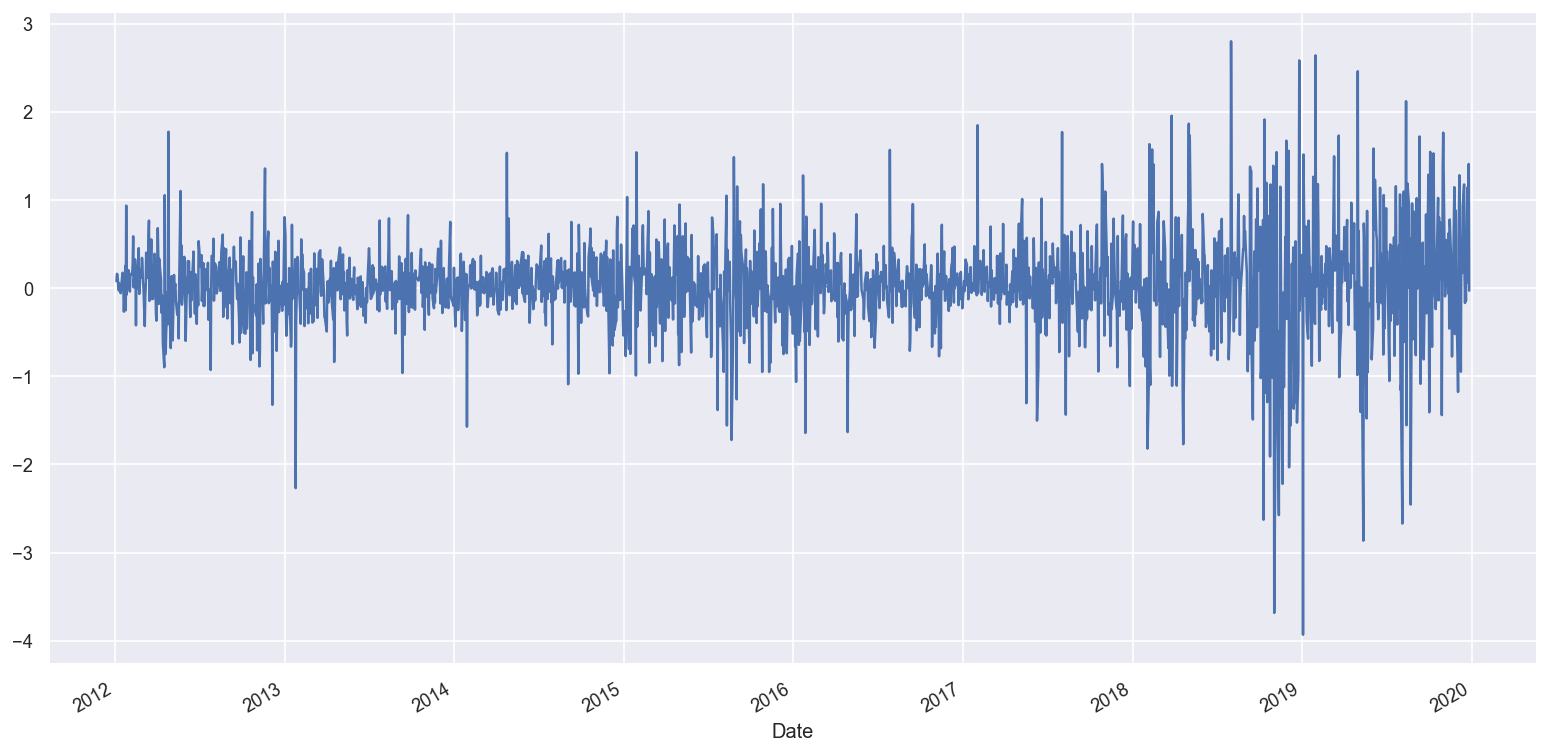

In [79]:
plt.figure(figsize=(16,8))

df["Close_Diff"] = df["Close"] - df["Close"].shift(1)

df["Close_Diff"].dropna().plot()

plt.show()

In [80]:
print(adf_test(df["Close_Diff"].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -1.364679e+01
p-value                        1.613930e-25
#Lags Used                     8.000000e+00
Number of Observations Used    2.000000e+03
Critical Value (1%)           -3.433624e+00
Critical Value (5%)           -2.862986e+00
Critical Value (10%)          -2.567540e+00
dtype: float64
None


* _*Si bien se puede apreciar que la serie de tiempo se volvio estacionaria con un comportamiento mas "adecuado" para un modelo de series de tiempo, tambien se observa que perdio gran parte de sus datos. Se puede observar que la diferenciacion de la variable `CLose` en 1 periodo de tiempo, devuelve valores negativos en la serie de tiempo.*_


* _*Voy a probar con 2 tecnicas mas de transformacion: **Seasonal Differencing** y **Transformation**. Luego de realizar las 3 transformaciones decidire cual representa mejor los valores reales de la serie de tiempo y luego es cuestion de modelar.*_

#### _*Seasonal Differencing*_

* _*Con este metodo, en vez de calcular la diferencia entre valores consecutivos, se calcula la diferencia entre una observaciones y observaciones previas de la misma temporada. Por ejemplo: Una observacion realizada en X fecha, se restara de una observacion realizada en X-n fecha, donde **n** es un hiperparametro.*_ 

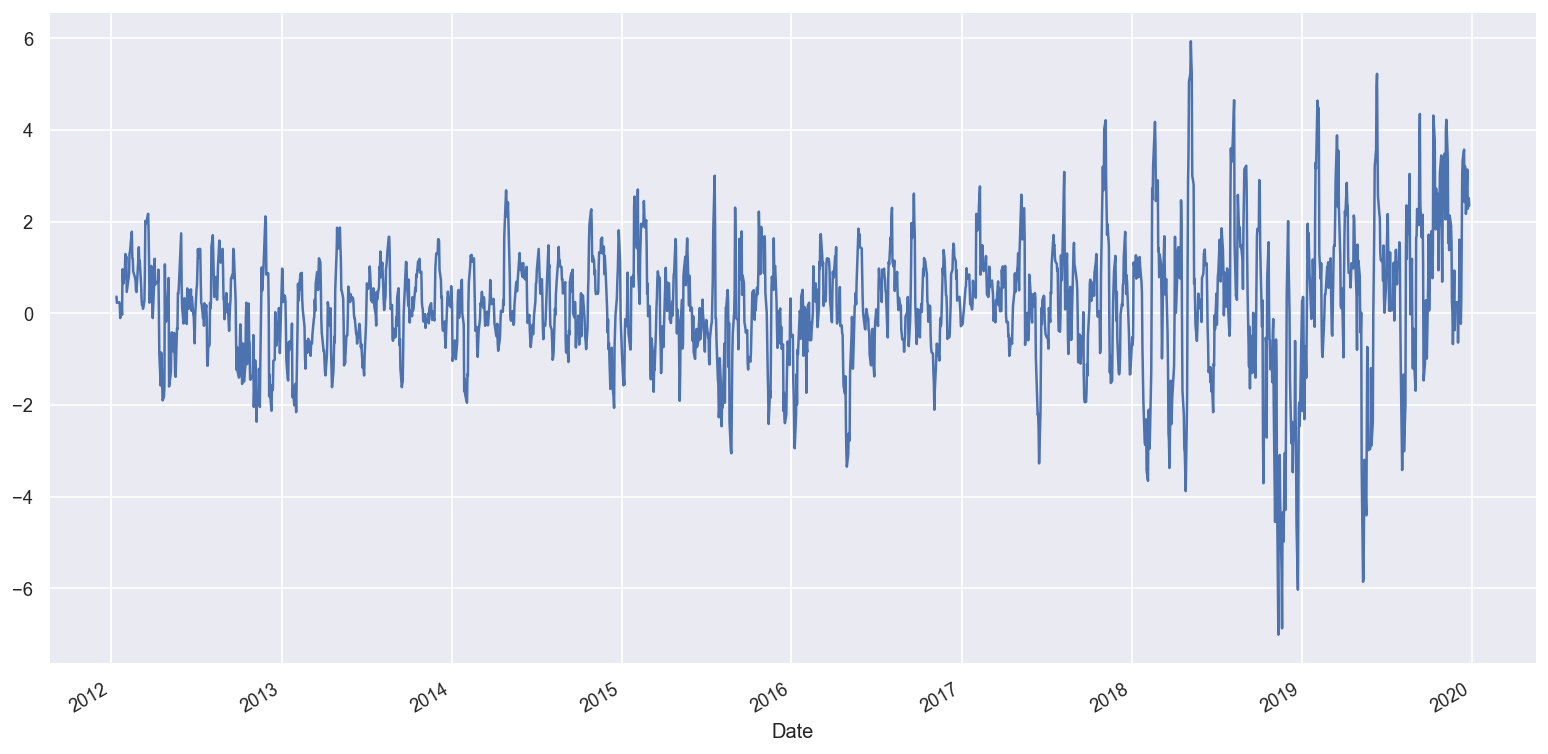

In [81]:
plt.figure(figsize=(16,8))

n = 7

df["Close_Diff_1"] = df["Close"] - df["Close"].shift(n)

df["Close_Diff_1"].dropna().plot()

plt.show()

In [82]:
print(adf_test(df["Close_Diff_1"].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -7.155713e+00
p-value                        3.058643e-10
#Lags Used                     2.500000e+01
Number of Observations Used    1.977000e+03
Critical Value (1%)           -3.433662e+00
Critical Value (5%)           -2.863003e+00
Critical Value (10%)          -2.567549e+00
dtype: float64
None


#### _*Transformation Differencing*_

* _*Este metodo se utiliza para estabilizar la varianza no constante de la serie. Una de las transformaciones mas comunes es la transformacion a travez de **log**, como realizare ahora.*_

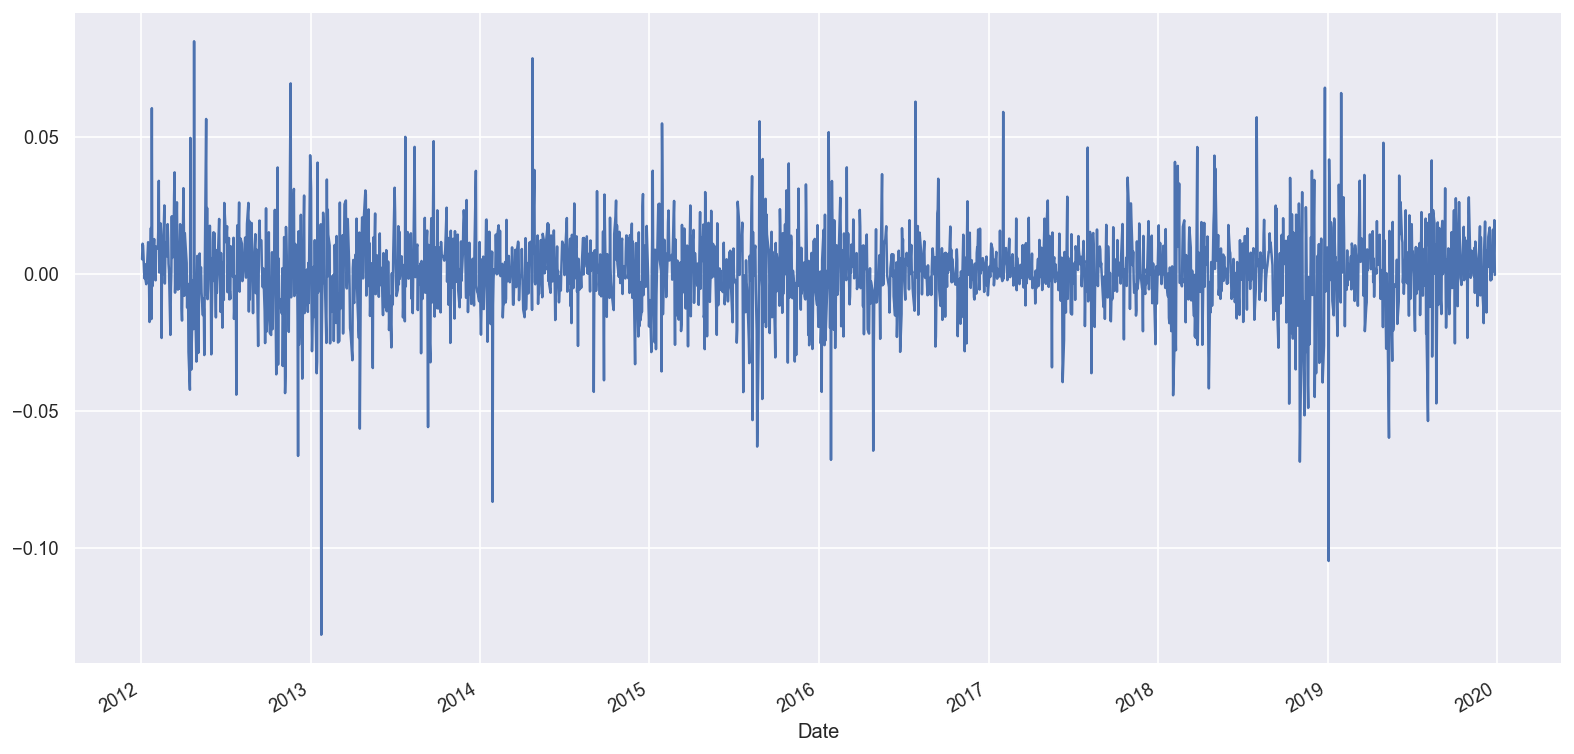

In [83]:
plt.figure(figsize=(16,8))

df["Close_log"] = np.log(df["Close"])

df["Close_Diff_log"] = df["Close_log"] - df["Close_log"].shift(1)

df["Close_Diff_log"].dropna().plot()

plt.show()

In [84]:
print(adf_test(df["Close_Diff_log"].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -1.575539e+01
p-value                        1.209375e-28
#Lags Used                     7.000000e+00
Number of Observations Used    2.001000e+03
Critical Value (1%)           -3.433622e+00
Critical Value (5%)           -2.862985e+00
Critical Value (10%)          -2.567540e+00
dtype: float64
None


#### _*Transformation*_

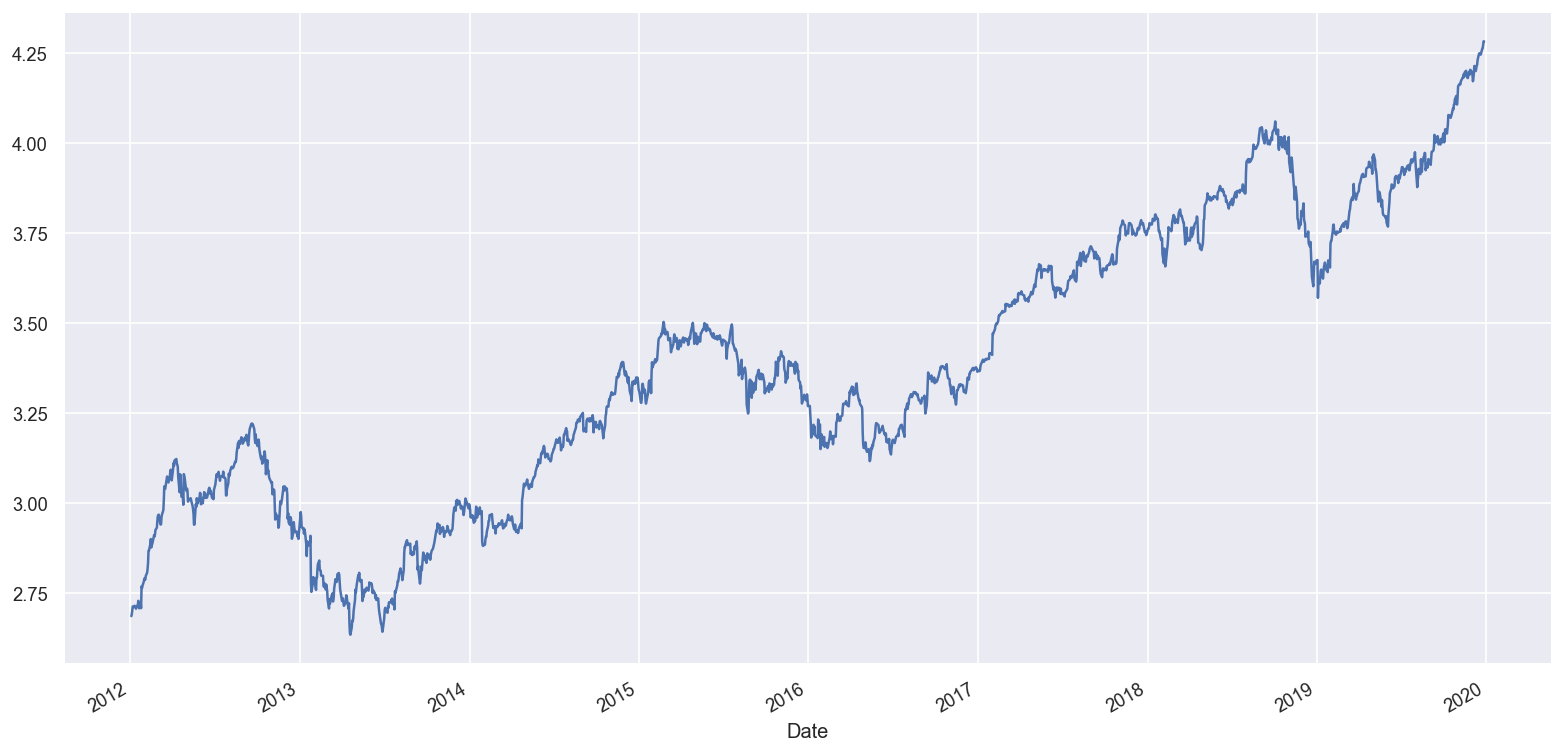

In [85]:
plt.figure(figsize=(16,8))

df["Close_log"].dropna().plot()
plt.show()

In [86]:
print(adf_test(df["Close_log"].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                   -0.291864
p-value                           0.926649
#Lags Used                        8.000000
Number of Observations Used    2001.000000
Critical Value (1%)              -3.433622
Critical Value (5%)              -2.862985
Critical Value (10%)             -2.567540
dtype: float64
None


* _*Se puede ver como a simple viste, las mejoras son notorias en la serie de tiempo y esta toma una forma mucho mas "armoniosa" aun que presenta ciertas falencias todas las transformaciones. Por ejemplo:*_

    * Da la impresion de que se perdio la esencia original de la serie.
    * Algunas transformaciones devuelven representaciones muy distintas a la serie original, algunas hasta con picos muy negativos en ciertos puntos. 
    
    
* _*Por otro lado, se observa que luego de los dinstintos metodos aplicados para transformar la serie a **estacionaria** los resultados obtenidos demuestran una media fija en 0.*_

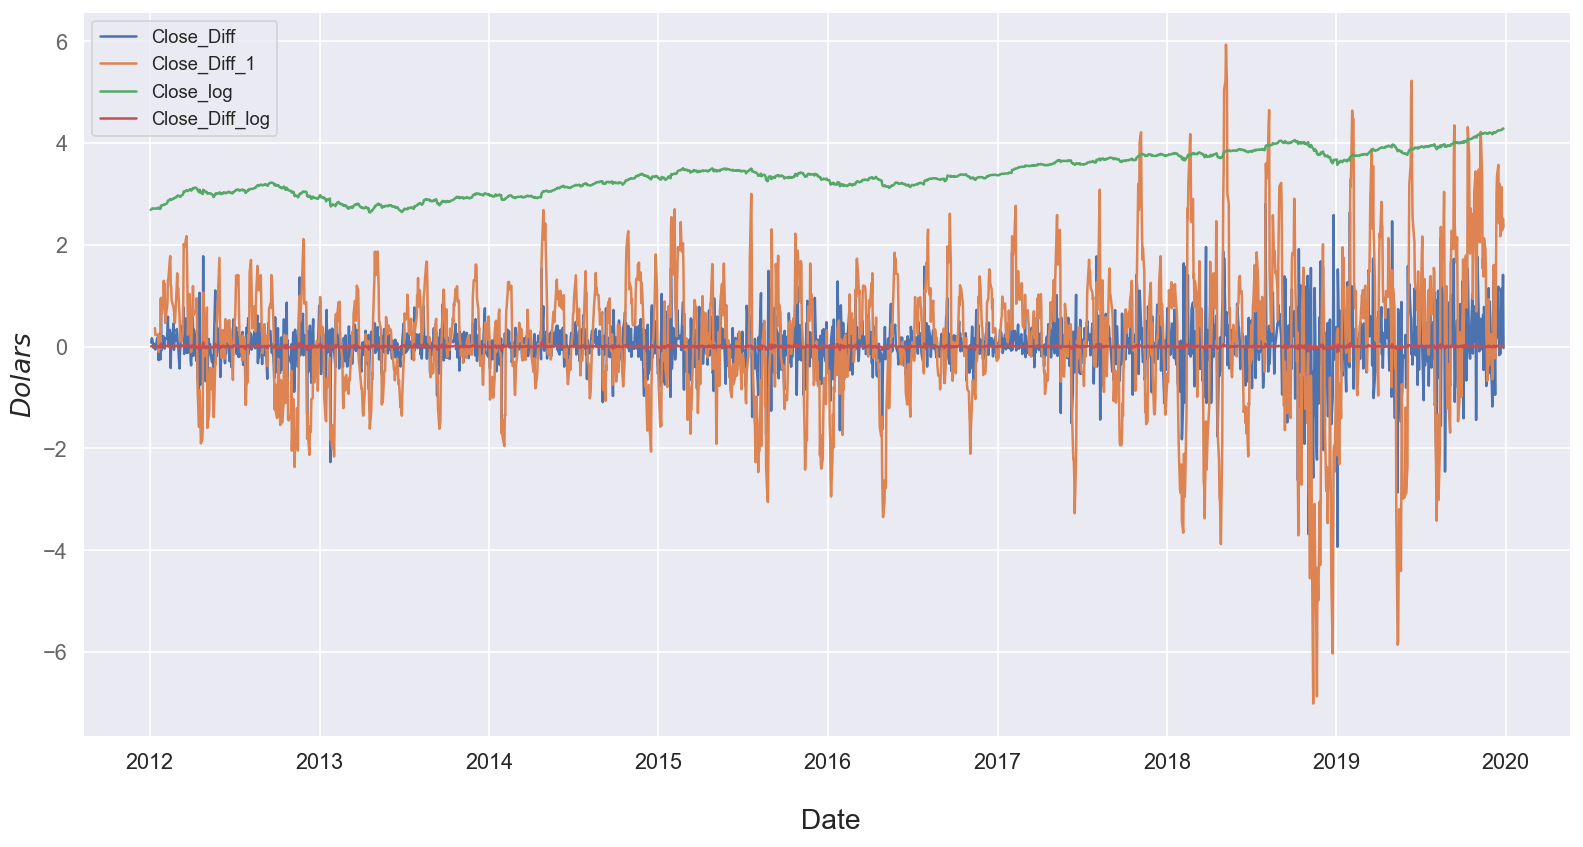

In [87]:
plt.figure(figsize=(16,8))

for col in df.drop(columns=["Open","Volume", "Low", "High", "Adj Close", "Close"]).columns :
    
    plt.plot(df.index, df[col], label = col)
    plt.xlabel("\n Date", fontsize= 17)
    plt.ylabel("$Dolars$", fontsize =16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize = 13, alpha=.7)
    plt.legend()

plt.show()

#### _*Evaluando descomposicion de las series resultantes*_

* _*Differencing method*_

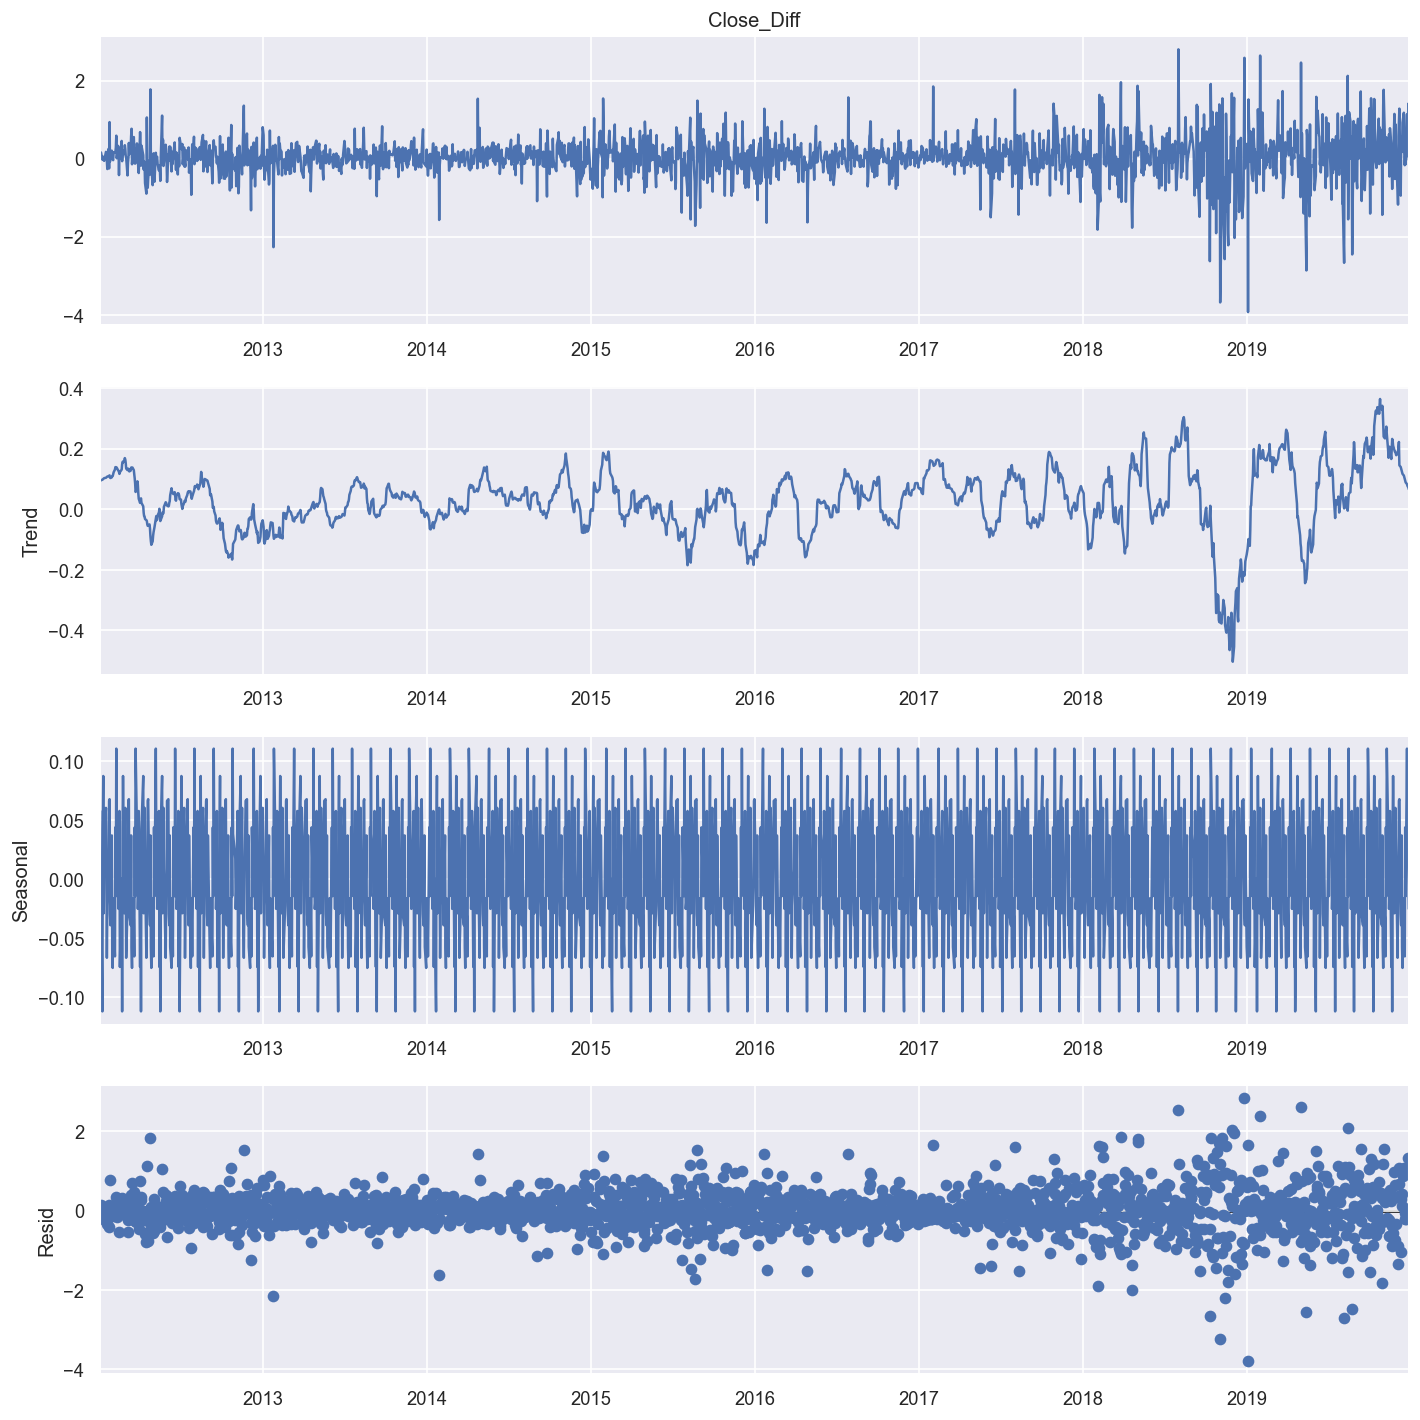

In [88]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df.Close_Diff.dropna(), model='additive',extrapolate_trend='freq', freq=30)

decomp_diaria.plot()
plt.show()

* _*Seasonal Differencing*_

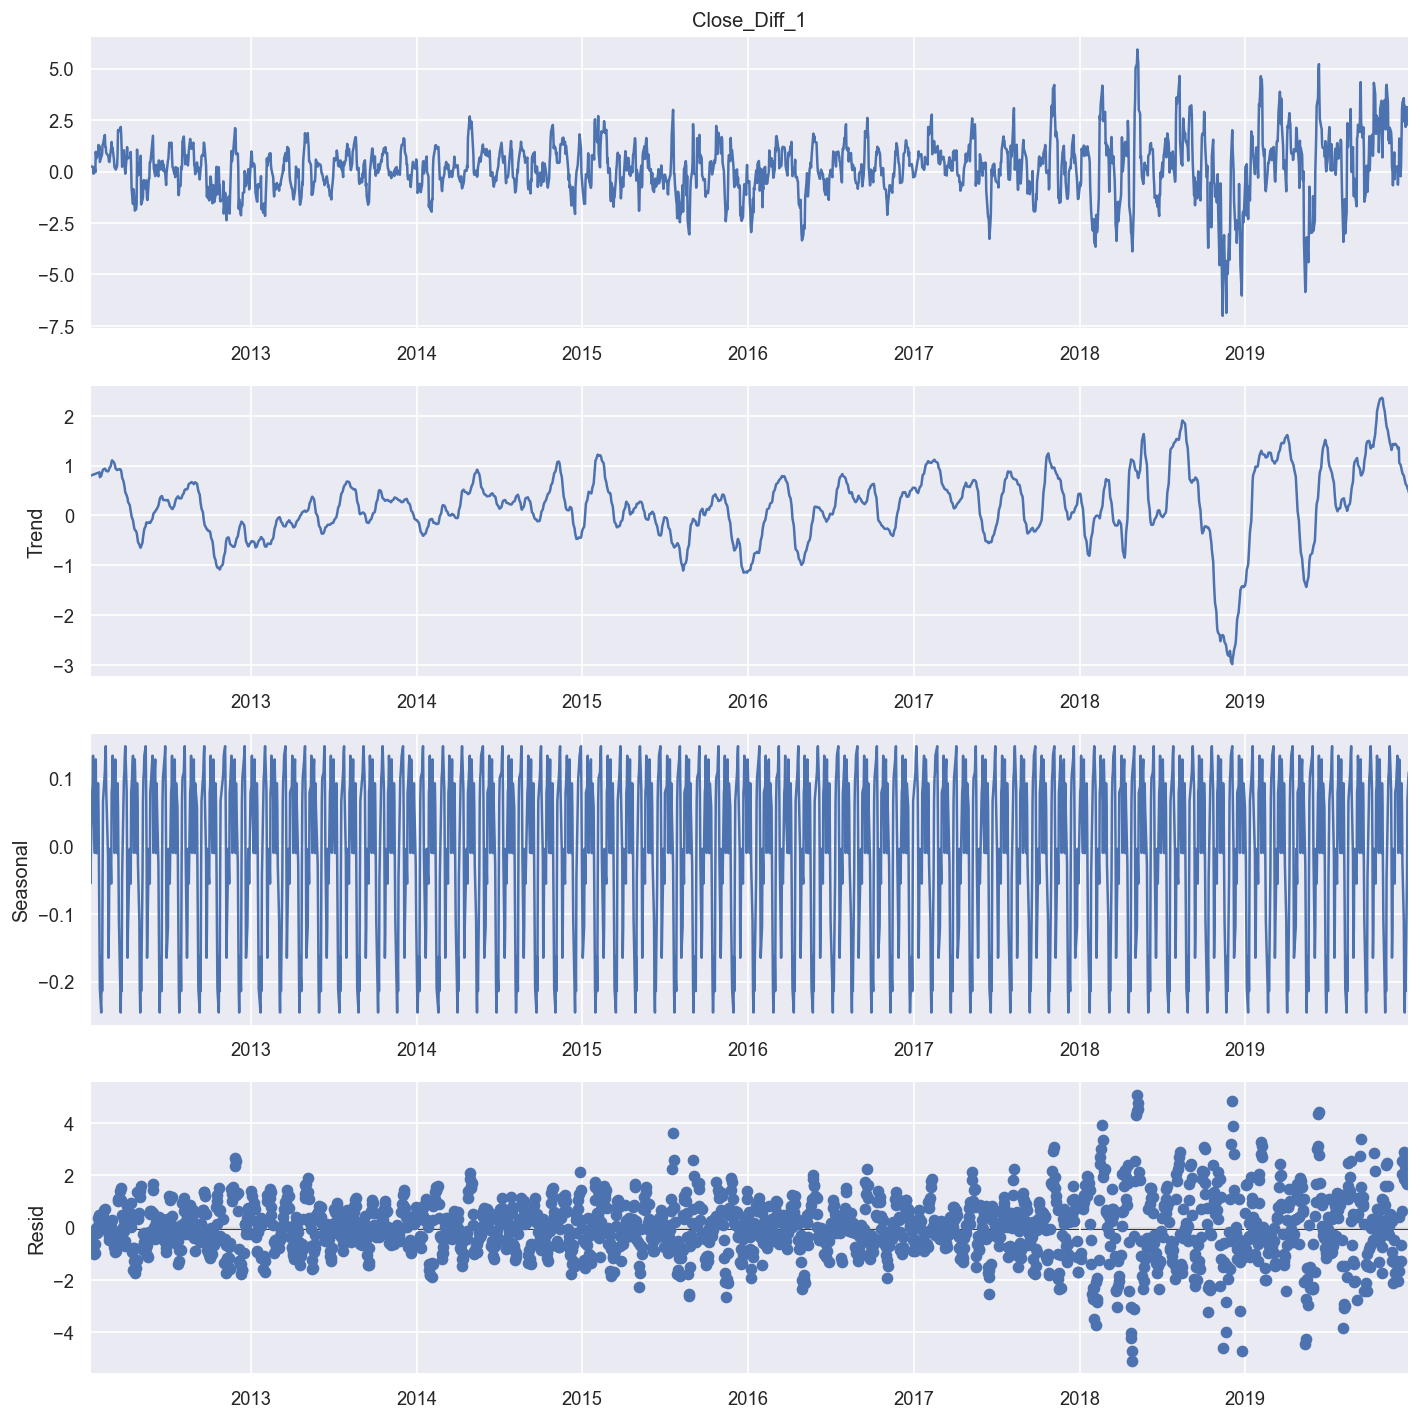

In [89]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df.Close_Diff_1.dropna(), model='additive',extrapolate_trend='freq', freq=30)

decomp_diaria.plot()
plt.show()

* _*Transformation Differencing*_

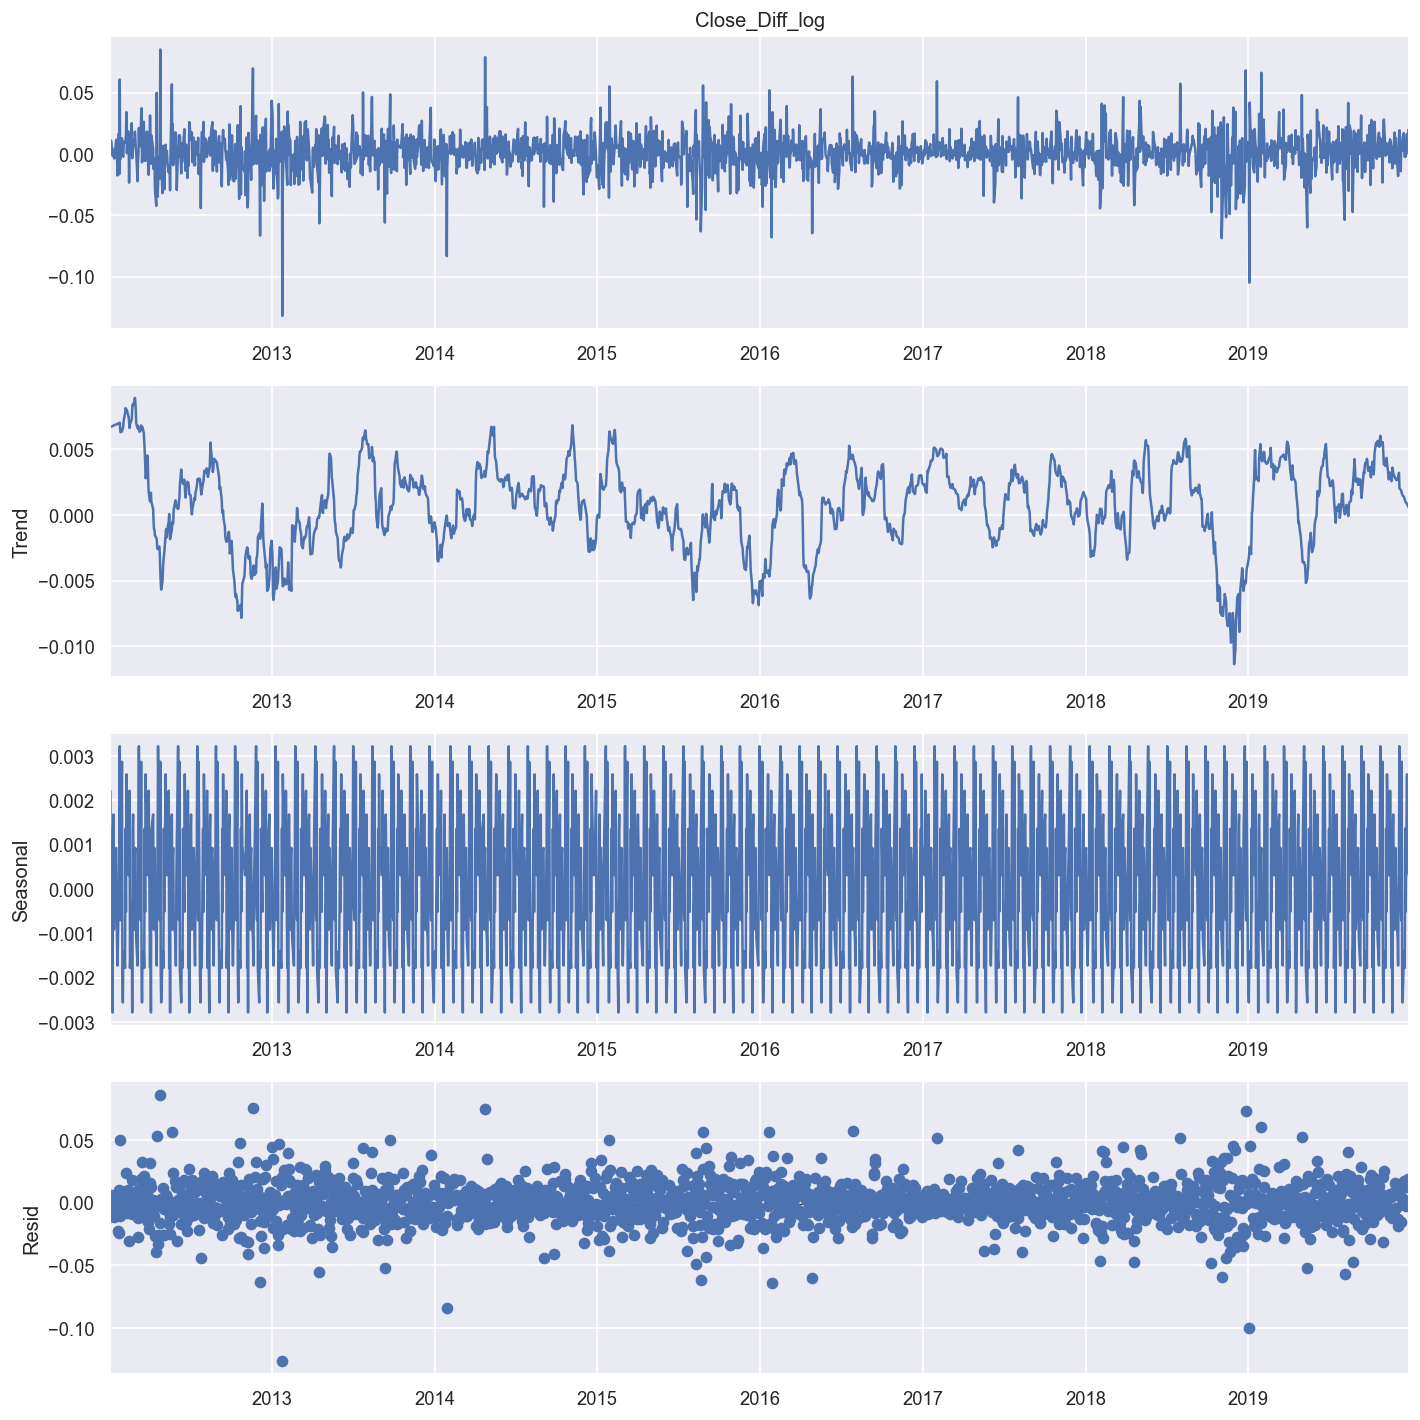

In [90]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df.Close_Diff_log.dropna(), model='additive',extrapolate_trend='freq', freq=30)

decomp_diaria.plot()
plt.show()

* _*Transformation*_

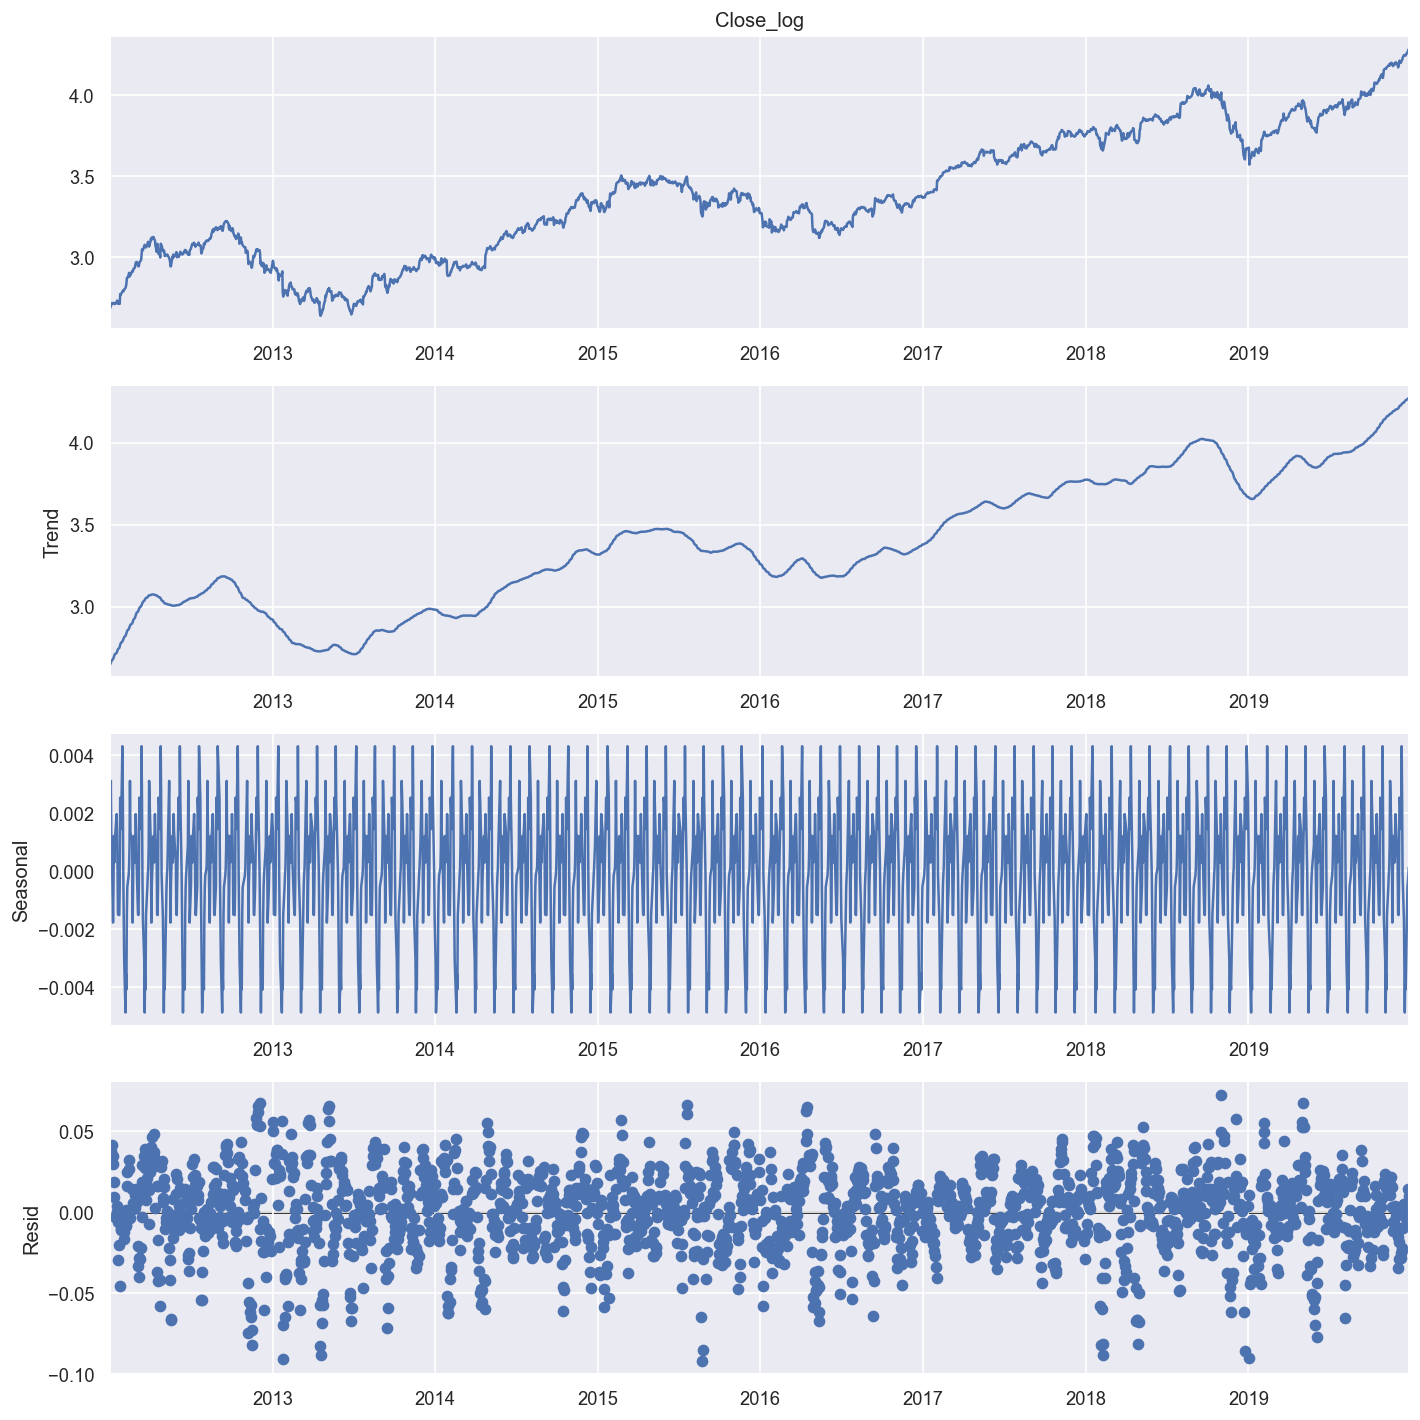

In [91]:
plt.rcParams['figure.figsize'] = [12,12]

decomp_diaria = tsa.seasonal.seasonal_decompose(df.Close_log, model='additive',extrapolate_trend='freq', freq=30)

decomp_diaria.plot()
plt.show()

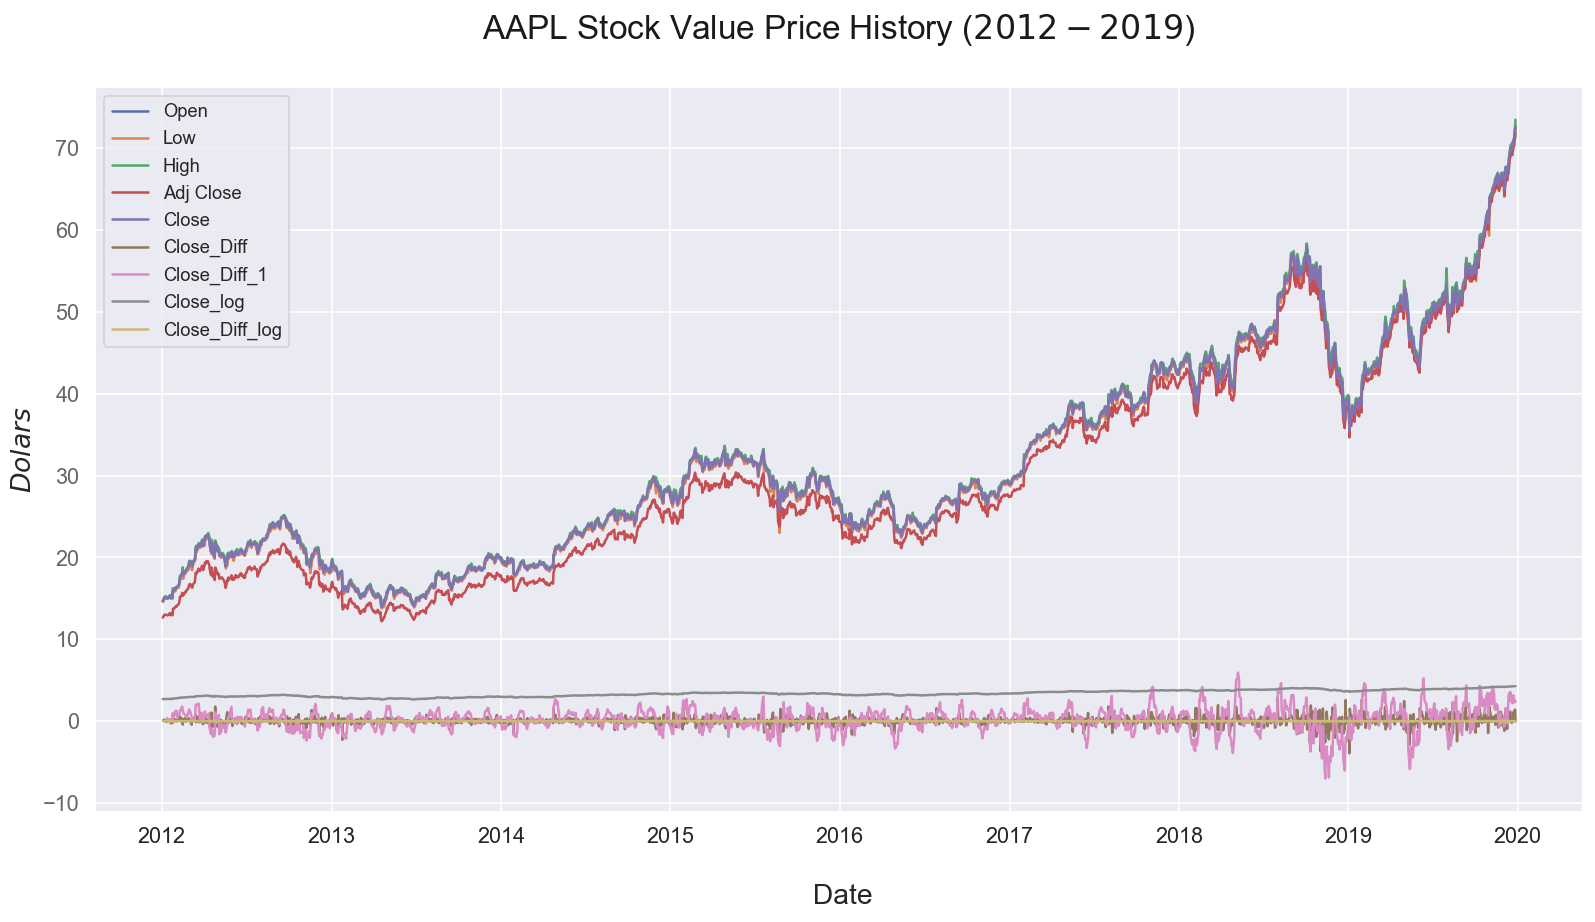

In [92]:
plt.figure(figsize=(16,8))

for col in df.drop(columns="Volume").columns :
    
    plt.plot(df.index, df[col], label = col)
    plt.title("AAPL Stock Value Price History ($2012-2019$) \n", fontsize= 20, color= "k")
    plt.xlabel("\n Date", fontsize= 17)
    plt.ylabel("$Dolars$", fontsize =16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize = 13, alpha=.7)
    plt.legend()

plt.show()

### *Conclusion Transformacion*


* _*Luego de probar distintos metodos para transformar la serie, evaluar sus resultados y observar sus descomposiciones con el metodo additivo se concluye que se trabajara con la variable `Close_log` y quizas tambien con `CLose_Diff_log` dado que la primera es la que mejor representa la variable observada y devuelve buenos resultados luego de procesarla a travez de 'seasonal_decompose'. La segunda variable que quizas se utilize, o no, es mas que nada por que los resultados devueltos por la misma funcion mencionada anteriormente, muestran una clara distribucion aleatoria de los residuales (a.k.a [White Noise](https://www.youtube.com/watch?v=cr4zIXAmSRI)) y una distribucion bien estacionaria en su componente **trend**. Por lo que se evalua el uso de esta variable para entrenar un modelo y contrastar sus resultados.*_

## *Conclusion E.D.A*

* _*Luego de realizar la exploracion necesaria en la serie de tiempo, se realizaron varios pasos de pre-procesamiento para poder entregarle al modelo los datos de la mejor manera posible.*_
            
   > * _*La serie presentaba todos sus datos correctamente registrados en el tiempo, sin ningun valor faltante o valor atipico.*_
  
  > * _*Realizar metodos como *IQR* o *3-Sigmas*, aunque fueron hechos, no es viable dado que los datos observados son correctos y dentro de lo normal.*_
   
   > * _*La autocorrelacion de la serie y el estudio de sus patrones junto con el correlograma devolvia la informacion esperada: Dado que estamos trabajando con una serie de tiempo que equivale al valor de X accion en la bolsa de mercado, la correlacion de la variable objetivo pierde mucho de si misma a medida que el tiempo pasa dada la alta volatilidad y poca estabilidad en los datos observados.*_
   
   > * _*Luego de descomponer la serie, los resultados obtenidos indicaban que la misma no era apta para el modelado por distintas razones. Poca estabilidad en su estacionalidad, alta volatilidad en sus datos, estar en presencia de una serie ciclica influenciada por muchos factores externos, residuales obtenidos luego de la descomposicion indicaban estar en presencia una serie multiplicativa con media fija en 1 (y no en presencia de White Noise).*_
   
   > * _*Se evaluo la estacionalidad de la serie a traves de distintos metodos (Dicky Fuller Test y KPSS TEST) ambos demostrando que la serie en si era no-estacionaria por lo que se aplicaron distintos metodos de transformacion, se evaluaron los mismos a traves de los mismos metodos y graficos obtenidos por seasonal decompose y se establecio la estacionalidad de la serie y la misma se encuentra lista para el modelo.*_

# Machine Learning

### *Instanciando los datos*

In [93]:
df_log = df["Close_log"]

df_log

Date
2012-01-03    2.686948
2012-01-04    2.692308
2012-01-05    2.703349
2012-01-06    2.713748
2012-01-09    2.712161
                ...   
2019-12-20    4.246493
2019-12-23    4.262680
2019-12-24    4.263630
2019-12-26    4.283276
2019-12-27    4.282897
Name: Close_log, Length: 2010, dtype: float64

In [94]:
df_log.isna().sum()

0

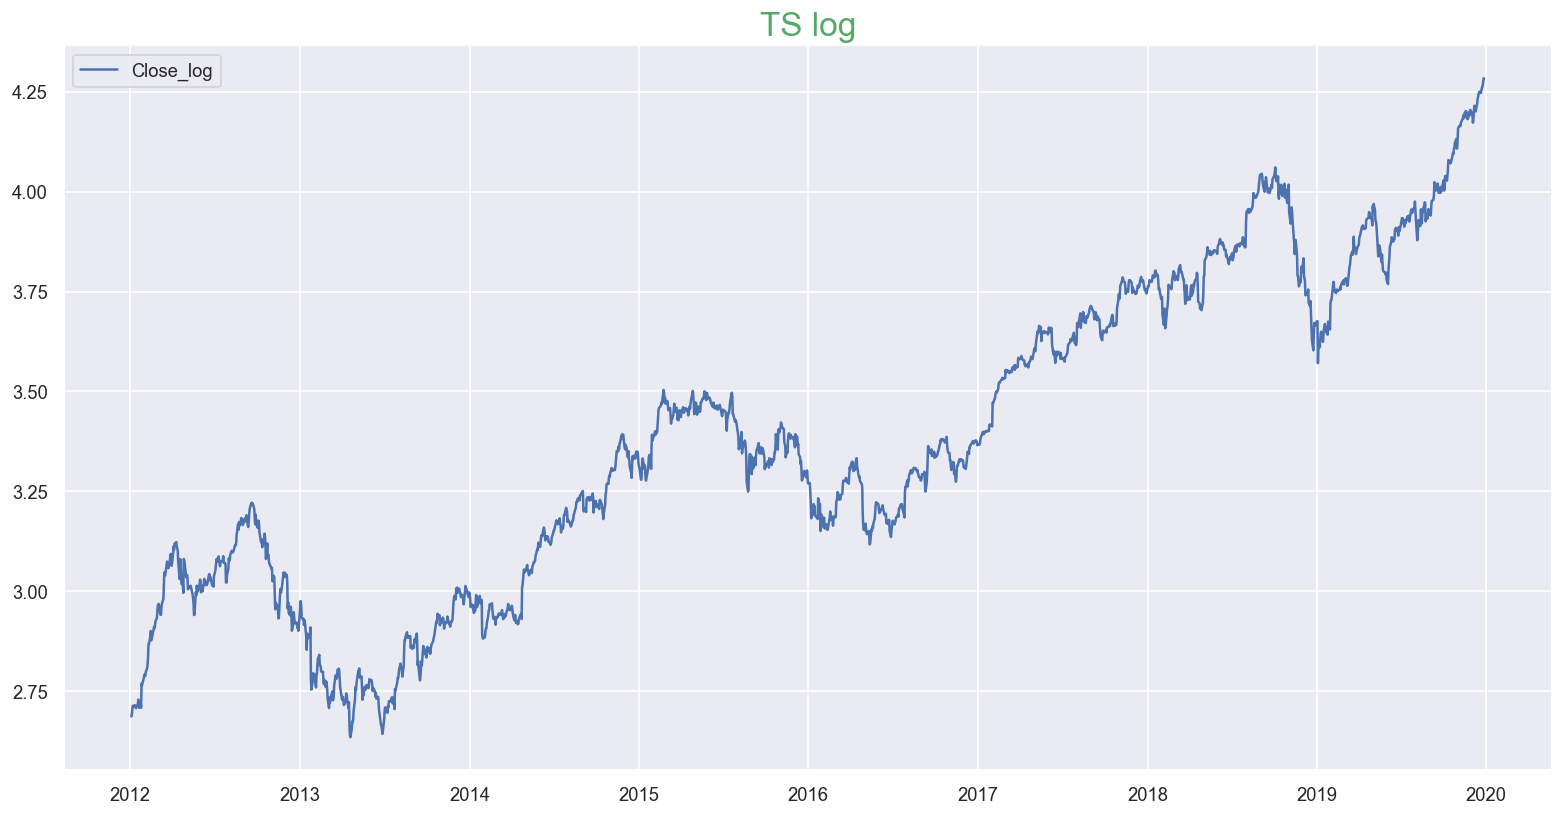

In [95]:
plt.figure(figsize=(16,8))

plt.plot(df_log, label ="Close_log")
plt.title("TS log", fontsize = 20, color ="g")
plt.legend()
plt.show()

## Benchmark

* _*Para el modelo Benchmark, propongo: Tomar los valores del 3er trimestre de 2019, calcular el promedio a travez de la operacion de pandas -rollingwindow-, calcular su RMSE por sobre los valores del 4to trimestre de 2019 y luego graficar los datos predichos a los originales.*_

In [96]:
df_log1 = pd.DataFrame(df_log)

df_log1["Month"] = [d.strftime('%b') for d in df_log.index]

In [97]:
df_log1["Month"].value_counts()

Oct    178
Aug    178
Mar    172
May    172
Jul    170
Jun    169
Apr    166
Dec    164
Jan    163
Nov    163
Sep    161
Feb    154
Name: Month, dtype: int64

In [98]:
df_log1[df_log1.index >= "2019-07-01"].Month.value_counts()

Oct    23
Jul    22
Aug    22
Nov    20
Sep    20
Dec    19
Name: Month, dtype: int64

* _*Se observa como los meses poseen distans distribuciones en cuanto a los dias registrados, siendo Diciembre el mes que menos valores posee. Por lo que, esta distribucion, ocasionara problemas a la hora de asignar cuales son las fechas que deseamos que el modelo Benchmark opere sobre.*_


* _*Diciembre posee solo 19 registros, sumando los 20 correspondientes a Noviembre y 23 de Octubre da un total de 62 dias contra los 64 dias que suman los meses de Julio, Agosto y Septiembre.*_


* _Para resolver se tomaran 2 dias menos del mes de Julio y la suma delos dias deberia de ser iguales.*_

In [99]:
# 3er Trimestre 2019
start_date= "2019-07-03"
end_date= "2019-09-30"

X_benchmark= df_log[(df_log.index >= start_date) & (df_log.index <= end_date)]


# 4to Trimestre 2019
start_date= "2019-10-01"
end_date= "2019-12-31"

Y_benchmark= df_log[(df_log.index >= start_date) & (df_log.index <= end_date)]

Y_t= X_benchmark.rolling(window=1, center=True).mean()

benchmark_rmse= np.sqrt(metrics.mean_squared_error(Y_benchmark,Y_t))

-----------------------------------------
Error RMSE Benchmark:  0.2075806422600275
-----------------------------------------


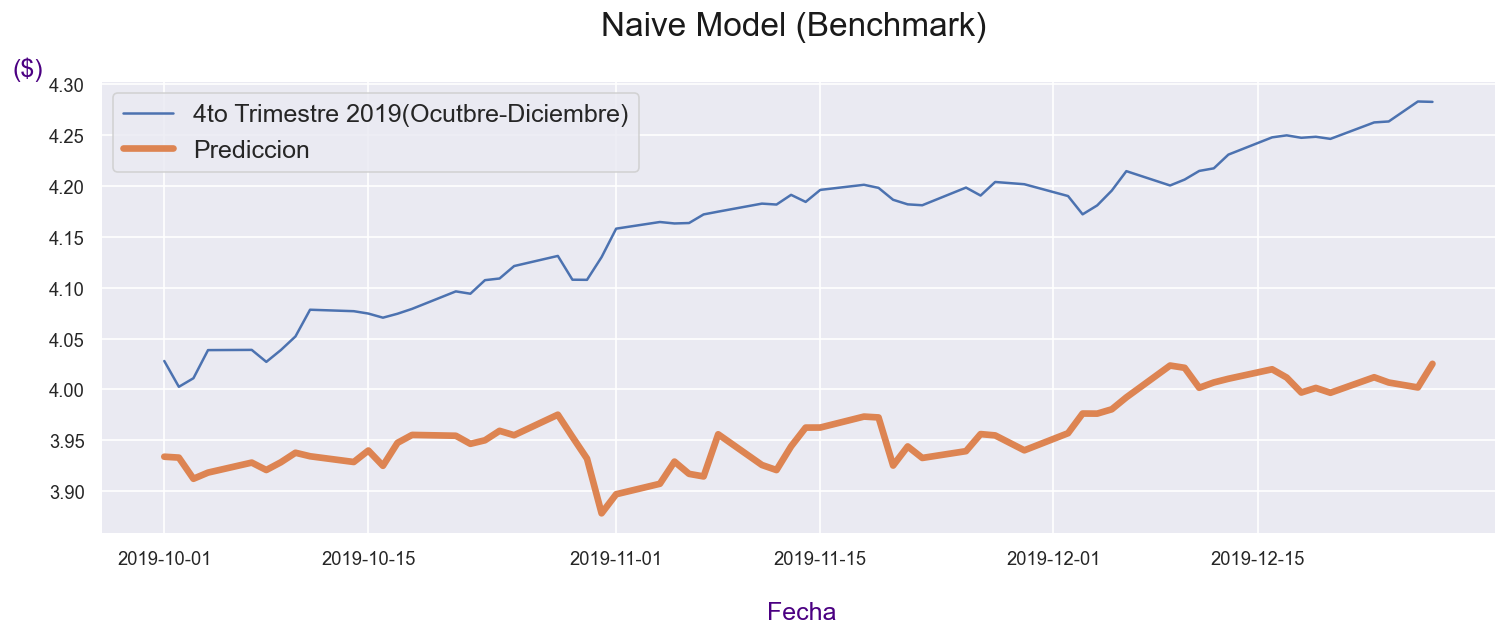

In [100]:
print("-----------------------------------------")
print("Error RMSE Benchmark: ", benchmark_rmse)
print("-----------------------------------------")


plt.figure(figsize = (15,5))


plt.plot(Y_benchmark.index, Y_benchmark.values, label = '4to Trimestre 2019(Ocutbre-Diciembre)')
plt.plot(Y_benchmark.index, Y_t.values, lw = 4, label = 'Prediccion')
plt.title("Naive Model (Benchmark) \n", color= "k", fontsize= 20)
plt.xlabel('\n Fecha', color= "indigo", fontsize=15)
plt.ylabel('($)', color= "indigo", fontsize=15, loc='top', rotation=0)
#plt.xlim(dt.date(2019,10,6), dt.date(2019,12,31))

plt.legend(fontsize= 15)
plt.show()

## Random Forest Regressor

* _*Para el modelo de RandomForestRegressor, y los demas modelos que se utilizen, se tomaran todos los datos de todos los años observados menos el ultimo trimestre del año 2019 como entrenamiento, para evaluar sobre estos ultimos 3 y luego comparar su desempeño con el modelo Benchmark.*_

### Creando X e Y

* _*Para crear X e Y en series de tiempo, se utiliza una forma un poco distinta a cuando trabajamos con otro problemas de Machine Learning.*_



* _*De esta forma primero seleccion en una nueva variable la cantidad de instancias (en este caso en frecuencia diaria) que voy a utilizar para predecir el valor siguiente.*_

* _*Creo la variable X que se compone de una matriz de 0(ceros) con forma igual a:*_
    * La cantidad total de instancias en la serie de tiempo (N) - cantidad total de instancias que voy a utilizar para predecir el valor siguiente(look_back) - 1 (para evitar un error en la ejecucion).
    * look_back. 
    
    De esta forma cree una matriz de 0(ceros) con 1947 instancias y 62 columnas(look_back).
    

* _Creo la variable Y que se compone de una matriz de 0(ceros) con forma igual a :*_
    * La cantidad total de instancias en la serie de tiempo (N) - cantidad total de instancias que voy a utilizar para predecir el valor siguiente(look_back) - 1 (para evitar un error en la ejecucion).

In [101]:
look_back =  62 # Numero de dias que voy a usar para predecir el valor siguiente.

N =  df_log.shape[0]

X = np.zeros((N - look_back - 1, look_back))
Y = np.zeros(N - look_back - 1)

In [102]:
print(X,"--", X.shape)
print("---------------------------------------")
print(Y,"--", Y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] -- (1947, 62)
---------------------------------------
[0. 0. 0. ... 0. 0. 0.] -- (1947,)


#### *Asignando valores*

* _*Una vez creadas las variables X e Y, asigno los valores a las mismas:*_

In [103]:
"""Por cada instancia que se encuentre en el rango total de X (X.shape[0], es decir 0:1947):
       - Asignarle a la instancia correspondiende en X(y todas sus columnas),el valor correspondiende de la serie y sus 62 
       valores siguientes. Es decir: Para la instancia 3 de la matriz de 0(ceros) en este caso X y sus 62 columnas, asigno
       el valor real de la instancia 3 de la serie de tiempo(en su primera columna) y a las otras 61 restantes les asigno
       el valor consecuente real a la instancia original.
       
       - Asignarle a la instancia correspondiente en Y el valor correspondiente de la serie."""


for i in range(X.shape[0]) : 
    
    X[i,:] = df_log.iloc[i:i+look_back]
    Y[i] = df_log.iloc[i+look_back]

In [104]:
print(X,"--", X.shape)
print("---------------------------------------")
print(Y,"--", Y.shape)

[[2.68694816 2.69230785 2.70334868 ... 3.09366889 3.0810249  3.06397488]
 [2.69230785 2.70334868 2.71374823 ... 3.0810249  3.06397488 3.09530288]
 [2.70334868 2.71374823 2.71216079 ... 3.06397488 3.09530288 3.11243534]
 ...
 [4.01200407 4.00683306 4.00195515 ... 4.2475662  4.24856663 4.24649325]
 [4.00683306 4.00195515 4.02521776 ... 4.24856663 4.24649325 4.26267988]
 [4.00195515 4.02521776 4.02798214 ... 4.24649325 4.26267988 4.26363009]] -- (1947, 62)
---------------------------------------
[3.09530288 3.11243534 3.10444251 ... 4.26267988 4.26363009 4.28327618] -- (1947,)


* _*Obtengo asi:*_ 
   * _*Una matriz de 1947 instancias y 62 columnas con datos para X.*_
   * _*Una matriz de 1947 instancias para Y.*_

#### _*Separando los datos en Train y Test*_

In [105]:
N_train =  1947 - look_back # Cantidad de dias que uso para entrenar al modelo.
N_test = 62 # Cantidad de dias que uso para evaluar al modelo.

N_total = N_train + N_test

Lenght_total = N_train + N_test + look_back

X_train = X[:N_train,:]
Y_train = Y[:N_train]

X_test = X[N_train:N_train+N_test,:]
Y_test= Y[N_train:N_train+N_test]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1885, 62) (1885,)
(62, 62) (62,)


### Creando el modelo

In [106]:
rfr = RandomForestRegressor(n_jobs=-1,
                            random_state=3)

rfr.fit(X_train, Y_train)

RandomForestRegressor(n_jobs=-1, random_state=3)

#### _*Cross Validation*_

In [107]:
tss = TimeSeriesSplit(n_splits=2)

In [108]:
best_score_train = abs(cross_val_score(rfr,
                                      X_train, Y_train, 
                                      cv = tss,
                                      scoring = "neg_root_mean_squared_error"))

best_score_test = abs(cross_val_score(rfr,
                                     X_test, Y_test,
                                     cv= tss,
                                     scoring= "neg_root_mean_squared_error"))

print("Best Score Train (CV=3) %0.2f (+/- %0.2f)" % (best_score_train.mean(), best_score_train.std()))

print("Best Score Test (CV=3) %0.2f (+/- %0.2f)" % (best_score_test.mean(), best_score_test.std()))

Best Score Train (CV=3) 0.21 (+/- 0.05)
Best Score Test (CV=3) 0.06 (+/- 0.02)


#### _*Prediciendo y evaluando*_

In [109]:
Y_train_pred_rfr = rfr.predict(X_train)
Y_test_pred_rfr = rfr.predict(X_test)

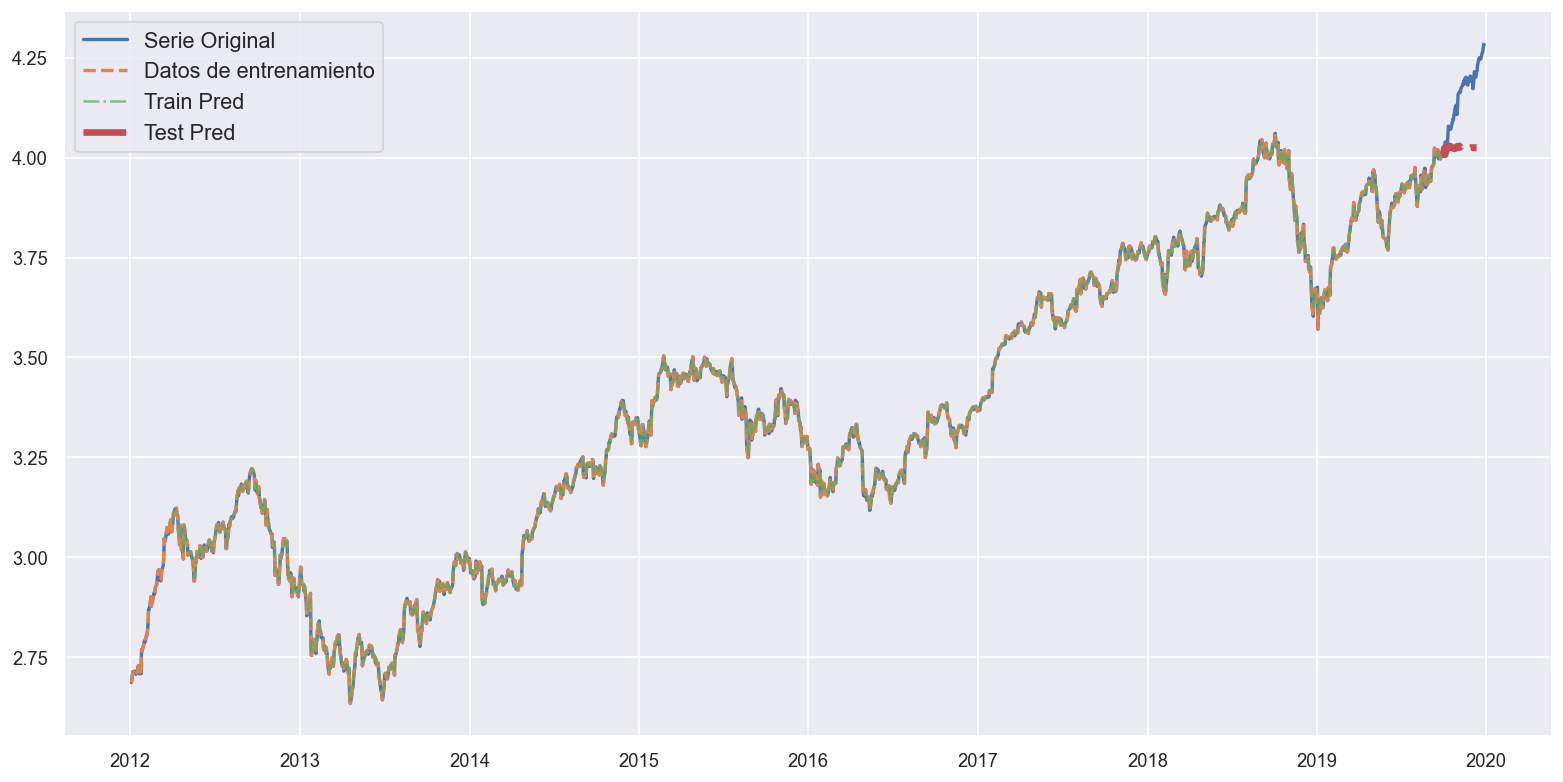

RandomForestRegressor Train RMSE:  0.0063812795930259765
RandomForestRegressor Test RMSE:  0.14689908338695787


In [110]:
plt.figure(figsize=(16,8))

plt.plot(df_log, label = "Serie Original", lw= 2)
plt.plot(df_log.index[:N_train + look_back], df_log[:N_train + look_back], '--', label = "Datos de entrenamiento", lw= 2)
plt.plot(df_log.index[look_back:look_back + N_train], Y_train_pred_rfr, '-.', label = "Train Pred", alpha=.7)
plt.plot(df_log.index[N_train+look_back : Lenght_total], Y_test_pred_rfr, '-.', label = "Test Pred", lw=4)


plt.legend(fontsize=13, loc="best")
plt.show()

rmse_train_rfr = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred_rfr))
rmse_test_rfr = np.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred_rfr))

print("RandomForestRegressor Train RMSE: ", rmse_train_rfr)
print("RandomForestRegressor Test RMSE: ", rmse_test_rfr)

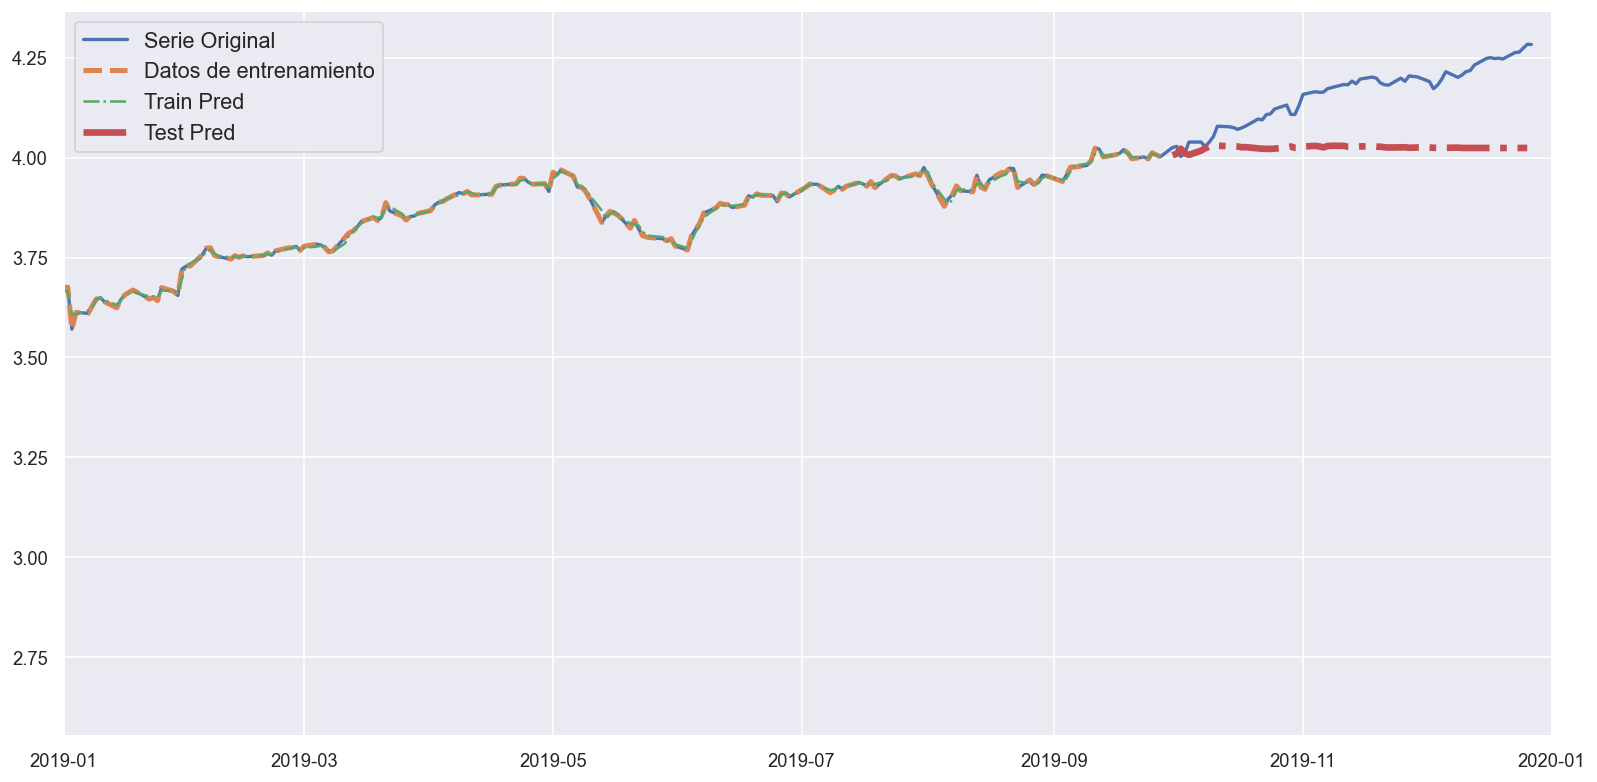

In [111]:
plt.figure(figsize=(16,8))

plt.plot(df_log, label = "Serie Original", lw= 2)
plt.plot(df_log.index[:N_train + look_back], df_log[:N_train + look_back], '--', label = "Datos de entrenamiento", lw= 3)
plt.plot(df_log.index[look_back:look_back + N_train], Y_train_pred_rfr, '-.', label = "Train Pred")
plt.plot(df_log.index[N_train+look_back : Lenght_total], Y_test_pred_rfr, '-.', label = "Test Pred", lw=4)


plt.xlim(dt.datetime(2019,1,1), dt.datetime(2020,1,1))

plt.legend(fontsize=13, loc="best")
plt.show()

#### _*GridSearchCV*_

In [120]:
"""Generamos 2600 combinaciones distintas de modelos"""

param_grid = {
    'n_estimators': [20,50,10,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(2,20)],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4,6]}



"""Estas 2600 combinaciones de multiplican por la cantidad de veces que hayamos indicando en cross_validation(3) """
model = GridSearchCV(rfr,
                    param_grid,
                    n_jobs = -1,
                    cv = tss,
                    scoring = 'neg_root_mean_squared_error',
                    verbose = 5)

In [121]:
model.fit(X_train, Y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=3),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 10, 200]},
             scoring='neg_root_mean_squared_error', verbose=5)

##### Model Results

In [122]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_max_depth param_max_features param_min_samples_leaf param_min_samples_split param_n_estimators                                             params  split0_test_score  split1_test_score  mean_test_score  std_test_score  rank_test_score
582        0.221907      0.037400         0.204453        0.199467               6               auto                      1                       5                 10  {'max_depth': 6, 'max_features': 'auto', 'min_...          -0.153964          -0.250325        -0.202145        0.048181                1
578        0.121673      0.037899         0.169547        0.032912               6               auto                      1                       2                 10  {'max_depth': 6, 'max_features': 'auto', 'min_...          -0.155586          -0.250325        -0.202956        0.047369                2
2210       0.191987      0.062333         0.146109        0.046376              17               sqrt                      1                       2                 10  {'max_depth': 17, 'max_features': 'sqrt', 'min...          -0.156291          -0.250167        -0.203229        0.046938                3

##### Model Best Score

In [123]:
abs(model.best_score_)

0.20214458531146995

###### Model Best Params

In [124]:
model.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

* _*En este caso, los mejores parametros elegidos por el modelos no son los mejores elegidos por nosotros. Como se puede observar en el dataframe creado arriba con los resultados del modelo, ordenados por mejor `test_score` el 2do mejor modelo es aquel que presenta el mejor desempeño. No solo en `test_score` sino, mas que nada, en los hiperparametros elegidos para llegar a dicho resultado.*_
     * A diferencia de los otros 2 modelos que quedaron en "el top 3", el 2do mejor utiliza menos profundidad en los arboles y de echo, alcanza un resutlado mejor que el primero. 
     
     
* Por este motivo, eligo este modelo como el mejor.
     

#### Modelando con mejoras

In [112]:
rfr = RandomForestRegressor(max_depth = 9, max_features = 'auto',
                           min_samples_leaf= 2, min_samples_split = 2, n_estimators = 200,
                           n_jobs = -1, random_state= 3)

In [113]:
rfr = RandomForestRegressor(max_depth = 6, max_features = 'auto',
                           min_samples_leaf= 1, min_samples_split = 5, n_estimators = 10,
                           n_jobs = -1, random_state= 3)

In [114]:
rfr.fit(X_train, Y_train)

RandomForestRegressor(max_depth=6, min_samples_split=5, n_estimators=10,
                      n_jobs=-1, random_state=3)

In [115]:
best_score_train =  abs(cross_val_score(rfr,
                                       X_train, Y_train, cv=tss,
                                       scoring = 'neg_root_mean_squared_error'))

best_score_test = abs(cross_val_score(rfr,
                                     X_test, Y_test, cv= tss,
                                     scoring= 'neg_root_mean_squared_error'))

print("Best Score RandomForestRegressor Train (cv=3) %0.2f (+/- %0.2f)" %
     (best_score_train.mean(), best_score_train.std()))

print("Best Score RandomForestRegressor Test (cv=3) %0.2f (+/- %0.2f)" %
     (best_score_test.mean(), best_score_test.std()))

Best Score RandomForestRegressor Train (cv=3) 0.20 (+/- 0.05)
Best Score RandomForestRegressor Test (cv=3) 0.06 (+/- 0.01)


In [116]:
Y_train_pred_rfr = rfr.predict(X_train)
Y_test_pred_rfr = rfr.predict(X_test)

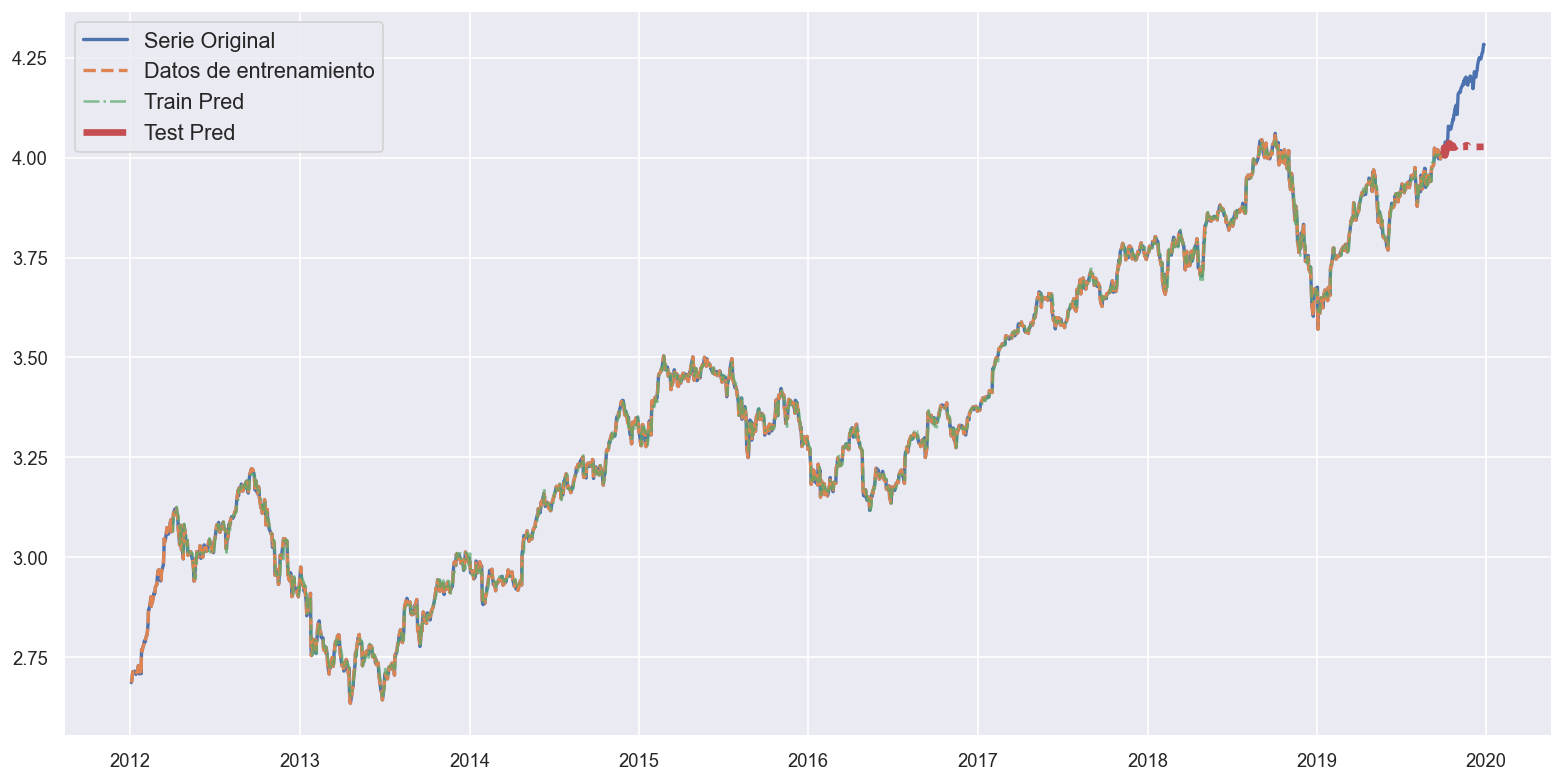

------------------------------------------------------
RandomForestRegressor(GS) RMSE Train: 0.014044126043660225
RandomForestRegressor(GS) RMSE Test: 0.1449343502401902
------------------------------------------------------


In [117]:
plt.figure(figsize=(16,8))

plt.plot(df_log, label = "Serie Original", lw= 2)
plt.plot(df_log.index[:N_train + look_back], df_log[:N_train + look_back], '--', label = "Datos de entrenamiento", lw= 2)
plt.plot(df_log.index[look_back:look_back + N_train], Y_train_pred_rfr, '-.', label = "Train Pred", alpha=.7)
plt.plot(df_log.index[N_train+look_back : Lenght_total], Y_test_pred_rfr, '-.', label = "Test Pred", lw=4)


plt.legend(fontsize=13, loc="best")
plt.show()


rmse_rfr_train = np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred_rfr))
rmse_rfr_test= np.sqrt(metrics.mean_squared_error(Y_test, Y_test_pred_rfr))

print("------------------------------------------------------")
print("RandomForestRegressor(GS) RMSE Train:", rmse_rfr_train)
print("RandomForestRegressor(GS) RMSE Test:", rmse_rfr_test)
print("------------------------------------------------------")

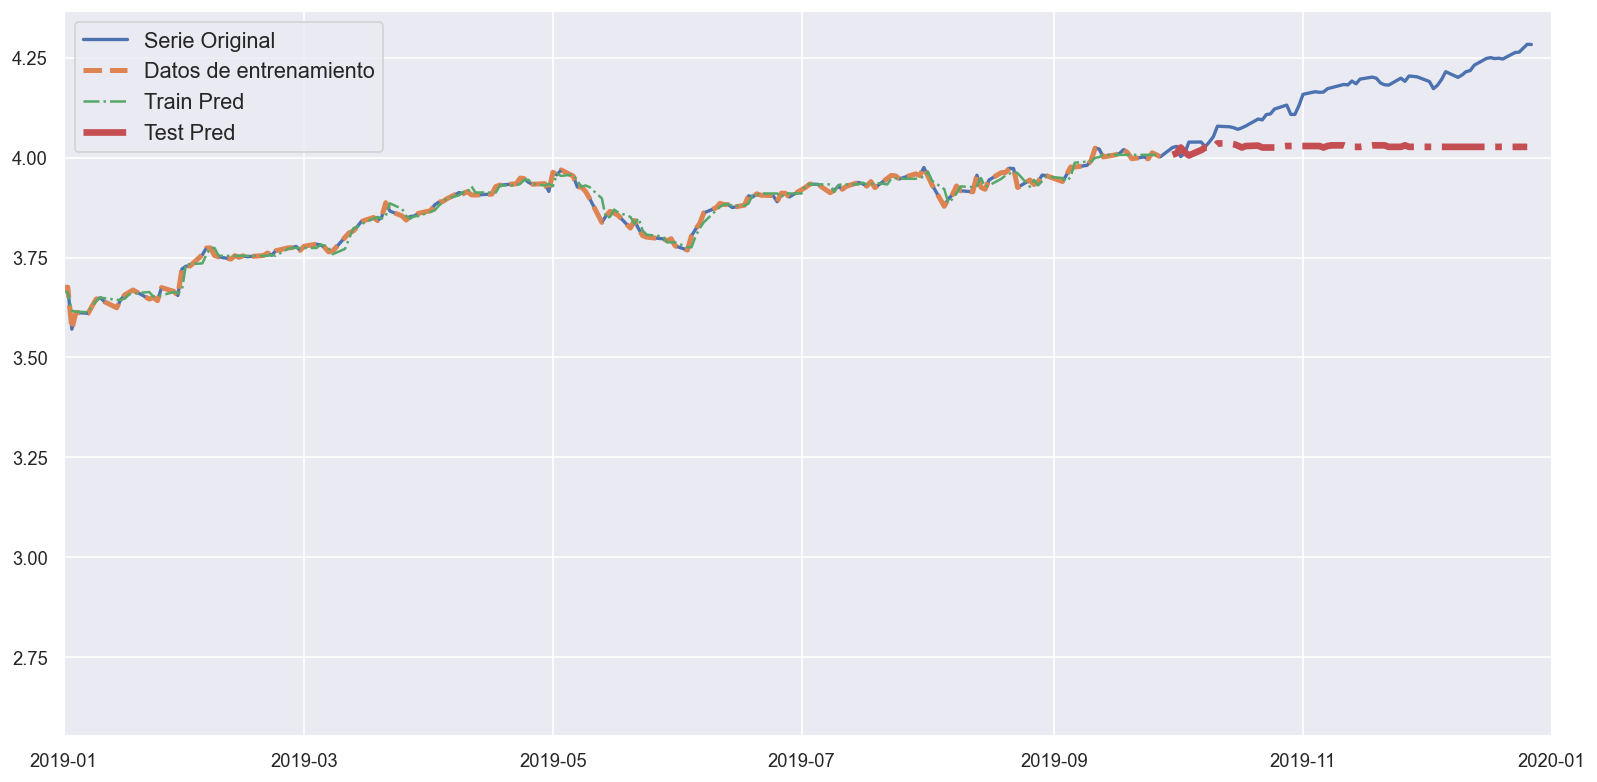

In [118]:
plt.figure(figsize=(16,8))

plt.plot(df_log, label = "Serie Original", lw= 2)
plt.plot(df_log.index[:N_train + look_back], df_log[:N_train + look_back], '--', label = "Datos de entrenamiento", lw= 3)
plt.plot(df_log.index[look_back:look_back + N_train], Y_train_pred_rfr, '-.', label = "Train Pred")
plt.plot(df_log.index[N_train+look_back : Lenght_total], Y_test_pred_rfr, '-.', label = "Test Pred", lw=4)


plt.xlim(dt.datetime(2019,1,1), dt.datetime(2020,1,1))

plt.legend(fontsize=13, loc="best")
plt.show()

#### Feature Importance

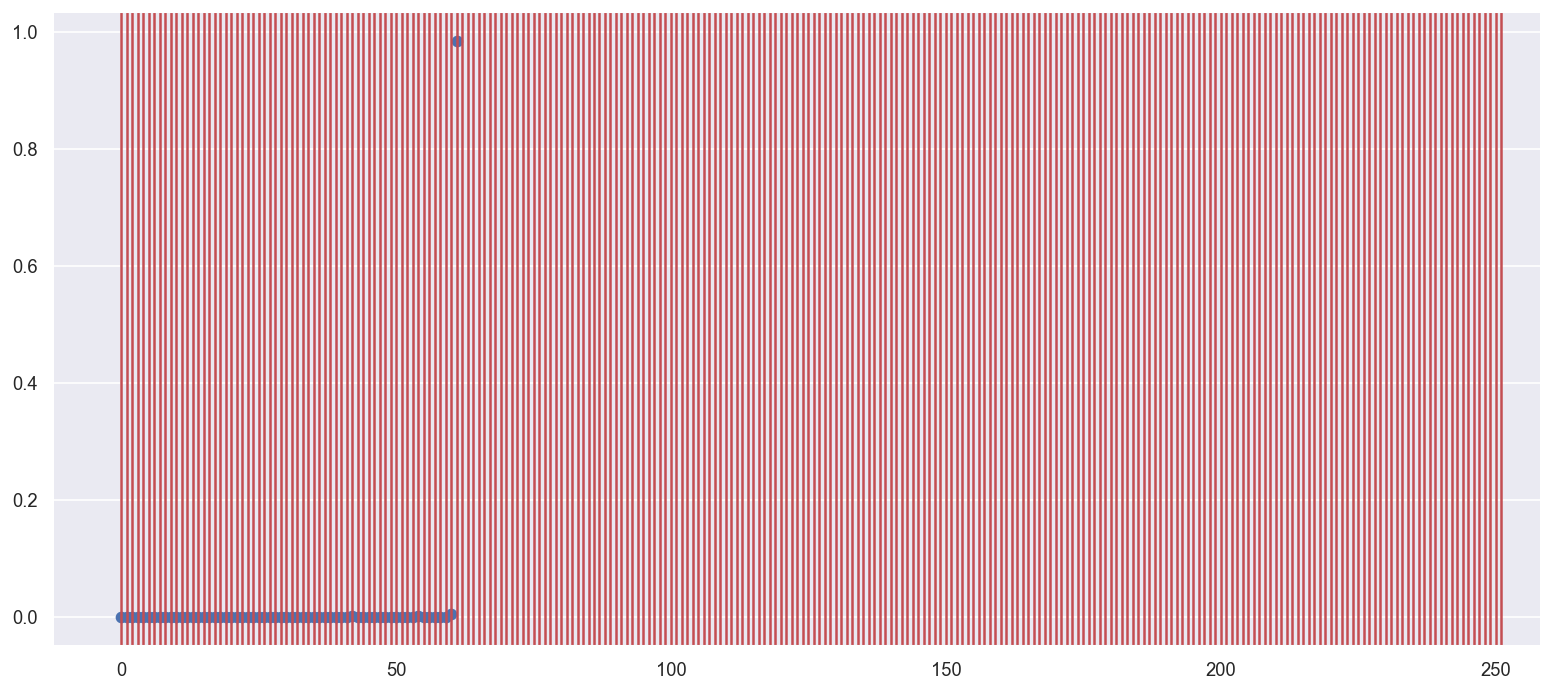

In [119]:
plt.figure(figsize = (16,7))

plt.scatter(np.arange(rfr.feature_importances_.size),rfr.feature_importances_)

for x in range(252):
    plt.axvline(x, linestyle ='-', color= 'r')
    
plt.show()

* _*Por lo visto, al evaluar los dias mas importantes para el modelo al momento de predecir el valor siguiente, este utiliza los primeros 52 valores para establecer una prediccion dando mayor importancia a los ultimos 2 dias del registro.*_

### Conclusion RandomForestRegressor


* _*Luego de crear el modelo y establecer una mejora para sus hiperparametros, el mismo no presenta una mejora notoria pero si una gran desempeño a grandes rasgos. El valor establecido(predicho) por el modelo es muy bueno, casi al punto de excelente. Por el momento el modelo asi quedara para luego ser comparado con un modelo de ARIMA y luego Prophet para evaluar si estos presentan mejoras en cuanto a este modelo.*_

## A.R.I.M.A

* _*Luego de evaluar, en un notebook separado(dado que la libreria no era compatible con Python 3.8), las mejores combinaciones de p,d,q para el modelo de ARIMA los resultados indican que la combinacion 1,0,1(0,0,0) resepectivamente seria la mejor para captar la esencia del modelo.*_ 

### Creando Modelo

In [120]:
model = ARIMA(df_log, order=(1,0,1))

results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:              Close_log   No. Observations:                 2010
Model:                     ARMA(1, 1)   Log Likelihood                5434.358
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sat, 20 Feb 2021   AIC                         -10860.715
Time:                        15:53:43   BIC                         -10838.292
Sample:                             0   HQIC                        -10852.484
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.4605      0.594      5.823      0.000       2.296       4.625
ar.L1.Close_log     0.9997      0.000   2603.924      0.000       0.999       1.000
ma.L1.Close_log     0.0206      

In [121]:
prediction = results.predict(start="2019-10-03",  dynamic=False)

prediction

Date
2019-10-03    4.001914
2019-10-04    4.011078
2019-10-07    4.039096
2019-10-08    4.038744
2019-10-09    4.026728
2019-10-10    4.038864
2019-10-11    4.052274
2019-10-14    4.078781
2019-10-15    4.076766
2019-10-16    4.074426
2019-10-17    4.070347
2019-10-18    4.074384
2019-10-21    4.079190
2019-10-22    4.096634
2019-10-23    4.093939
2019-10-24    4.107594
2019-10-25    4.108990
2019-10-28    4.121451
2019-10-29    4.131364
2019-10-30    4.107286
2019-10-31    4.107655
2019-11-01    4.130459
2019-11-04    4.158543
2019-11-05    4.164643
2019-11-06    4.163051
2019-11-07    4.163520
2019-11-08    4.172159
2019-11-11    4.174770
2019-11-12    4.182764
2019-11-13    4.181665
2019-11-14    4.191417
2019-11-15    4.184132
2019-11-18    4.196331
2019-11-19    4.201211
2019-11-20    4.198012
2019-11-21    4.186131
2019-11-22    4.181791
2019-11-25    4.180984
2019-11-26    4.198735
2019-11-27    4.190371
2019-11-29    4.204157
2019-12-02    4.201623
2019-12-03    4.189810
2019-1

### Graficando y Evaluando

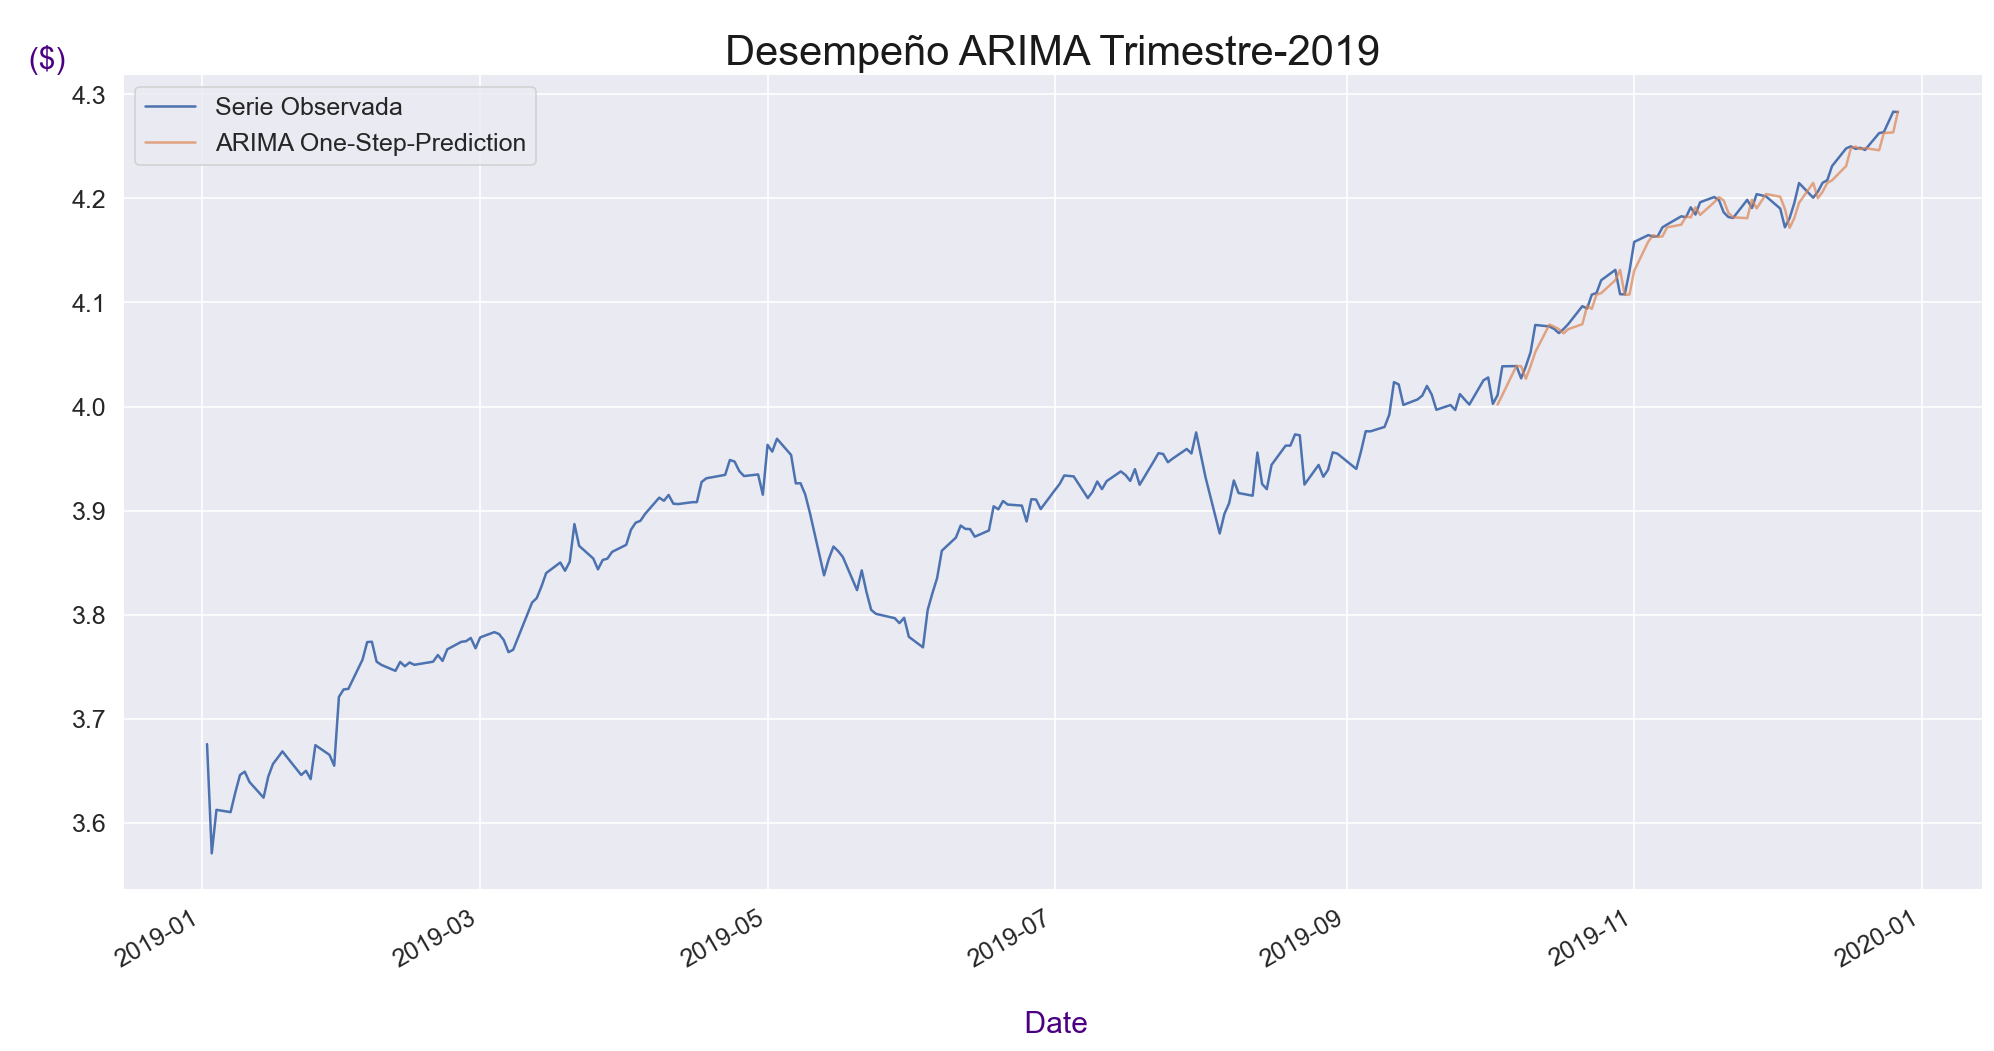

In [122]:
plt.figure(figsize=(20,10))

ax = df_log['2019':].plot(label='Serie Observada')
prediction.plot(ax=ax, label='ARIMA One-Step-Prediction', alpha=0.7)



plt.title("Desempeño ARIMA Trimestre-2019", color= 'k', fontsize=25)
ax.set_xlabel("\n Date", fontsize=18, color='indigo')
ax.set_ylabel("\n  ($)", loc= 'top', rotation=0, fontsize=18,color='indigo')
#plt.xlim(dt.datetime(2019,1,1), dt.datetime(2019,12,29))
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

plt.legend(fontsize=15)
plt.show()

In [123]:
y_forecast= prediction
y_real = df_log['2019-10-03':]


rmse_sarimax_one = np.sqrt(metrics.mean_squared_error(y_forecast, y_real))
print("RMSE- ARIMA: ", rmse_sarimax_one)

RMSE- ARIMA:  0.011849465802136248


### Conlcusion A.R.I.M.A


* _*Luego de probar distinas combinacioes, en un notebook aparte dada la imcompatibilidad de cierta libreria con Python 3.8, se encotre la mejor combinacion de parametros p,d,q para el modelo A.R.I.M.A y se obtuvo un excelente resultado. Se observa que el modelo simplemente falla por muy muy poco y su prediccion en cuanto a los datos reales es muy buena, **RMSE= 0.0011839**.*_



* _*Por el momento el modelo A.R.I.MA se desempeño mejor que RandomForestRegressor y seria el de cabecera para trabajar sobre futuros proyectos relacionados a predicciones de valor de acciones.*_


* Como modelos extras, se entrenaran 2 modelos mas. El primero sera uno facil y mas simple que el resto, Prophet y por ultimo utilizare un modelo de LSTM(Long-Short-Term-Mermory) para luego, evaluar entre los 4 cual desarrolla mejor sobre los datos de observados y cual me devuelve la mejor prediccion para el año 2020.*_

## Prophet

### Re-ordenando los datos

In [124]:
df_prophet = df_log.copy()

df_prophet = df_prophet.reset_index()

df_prophet = df_prophet.rename(columns={'Date':'ds',
                                       'Close_log': 'y'})

* _*Prophet solo toma 2 valores. `ds` = a las fechas registradas y `y` = los valores registrados en dichas fechas.*_

### Creando el modelo 

In [125]:
prophet_model= Prophet(interval_width= 0.95)

prophet_model.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [126]:
prophet_dates = prophet_model.make_future_dataframe(periods = 365, freq= "D")

prophet_dates= prophet_dates[prophet_dates["ds"].isin(df_log.index)]

prophet_dates

ds
0    2012-01-03
1    2012-01-04
2    2012-01-05
3    2012-01-06
4    2012-01-09
...         ...
2005 2019-12-20
2006 2019-12-23
2007 2019-12-24
2008 2019-12-26
2009 2019-12-27

[2010 rows x 1 columns]

#### Generando prediccion

In [127]:
prophet_pred = prophet_model.predict(prophet_dates)
prophet_pred[['ds','yhat','yhat_lower','yhat_upper']].head()

ds      yhat  yhat_lower  yhat_upper
0 2012-01-03  2.768393    2.649202    2.891375
1 2012-01-04  2.767611    2.649319    2.890152
2 2012-01-05  2.767116    2.656231    2.890026
3 2012-01-06  2.765450    2.643729    2.885555
4 2012-01-09  2.767211    2.642642    2.881495

* _*Hasta aqui el modelo de Prophet fue entrando y su prediccion fue echa. A simple viste no se ve una mejor prediccion sobre el valor predicho (**y_hat**) mejor a A.R.I.M.A. Ahora solo queda contrastar el resultado con la prediccion del mejor modelo(ARIMA).*_

### Graficando y Evaluando

#### Prediccion completa

In [128]:
prophet_pred_2019= prophet_pred[(prophet_pred.ds >= '2019-10-03') & (prophet_pred.ds <= '2019-12-27')]

prophet_pred_2019.drop(columns=["trend", "yhat_lower", "yhat_upper",
                       "trend_lower", "trend_upper", "additive_terms",
                       "additive_terms_lower", "additive_terms_upper",
                       "yearly", "yearly_lower", "yearly_upper", 
                       "multiplicative_terms", "multiplicative_terms_lower", 
                       "multiplicative_terms_upper","weekly", "weekly_lower", "weekly_upper"], inplace= True)

prophet_pred_2019.rename(columns={'ds': 'Date',
                            'yhat': 'Close_log'}, inplace=True)

prophet_pred_2019 = prophet_pred_2019.set_index("Date")


prophet_pred_2019

Close_log
Date                 
2019-10-03   4.029855
2019-10-04   4.027877
2019-10-07   4.028964
2019-10-08   4.030843
2019-10-09   4.030715
2019-10-10   4.030968
2019-10-11   4.030156
2019-10-14   4.035192
2019-10-15   4.038439
2019-10-16   4.039647
2019-10-17   4.041172
2019-10-18   4.041534
2019-10-21   4.049190
2019-10-22   4.052920
2019-10-23   4.054384
2019-10-24   4.055922
2019-10-25   4.056048
2019-10-28   4.061524
2019-10-29   4.064074
2019-10-30   4.064164
2019-10-31   4.064162
2019-11-01   4.062616
2019-11-04   4.062641
2019-11-05   4.063363
2019-11-06   4.061687
2019-11-07   4.060021
2019-11-08   4.056948
2019-11-11   4.053526
2019-11-12   4.053555
2019-11-13   4.051439
2019-11-14   4.049590
2019-11-15   4.046589
2019-11-18   4.044808
2019-11-19   4.045788
2019-11-20   4.044778
2019-11-21   4.044153
2019-11-22   4.042458
2019-11-25   4.044667
2019-11-26   4.046865
2019-11-27   4.046950
2019-11-29   4.046319
2019-12-02   4.049412
2019-12-03   4.051400
2019-12-04   4.051013
2019-12-05   4.050598
2019-12-06   4.048678
2019-12-09   4.047556
2019-12-10   4.047797
2019-12-11   4.045548
2019-12-12   4.043190
2019-12-13   4.039284
2019-12-16   4.032322
2019-12-17   4.030774
2019-12-18   4.026867
2019-12-19   4.023008
2019-12-20   4.017780
2019-12-23   4.008063
2019-12-24   4.006021
2019-12-26   3.997886
2019-12-27   3.992759

<Figure size 1920x960 with 0 Axes>

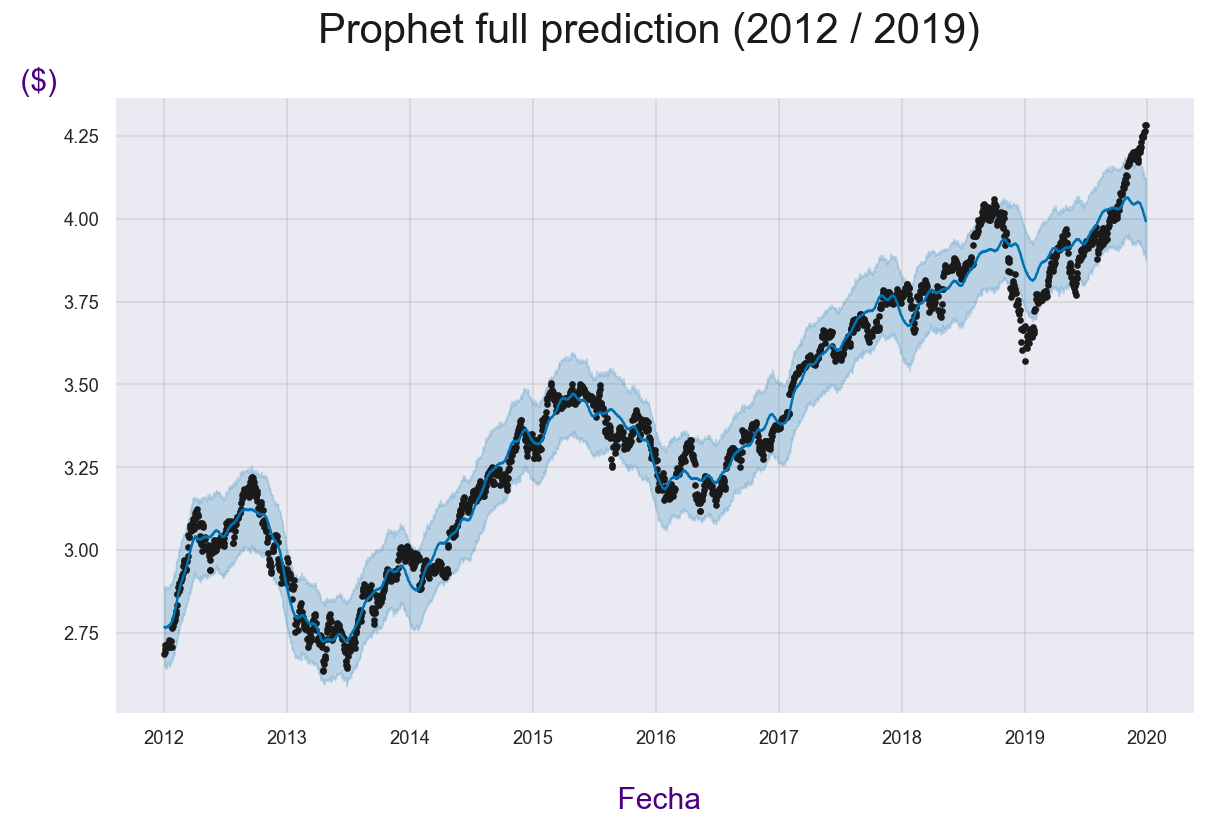

In [129]:
plt.figure(figsize=(16,8))

prophet_model.plot(prophet_pred, uncertainty=True)

plt.title("Prophet full prediction (2012 / 2019) \n", color ='k', fontsize = 25)
plt.xlabel("\n Fecha", fontsize=18, color = 'indigo')
plt.ylabel("\n ($)", fontsize=18, loc= 'top', rotation=0, color='indigo')

plt.show()

* _*Los **puntos negros** representan la **serie observada**.*_


* _*La **linea azul** representan los valores predichos por Prophet sobre las fechas entrendas.*_


* _*Las **regiones sombreadas** representan los intervalos de confianza de la prediccion.*_

#### Prediccion 4to Trimestro 2019

##### Generando los datos para comparar

In [130]:
arima_pred_2019 = pd.concat([prophet_dates, prediction], axis=0)
arima_pred_2019.drop(columns=['ds'], inplace=True)
arima_pred_2019.dropna(inplace= True)
arima_pred_2019 = arima_pred_2019.reset_index()
arima_pred_2019.rename(columns={0: 'Close_log'}, inplace=True)
arima_pred_2019 = arima_pred_2019.set_index("index")

##### Graficando

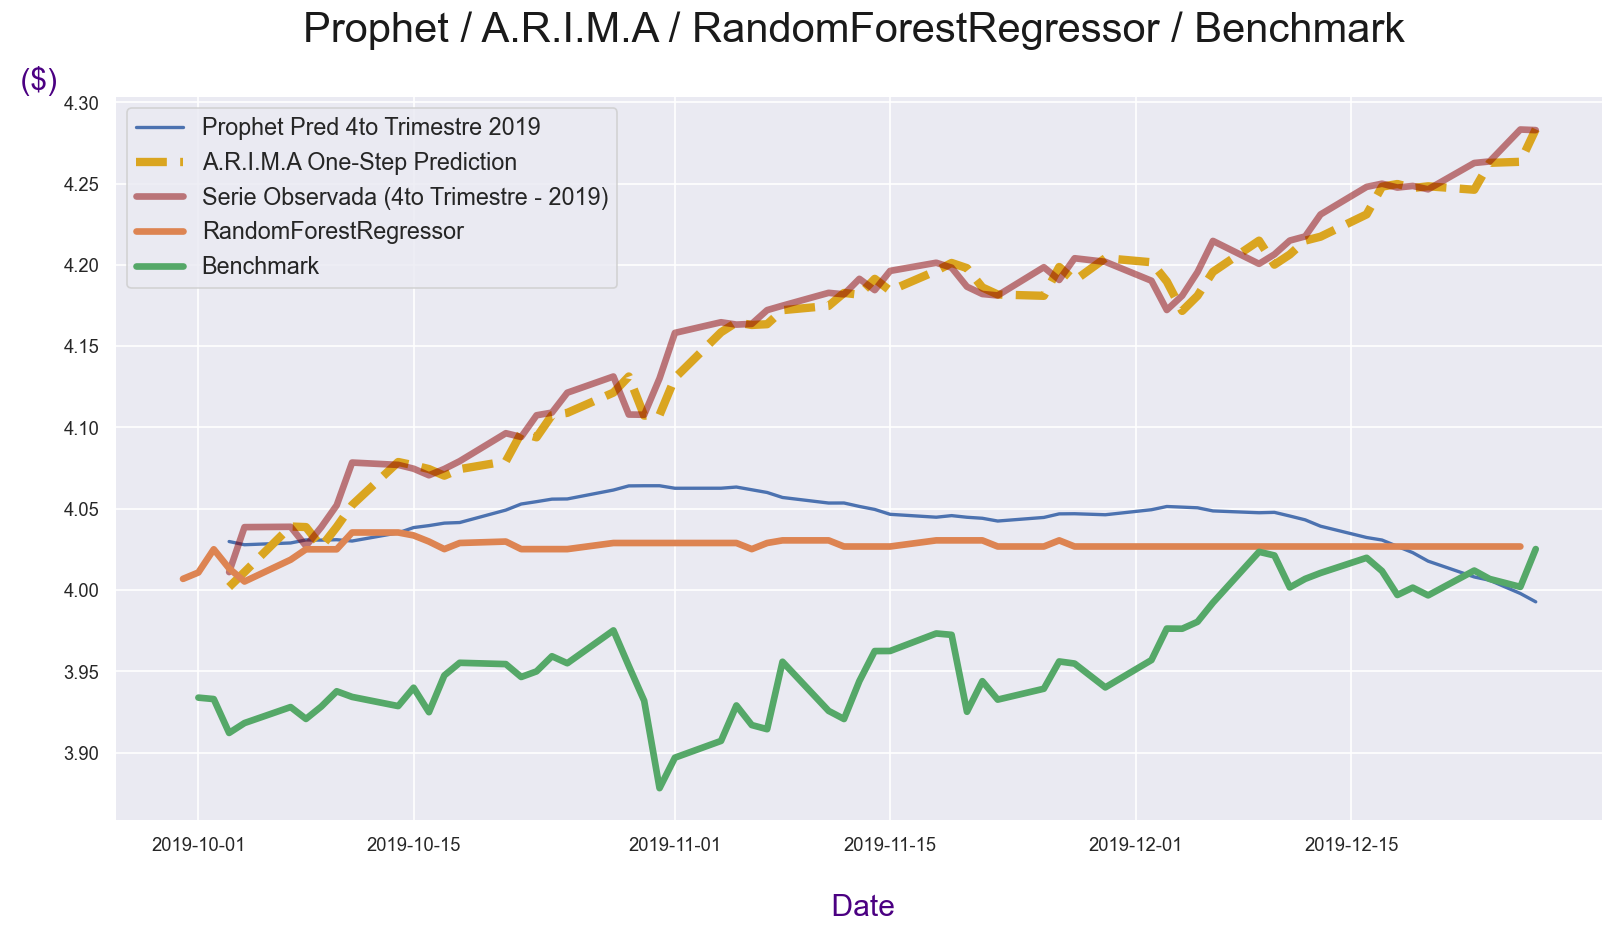

RMSE Prophet: 0.14047049306648826
RMSE ARIMA: 0.011849465802136248
RMSE RandomForestRegressor(GS): 0.1449343502401902
RMSE Benchmark:  0.2075806422600275


In [131]:
plt.figure(figsize=(16,8))

plt.plot(prophet_pred_2019.index, prophet_pred_2019.Close_log, lw=2, label="Prophet Pred 4to Trimestre 2019")
plt.plot(arima_pred_2019.index, arima_pred_2019.Close_log,'--' ,lw= 5, label ="A.R.I.M.A One-Step Prediction", alpha=1, color="goldenrod")
plt.plot(y_real, lw=4, label="Serie Observada (4to Trimestre - 2019)", alpha= 0.5, color ='darkred')
plt.plot(df_log.index[N_train+look_back : Lenght_total], Y_test_pred_rfr, label = "RandomForestRegressor", lw=4)
plt.plot(Y_benchmark.index, Y_t.values, lw = 4, label = 'Benchmark')
plt.xlabel("\n Date", fontsize= 18, color ="indigo")
plt.ylabel("\n ($)", fontsize=18, color = 'indigo', loc = 'top', rotation= 0)
plt.title("Prophet / A.R.I.M.A / RandomForestRegressor / Benchmark \n", fontsize = 25, color="k")
plt.legend(loc='best', fontsize =14)

plt.show()


y_forecast_prophet= prophet_pred_2019.Close_log

rmse_prophet= np.sqrt(metrics.mean_squared_error(y_forecast_prophet, y_real ))
print("RMSE Prophet:", rmse_prophet)
print("RMSE ARIMA:", rmse_sarimax_one)
print("RMSE RandomForestRegressor(GS):", rmse_rfr_test)
print("RMSE Benchmark: ", benchmark_rmse)

### Conclusion Prophet

* _*Si bien el modelo capta muy bien la esencia de la serie y predice con un alto nivel de confianza, el modelo de A.R.I.M.A sigue ganando en su desempeño y por mucho a los otros 2 modelos creados. Lo bueno que tiene Prophet es su simpleza a la hora de generar un modelo, entrenarlo y pedir que realice una prediccion para luego evaluarlo.*_


* _*Por el momento, hasta realiar un modelo de LSTM el modelo de ARIMA sigue siendo el mejor al momenot de captar la esencia de la serie y predecir sobre la misma. Luego veremos que modelo es que el mejor predice el año 2020.*_

## LSTM